In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

EPISODES = 1000
EPISODES_TEST = int(EPISODES/2)
LEARNING_RATE = 0.0001
MEM_SIZE = 10000
BATCH_SIZE = 32
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.001


FC1_DIMS = 1024
FC2_DIMS = 512
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(*self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0

        self.states = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=np.bool)

    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE

        self.states[mem_index]  = state.clone().detach().numpy()
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_.clone().detach().numpy()
        self.dones[mem_index] =  1 - done

        self.mem_count += 1

    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network()

    def choose_action(self, observation, eps_greedy=True):
        if eps_greedy and random.random() < self.exploration_rate:
            return env.action_space.sample(), 0.0

        state = observation
        state = state.to(DEVICE)
        state = state.unsqueeze(0)

        q_values = self.network(state)
        return torch.argmax(q_values).item(), q_values

    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return

        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.long).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        states_ = torch.tensor(states_, dtype=torch.float32).to(DEVICE)
        dones = torch.tensor(dones, dtype=torch.bool).to(DEVICE)

        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)
        states.requires_grad = True
        
        q_values = self.network(states)
        next_q_values = self.network(states_)

        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0].detach()
        
        q_target = rewards + GAMMA * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)        
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate

## Training the network (only run if wanting to train again)

In [3]:
agent_clean = DQN_Solver()
agent_clean.network.train()

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []

for i in range(1, EPISODES):
    state = env.reset()
    score = 0

    while True:
        action, q_values = agent_clean.choose_action(state)
        
        state_, reward, done, info = env.step(action)
        agent_clean.memory.add(state, action, reward, state_, done)
        agent_clean.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent_clean.returning_epsilon()))
            break

        episode_number.append(i)
        average_reward_number.append(average_reward/i)


/tmp/ipykernel_640/1353702249.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


Episode 1 Average Reward 13.0 Best Reward 13.0 Last Reward 13.0 Epsilon 1.0
Episode 2 Average Reward 13.5 Best Reward 14.0 Last Reward 14.0 Epsilon 1.0
Episode 3 Average Reward 13.0 Best Reward 14.0 Last Reward 12.0 Epsilon 0.9920279440699441
Episode 4 Average Reward 13.25 Best Reward 14.0 Last Reward 14.0 Epsilon 0.9782294672887405
Episode 5 Average Reward 13.0 Best Reward 14.0 Last Reward 12.0 Epsilon 0.9665550620990835
Episode 6 Average Reward 16.0 Best Reward 31.0 Last Reward 31.0 Epsilon 0.9370369888620198
Episode 7 Average Reward 15.571428571428571 Best Reward 31.0 Last Reward 13.0 Epsilon 0.9249283295681431
Episode 8 Average Reward 16.125 Best Reward 31.0 Last Reward 20.0 Epsilon 0.9066044494080763
Episode 9 Average Reward 15.555555555555555 Best Reward 31.0 Last Reward 11.0 Epsilon 0.8966815144183318
Episode 10 Average Reward 16.5 Best Reward 31.0 Last Reward 25.0 Epsilon 0.8745314299402548
Episode 11 Average Reward 16.09090909090909 Best Reward 31.0 Last Reward 12.0 Epsilon 0.

Episode 84 Average Reward 178.96428571428572 Best Reward 461.0 Last Reward 232.0 Epsilon 0.001
Episode 85 Average Reward 179.85882352941175 Best Reward 461.0 Last Reward 255.0 Epsilon 0.001
Episode 86 Average Reward 180.5 Best Reward 461.0 Last Reward 235.0 Epsilon 0.001
Episode 87 Average Reward 181.01149425287358 Best Reward 461.0 Last Reward 225.0 Epsilon 0.001
Episode 88 Average Reward 183.07954545454547 Best Reward 461.0 Last Reward 363.0 Epsilon 0.001
Episode 89 Average Reward 183.7078651685393 Best Reward 461.0 Last Reward 239.0 Epsilon 0.001
Episode 90 Average Reward 184.2888888888889 Best Reward 461.0 Last Reward 236.0 Epsilon 0.001
Episode 91 Average Reward 185.01098901098902 Best Reward 461.0 Last Reward 250.0 Epsilon 0.001
Episode 92 Average Reward 186.30434782608697 Best Reward 461.0 Last Reward 304.0 Epsilon 0.001
Episode 93 Average Reward 186.32258064516128 Best Reward 461.0 Last Reward 188.0 Epsilon 0.001
Episode 94 Average Reward 189.4255319148936 Best Reward 478.0 Las

Episode 171 Average Reward 214.66081871345028 Best Reward 478.0 Last Reward 247.0 Epsilon 0.001
Episode 172 Average Reward 214.66860465116278 Best Reward 478.0 Last Reward 216.0 Epsilon 0.001
Episode 173 Average Reward 214.66473988439307 Best Reward 478.0 Last Reward 214.0 Epsilon 0.001
Episode 174 Average Reward 214.72988505747125 Best Reward 478.0 Last Reward 226.0 Epsilon 0.001
Episode 175 Average Reward 214.69142857142856 Best Reward 478.0 Last Reward 208.0 Epsilon 0.001
Episode 176 Average Reward 214.64772727272728 Best Reward 478.0 Last Reward 207.0 Epsilon 0.001
Episode 177 Average Reward 214.51977401129943 Best Reward 478.0 Last Reward 192.0 Epsilon 0.001
Episode 178 Average Reward 214.5 Best Reward 478.0 Last Reward 211.0 Epsilon 0.001
Episode 179 Average Reward 214.62011173184356 Best Reward 478.0 Last Reward 236.0 Epsilon 0.001
Episode 180 Average Reward 214.7277777777778 Best Reward 478.0 Last Reward 234.0 Epsilon 0.001
Episode 181 Average Reward 214.56906077348066 Best Rew

Episode 258 Average Reward 222.63565891472868 Best Reward 478.0 Last Reward 190.0 Epsilon 0.001
Episode 259 Average Reward 222.59073359073358 Best Reward 478.0 Last Reward 211.0 Epsilon 0.001
Episode 260 Average Reward 222.69615384615383 Best Reward 478.0 Last Reward 250.0 Epsilon 0.001
Episode 261 Average Reward 222.8007662835249 Best Reward 478.0 Last Reward 250.0 Epsilon 0.001
Episode 262 Average Reward 222.68702290076337 Best Reward 478.0 Last Reward 193.0 Epsilon 0.001
Episode 263 Average Reward 222.7338403041825 Best Reward 478.0 Last Reward 235.0 Epsilon 0.001
Episode 264 Average Reward 222.62121212121212 Best Reward 478.0 Last Reward 193.0 Epsilon 0.001
Episode 265 Average Reward 222.48301886792453 Best Reward 478.0 Last Reward 186.0 Epsilon 0.001
Episode 266 Average Reward 222.41729323308272 Best Reward 478.0 Last Reward 205.0 Epsilon 0.001
Episode 267 Average Reward 222.39700374531836 Best Reward 478.0 Last Reward 217.0 Epsilon 0.001
Episode 268 Average Reward 222.41417910447

Episode 344 Average Reward 223.27325581395348 Best Reward 478.0 Last Reward 282.0 Epsilon 0.001
Episode 345 Average Reward 223.18840579710144 Best Reward 478.0 Last Reward 194.0 Epsilon 0.001
Episode 346 Average Reward 223.53179190751445 Best Reward 478.0 Last Reward 342.0 Epsilon 0.001
Episode 347 Average Reward 223.48703170028818 Best Reward 478.0 Last Reward 208.0 Epsilon 0.001
Episode 348 Average Reward 223.51724137931035 Best Reward 478.0 Last Reward 234.0 Epsilon 0.001
Episode 349 Average Reward 223.68194842406876 Best Reward 478.0 Last Reward 281.0 Epsilon 0.001
Episode 350 Average Reward 223.74 Best Reward 478.0 Last Reward 244.0 Epsilon 0.001
Episode 351 Average Reward 223.9145299145299 Best Reward 478.0 Last Reward 285.0 Epsilon 0.001
Episode 352 Average Reward 223.98579545454547 Best Reward 478.0 Last Reward 249.0 Epsilon 0.001
Episode 353 Average Reward 224.09065155807366 Best Reward 478.0 Last Reward 261.0 Epsilon 0.001
Episode 354 Average Reward 224.29378531073445 Best Re

Episode 433 Average Reward 235.02078521939953 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 434 Average Reward 234.52764976958525 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 435 Average Reward 234.01839080459771 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 436 Average Reward 233.51146788990826 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 437 Average Reward 233.0045766590389 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 438 Average Reward 232.50228310502283 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 439 Average Reward 231.99544419134395 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 440 Average Reward 231.4909090909091 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 441 Average Reward 230.98866213151928 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 442 Average Reward 230.49095022624434 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 443 Average Reward 230.21444695259595 Best R

Episode 520 Average Reward 241.85192307692307 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 521 Average Reward 242.34740882917467 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 522 Average Reward 242.84099616858236 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 523 Average Reward 243.33269598470363 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 524 Average Reward 243.62977099236642 Best Reward 500.0 Last Reward 399.0 Epsilon 0.001
Episode 525 Average Reward 244.11809523809524 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 526 Average Reward 244.6045627376426 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 527 Average Reward 245.08918406072107 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 528 Average Reward 245.5719696969697 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 529 Average Reward 246.05293005671078 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 530 Average Reward 246.53207547169

Episode 607 Average Reward 264.5700164744646 Best Reward 500.0 Last Reward 163.0 Epsilon 0.001
Episode 608 Average Reward 264.39473684210526 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 609 Average Reward 264.7816091954023 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 610 Average Reward 265.1672131147541 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 611 Average Reward 265.5515548281506 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 612 Average Reward 265.93464052287584 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 613 Average Reward 266.31647634584016 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 614 Average Reward 266.16775244299674 Best Reward 500.0 Last Reward 175.0 Epsilon 0.001
Episode 615 Average Reward 266.4178861788618 Best Reward 500.0 Last Reward 420.0 Epsilon 0.001
Episode 616 Average Reward 266.24512987012986 Best Reward 500.0 Last Reward 160.0 Epsilon 0.001
Episode 617 Average Reward 266.6239870340357 

Episode 694 Average Reward 257.1743515850144 Best Reward 500.0 Last Reward 160.0 Epsilon 0.001
Episode 695 Average Reward 257.021582733813 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 696 Average Reward 256.8807471264368 Best Reward 500.0 Last Reward 159.0 Epsilon 0.001
Episode 697 Average Reward 256.7245337159254 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 698 Average Reward 256.5730659025788 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 699 Average Reward 256.4220314735336 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 700 Average Reward 256.27714285714285 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 701 Average Reward 256.12696148359487 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 702 Average Reward 256.0128205128205 Best Reward 500.0 Last Reward 176.0 Epsilon 0.001
Episode 703 Average Reward 255.87339971550497 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 704 Average Reward 255.72727272727272 Be

Episode 780 Average Reward 245.9576923076923 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 781 Average Reward 245.8629961587708 Best Reward 500.0 Last Reward 172.0 Epsilon 0.001
Episode 782 Average Reward 245.72634271099744 Best Reward 500.0 Last Reward 139.0 Epsilon 0.001
Episode 783 Average Reward 245.63346104725414 Best Reward 500.0 Last Reward 173.0 Epsilon 0.001
Episode 784 Average Reward 245.5 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 785 Average Reward 245.37452229299362 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 786 Average Reward 245.25063613231552 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 787 Average Reward 245.143583227446 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 788 Average Reward 245.0469543147208 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 789 Average Reward 244.9315589353612 Best Reward 500.0 Last Reward 154.0 Epsilon 0.001
Episode 790 Average Reward 244.83037974683543 Best Reward 5

Episode 873 Average Reward 229.73539518900344 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 874 Average Reward 229.48398169336383 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 875 Average Reward 229.23314285714287 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 876 Average Reward 228.98173515981736 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 877 Average Reward 228.73204104903078 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 878 Average Reward 228.48063781321184 Best Reward 500.0 Last Reward 8.0 Epsilon 0.001
Episode 879 Average Reward 228.23094425483504 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 880 Average Reward 227.98295454545453 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 881 Average Reward 227.7355278093076 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 882 Average Reward 227.4875283446712 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 883 Average Reward 227.24122310305776 Best Reward

Episode 959 Average Reward 229.26277372262774 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 960 Average Reward 229.39166666666668 Best Reward 500.0 Last Reward 353.0 Epsilon 0.001
Episode 961 Average Reward 229.3069719042664 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 962 Average Reward 229.38149688149687 Best Reward 500.0 Last Reward 301.0 Epsilon 0.001
Episode 963 Average Reward 229.3208722741433 Best Reward 500.0 Last Reward 171.0 Epsilon 0.001
Episode 964 Average Reward 229.41597510373444 Best Reward 500.0 Last Reward 321.0 Epsilon 0.001
Episode 965 Average Reward 229.59481865284974 Best Reward 500.0 Last Reward 402.0 Epsilon 0.001
Episode 966 Average Reward 229.5248447204969 Best Reward 500.0 Last Reward 162.0 Epsilon 0.001
Episode 967 Average Reward 229.62564632885213 Best Reward 500.0 Last Reward 327.0 Epsilon 0.001
Episode 968 Average Reward 229.59607438016528 Best Reward 500.0 Last Reward 201.0 Epsilon 0.001
Episode 969 Average Reward 229.512899896800

In [4]:
#Saving the model 
#ONLY RUN WHEN TRAINED AGAIN
torch.save(agent_clean, "clean_trained_DQN.pth")

## Testing the network

In [5]:
def attack_FGSM(state, epsilon, agent):
    state.requires_grad_()
    q_values = agent.network(state.to(DEVICE))
    index_worst_case = torch.argmin(q_values)
    loss_softmax = -torch.log(torch.softmax(q_values,0)[index_worst_case])
    gradient_sign = torch.autograd.grad(loss_softmax,state,retain_graph=True)[0].sign()
    pert_state = state - gradient_sign * epsilon
    return pert_state.detach()


In [6]:
def test_network(agent):
    agent.network.eval()
    
    best_reward = 0

    episode_number = []
    average_reward_number_attacked = []
    epsilons_attacks = [0,0.02,0.05,0.08,0.10,0.14,0.18,0.22]

    for epsilon in epsilons_attacks:
        average_reward_attacked = 0
        print("NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS:", epsilon)
        for i in range(1,EPISODES_TEST):
            state = env.reset()
            score = 0
            while True:
                pert_state = attack_FGSM(state, epsilon, agent)
                action, q_values = agent.choose_action(pert_state,eps_greedy= False)
                state_, reward, done, info = env.step(action)

                state = state_.detach()
                score += reward

                if done:            
                    if score > best_reward:
                        best_reward = score
                    average_reward_attacked += score
                    print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward_attacked/i, best_reward, score, agent.returning_epsilon()))
                    break

                episode_number.append(i)

        average_reward_number_attacked.append(average_reward_attacked / i)
    return average_reward_number_attacked
    

In [7]:
agent_clean = torch.load("clean_trained_DQN.pth")
average_reward_number_attacked = test_network(agent_clean)

NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode 1 Average Reward 165.0 Best Reward 165.0 Last Reward 165.0 Epsilon 0.001
Episode 2 Average Reward 284.5 Best Reward 404.0 Last Reward 404.0 Epsilon 0.001
Episode 3 Average Reward 250.33333333333334 Best Reward 404.0 Last Reward 182.0 Epsilon 0.001
Episode 4 Average Reward 291.5 Best Reward 415.0 Last Reward 415.0 Epsilon 0.001
Episode 5 Average Reward 302.2 Best Reward 415.0 Last Reward 345.0 Epsilon 0.001
Episode 6 Average Reward 284.3333333333333 Best Reward 415.0 Last Reward 195.0 Epsilon 0.001
Episode 7 Average Reward 267.57142857142856 Best Reward 415.0 Last Reward 167.0 Epsilon 0.001
Episode 8 Average Reward 296.625 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 9 Average Reward 285.77777777777777 Best Reward 500.0 Last Reward 199.0 Epsilon 0.001
Episode 10 Average Reward 272.7 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 11 Average Reward 279.90909090909093 Best Reward 500.0 Last Reward 352.0 Epsilon 

Episode 90 Average Reward 272.4222222222222 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 91 Average Reward 271.2087912087912 Best Reward 500.0 Last Reward 162.0 Epsilon 0.001
Episode 92 Average Reward 270.0108695652174 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 93 Average Reward 270.55913978494624 Best Reward 500.0 Last Reward 321.0 Epsilon 0.001
Episode 94 Average Reward 271.3404255319149 Best Reward 500.0 Last Reward 344.0 Epsilon 0.001
Episode 95 Average Reward 272.9263157894737 Best Reward 500.0 Last Reward 422.0 Epsilon 0.001
Episode 96 Average Reward 274.1354166666667 Best Reward 500.0 Last Reward 389.0 Epsilon 0.001
Episode 97 Average Reward 273.03092783505156 Best Reward 500.0 Last Reward 167.0 Epsilon 0.001
Episode 98 Average Reward 274.3979591836735 Best Reward 500.0 Last Reward 407.0 Epsilon 0.001
Episode 99 Average Reward 275.17171717171715 Best Reward 500.0 Last Reward 351.0 Epsilon 0.001
Episode 100 Average Reward 274.28 Best Reward 500.0 Last 

Episode 177 Average Reward 275.090395480226 Best Reward 500.0 Last Reward 321.0 Epsilon 0.001
Episode 178 Average Reward 274.7134831460674 Best Reward 500.0 Last Reward 208.0 Epsilon 0.001
Episode 179 Average Reward 274.1005586592179 Best Reward 500.0 Last Reward 165.0 Epsilon 0.001
Episode 180 Average Reward 274.9277777777778 Best Reward 500.0 Last Reward 423.0 Epsilon 0.001
Episode 181 Average Reward 275.5414364640884 Best Reward 500.0 Last Reward 386.0 Epsilon 0.001
Episode 182 Average Reward 275.1758241758242 Best Reward 500.0 Last Reward 209.0 Epsilon 0.001
Episode 183 Average Reward 274.57923497267757 Best Reward 500.0 Last Reward 166.0 Epsilon 0.001
Episode 184 Average Reward 275.25 Best Reward 500.0 Last Reward 398.0 Epsilon 0.001
Episode 185 Average Reward 274.772972972973 Best Reward 500.0 Last Reward 187.0 Epsilon 0.001
Episode 186 Average Reward 275.1989247311828 Best Reward 500.0 Last Reward 354.0 Epsilon 0.001
Episode 187 Average Reward 275.6844919786096 Best Reward 500.0

Episode 264 Average Reward 271.2878787878788 Best Reward 500.0 Last Reward 381.0 Epsilon 0.001
Episode 265 Average Reward 271.1698113207547 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 266 Average Reward 270.94736842105266 Best Reward 500.0 Last Reward 212.0 Epsilon 0.001
Episode 267 Average Reward 270.83895131086143 Best Reward 500.0 Last Reward 242.0 Epsilon 0.001
Episode 268 Average Reward 271.14179104477614 Best Reward 500.0 Last Reward 352.0 Epsilon 0.001
Episode 269 Average Reward 271.9925650557621 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 270 Average Reward 271.85555555555555 Best Reward 500.0 Last Reward 235.0 Epsilon 0.001
Episode 271 Average Reward 272.0516605166052 Best Reward 500.0 Last Reward 325.0 Epsilon 0.001
Episode 272 Average Reward 271.6764705882353 Best Reward 500.0 Last Reward 170.0 Epsilon 0.001
Episode 273 Average Reward 271.3919413919414 Best Reward 500.0 Last Reward 194.0 Epsilon 0.001
Episode 274 Average Reward 271.6131386861314 B

Episode 350 Average Reward 272.3 Best Reward 500.0 Last Reward 197.0 Epsilon 0.001
Episode 351 Average Reward 272.40455840455843 Best Reward 500.0 Last Reward 309.0 Epsilon 0.001
Episode 352 Average Reward 272.05965909090907 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 353 Average Reward 272.23229461756375 Best Reward 500.0 Last Reward 333.0 Epsilon 0.001
Episode 354 Average Reward 271.97740112994353 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 355 Average Reward 271.88732394366195 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 356 Average Reward 271.5674157303371 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 357 Average Reward 271.2857142857143 Best Reward 500.0 Last Reward 171.0 Epsilon 0.001
Episode 358 Average Reward 270.9972067039106 Best Reward 500.0 Last Reward 168.0 Epsilon 0.001
Episode 359 Average Reward 270.74930362116993 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 360 Average Reward 270.5833333333333 Best Reward

Episode 437 Average Reward 271.66590389016017 Best Reward 500.0 Last Reward 189.0 Epsilon 0.001
Episode 438 Average Reward 271.6324200913242 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 439 Average Reward 271.86788154897494 Best Reward 500.0 Last Reward 375.0 Epsilon 0.001
Episode 440 Average Reward 271.6522727272727 Best Reward 500.0 Last Reward 177.0 Epsilon 0.001
Episode 441 Average Reward 271.53514739229024 Best Reward 500.0 Last Reward 220.0 Epsilon 0.001
Episode 442 Average Reward 271.3891402714932 Best Reward 500.0 Last Reward 207.0 Epsilon 0.001
Episode 443 Average Reward 271.3544018058691 Best Reward 500.0 Last Reward 256.0 Epsilon 0.001
Episode 444 Average Reward 271.1216216216216 Best Reward 500.0 Last Reward 168.0 Epsilon 0.001
Episode 445 Average Reward 270.8561797752809 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 446 Average Reward 271.0403587443946 Best Reward 500.0 Last Reward 353.0 Epsilon 0.001
Episode 447 Average Reward 270.8255033557047 Be

Episode 26 Average Reward 321.6923076923077 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 27 Average Reward 322.55555555555554 Best Reward 500.0 Last Reward 345.0 Epsilon 0.001
Episode 28 Average Reward 319.25 Best Reward 500.0 Last Reward 230.0 Epsilon 0.001
Episode 29 Average Reward 317.2068965517241 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 30 Average Reward 317.46666666666664 Best Reward 500.0 Last Reward 325.0 Epsilon 0.001
Episode 31 Average Reward 319.80645161290323 Best Reward 500.0 Last Reward 390.0 Epsilon 0.001
Episode 32 Average Reward 321.375 Best Reward 500.0 Last Reward 370.0 Epsilon 0.001
Episode 33 Average Reward 318.969696969697 Best Reward 500.0 Last Reward 242.0 Epsilon 0.001
Episode 34 Average Reward 321.0882352941176 Best Reward 500.0 Last Reward 391.0 Epsilon 0.001
Episode 35 Average Reward 325.48571428571427 Best Reward 500.0 Last Reward 475.0 Epsilon 0.001
Episode 36 Average Reward 326.5 Best Reward 500.0 Last Reward 362.0 Epsilon 0.

Episode 114 Average Reward 327.7894736842105 Best Reward 500.0 Last Reward 404.0 Epsilon 0.001
Episode 115 Average Reward 328.8521739130435 Best Reward 500.0 Last Reward 450.0 Epsilon 0.001
Episode 116 Average Reward 328.2241379310345 Best Reward 500.0 Last Reward 256.0 Epsilon 0.001
Episode 117 Average Reward 327.5811965811966 Best Reward 500.0 Last Reward 253.0 Epsilon 0.001
Episode 118 Average Reward 327.5508474576271 Best Reward 500.0 Last Reward 324.0 Epsilon 0.001
Episode 119 Average Reward 327.8235294117647 Best Reward 500.0 Last Reward 360.0 Epsilon 0.001
Episode 120 Average Reward 329.2583333333333 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 121 Average Reward 330.3388429752066 Best Reward 500.0 Last Reward 460.0 Epsilon 0.001
Episode 122 Average Reward 330.1639344262295 Best Reward 500.0 Last Reward 309.0 Epsilon 0.001
Episode 123 Average Reward 330.2439024390244 Best Reward 500.0 Last Reward 340.0 Epsilon 0.001
Episode 124 Average Reward 330.94354838709677 Best

Episode 201 Average Reward 327.8606965174129 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 202 Average Reward 327.91584158415844 Best Reward 500.0 Last Reward 339.0 Epsilon 0.001
Episode 203 Average Reward 328.3152709359606 Best Reward 500.0 Last Reward 409.0 Epsilon 0.001
Episode 204 Average Reward 327.9166666666667 Best Reward 500.0 Last Reward 247.0 Epsilon 0.001
Episode 205 Average Reward 328.11219512195123 Best Reward 500.0 Last Reward 368.0 Epsilon 0.001
Episode 206 Average Reward 328.9466019417476 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 207 Average Reward 329.1014492753623 Best Reward 500.0 Last Reward 361.0 Epsilon 0.001
Episode 208 Average Reward 328.55288461538464 Best Reward 500.0 Last Reward 215.0 Epsilon 0.001
Episode 209 Average Reward 328.63157894736844 Best Reward 500.0 Last Reward 345.0 Epsilon 0.001
Episode 210 Average Reward 328.26666666666665 Best Reward 500.0 Last Reward 252.0 Epsilon 0.001
Episode 211 Average Reward 328.3080568720379 

Episode 288 Average Reward 325.33680555555554 Best Reward 500.0 Last Reward 316.0 Epsilon 0.001
Episode 289 Average Reward 325.75086505190313 Best Reward 500.0 Last Reward 445.0 Epsilon 0.001
Episode 290 Average Reward 326.35172413793106 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 291 Average Reward 326.3333333333333 Best Reward 500.0 Last Reward 321.0 Epsilon 0.001
Episode 292 Average Reward 326.0650684931507 Best Reward 500.0 Last Reward 248.0 Epsilon 0.001
Episode 293 Average Reward 325.84982935153585 Best Reward 500.0 Last Reward 263.0 Epsilon 0.001
Episode 294 Average Reward 326.14285714285717 Best Reward 500.0 Last Reward 412.0 Epsilon 0.001
Episode 295 Average Reward 325.8677966101695 Best Reward 500.0 Last Reward 245.0 Epsilon 0.001
Episode 296 Average Reward 325.56081081081084 Best Reward 500.0 Last Reward 235.0 Epsilon 0.001
Episode 297 Average Reward 325.62626262626264 Best Reward 500.0 Last Reward 345.0 Epsilon 0.001
Episode 298 Average Reward 325.181208053691

Episode 374 Average Reward 325.7245989304813 Best Reward 500.0 Last Reward 236.0 Epsilon 0.001
Episode 375 Average Reward 325.56533333333334 Best Reward 500.0 Last Reward 266.0 Epsilon 0.001
Episode 376 Average Reward 325.5425531914894 Best Reward 500.0 Last Reward 317.0 Epsilon 0.001
Episode 377 Average Reward 325.60477453580904 Best Reward 500.0 Last Reward 349.0 Epsilon 0.001
Episode 378 Average Reward 325.8835978835979 Best Reward 500.0 Last Reward 431.0 Epsilon 0.001
Episode 379 Average Reward 326.1451187335092 Best Reward 500.0 Last Reward 425.0 Epsilon 0.001
Episode 380 Average Reward 325.7631578947368 Best Reward 500.0 Last Reward 181.0 Epsilon 0.001
Episode 381 Average Reward 325.5196850393701 Best Reward 500.0 Last Reward 233.0 Epsilon 0.001
Episode 382 Average Reward 325.3586387434555 Best Reward 500.0 Last Reward 264.0 Epsilon 0.001
Episode 383 Average Reward 325.14882506527414 Best Reward 500.0 Last Reward 245.0 Epsilon 0.001
Episode 384 Average Reward 325.2578125 Best Rew

Episode 461 Average Reward 322.5531453362256 Best Reward 500.0 Last Reward 398.0 Epsilon 0.001
Episode 462 Average Reward 322.5151515151515 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 463 Average Reward 322.59611231101513 Best Reward 500.0 Last Reward 360.0 Epsilon 0.001
Episode 464 Average Reward 322.4806034482759 Best Reward 500.0 Last Reward 269.0 Epsilon 0.001
Episode 465 Average Reward 322.2430107526882 Best Reward 500.0 Last Reward 212.0 Epsilon 0.001
Episode 466 Average Reward 322.2961373390558 Best Reward 500.0 Last Reward 347.0 Epsilon 0.001
Episode 467 Average Reward 322.06852248394006 Best Reward 500.0 Last Reward 216.0 Epsilon 0.001
Episode 468 Average Reward 322.2628205128205 Best Reward 500.0 Last Reward 413.0 Epsilon 0.001
Episode 469 Average Reward 322.1897654584222 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 470 Average Reward 322.0425531914894 Best Reward 500.0 Last Reward 253.0 Epsilon 0.001
Episode 471 Average Reward 322.0700636942675 Bes

Episode 51 Average Reward 155.37254901960785 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 52 Average Reward 154.48076923076923 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 53 Average Reward 154.22641509433961 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 54 Average Reward 153.74074074074073 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 55 Average Reward 154.63636363636363 Best Reward 500.0 Last Reward 203.0 Epsilon 0.001
Episode 56 Average Reward 154.92857142857142 Best Reward 500.0 Last Reward 171.0 Epsilon 0.001
Episode 57 Average Reward 156.1578947368421 Best Reward 500.0 Last Reward 225.0 Epsilon 0.001
Episode 58 Average Reward 155.91379310344828 Best Reward 500.0 Last Reward 142.0 Epsilon 0.001
Episode 59 Average Reward 156.5084745762712 Best Reward 500.0 Last Reward 191.0 Epsilon 0.001
Episode 60 Average Reward 155.8 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 61 Average Reward 156.55737704918033 Best Reward 500.0 La

Episode 138 Average Reward 158.2173913043478 Best Reward 500.0 Last Reward 181.0 Epsilon 0.001
Episode 139 Average Reward 157.86330935251797 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 140 Average Reward 157.57142857142858 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 141 Average Reward 157.68794326241135 Best Reward 500.0 Last Reward 174.0 Epsilon 0.001
Episode 142 Average Reward 157.35915492957747 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 143 Average Reward 157.58041958041957 Best Reward 500.0 Last Reward 189.0 Epsilon 0.001
Episode 144 Average Reward 157.24305555555554 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 145 Average Reward 157.02068965517242 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 146 Average Reward 157.3835616438356 Best Reward 500.0 Last Reward 210.0 Epsilon 0.001
Episode 147 Average Reward 157.61904761904762 Best Reward 500.0 Last Reward 192.0 Epsilon 0.001
Episode 148 Average Reward 157.5 Best Rewa

Episode 224 Average Reward 159.57142857142858 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 225 Average Reward 159.6888888888889 Best Reward 500.0 Last Reward 186.0 Epsilon 0.001
Episode 226 Average Reward 159.67256637168143 Best Reward 500.0 Last Reward 156.0 Epsilon 0.001
Episode 227 Average Reward 159.83259911894274 Best Reward 500.0 Last Reward 196.0 Epsilon 0.001
Episode 228 Average Reward 159.62719298245614 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 229 Average Reward 159.51965065502182 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 230 Average Reward 159.60434782608695 Best Reward 500.0 Last Reward 179.0 Epsilon 0.001
Episode 231 Average Reward 159.42424242424244 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 232 Average Reward 159.5905172413793 Best Reward 500.0 Last Reward 198.0 Epsilon 0.001
Episode 233 Average Reward 159.81115879828326 Best Reward 500.0 Last Reward 211.0 Epsilon 0.001
Episode 234 Average Reward 159.96153846153

Episode 310 Average Reward 161.18064516129033 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 311 Average Reward 161.31511254019293 Best Reward 500.0 Last Reward 203.0 Epsilon 0.001
Episode 312 Average Reward 161.41346153846155 Best Reward 500.0 Last Reward 192.0 Epsilon 0.001
Episode 313 Average Reward 161.49520766773162 Best Reward 500.0 Last Reward 187.0 Epsilon 0.001
Episode 314 Average Reward 161.40764331210192 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 315 Average Reward 161.26984126984127 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 316 Average Reward 161.08860759493672 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 317 Average Reward 161.16403785488959 Best Reward 500.0 Last Reward 185.0 Epsilon 0.001
Episode 318 Average Reward 161.30817610062894 Best Reward 500.0 Last Reward 207.0 Epsilon 0.001
Episode 319 Average Reward 161.40438871473353 Best Reward 500.0 Last Reward 192.0 Epsilon 0.001
Episode 320 Average Reward 161.45 Best R

Episode 396 Average Reward 162.46212121212122 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 397 Average Reward 162.33501259445845 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 398 Average Reward 162.39698492462313 Best Reward 500.0 Last Reward 187.0 Epsilon 0.001
Episode 399 Average Reward 162.4360902255639 Best Reward 500.0 Last Reward 178.0 Epsilon 0.001
Episode 400 Average Reward 162.3375 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 401 Average Reward 162.2718204488778 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 402 Average Reward 162.31592039800995 Best Reward 500.0 Last Reward 180.0 Epsilon 0.001
Episode 403 Average Reward 162.37965260545906 Best Reward 500.0 Last Reward 188.0 Epsilon 0.001
Episode 404 Average Reward 162.259900990099 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 405 Average Reward 162.30864197530863 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 406 Average Reward 162.2192118226601 Best Rewa

Episode 482 Average Reward 162.63070539419087 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 483 Average Reward 162.6728778467909 Best Reward 500.0 Last Reward 183.0 Epsilon 0.001
Episode 484 Average Reward 162.69628099173553 Best Reward 500.0 Last Reward 174.0 Epsilon 0.001
Episode 485 Average Reward 162.61649484536082 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 486 Average Reward 162.5164609053498 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 487 Average Reward 162.39630390143736 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 488 Average Reward 162.3545081967213 Best Reward 500.0 Last Reward 142.0 Epsilon 0.001
Episode 489 Average Reward 162.44989775051124 Best Reward 500.0 Last Reward 209.0 Epsilon 0.001
Episode 490 Average Reward 162.5265306122449 Best Reward 500.0 Last Reward 200.0 Epsilon 0.001
Episode 491 Average Reward 162.59674134419552 Best Reward 500.0 Last Reward 197.0 Epsilon 0.001
Episode 492 Average Reward 162.6971544715447

Episode 72 Average Reward 110.375 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 73 Average Reward 110.53424657534246 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 74 Average Reward 110.39189189189189 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 75 Average Reward 110.52 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 76 Average Reward 110.78947368421052 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 77 Average Reward 110.57142857142857 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 78 Average Reward 110.74358974358974 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 79 Average Reward 110.9620253164557 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 80 Average Reward 110.775 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 81 Average Reward 110.8641975308642 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 82 Average Reward 110.71951219512195 Best Reward 500.0 Last Reward 99.0 Epsilon 

Episode 159 Average Reward 107.67295597484276 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 160 Average Reward 107.6125 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 161 Average Reward 107.54037267080746 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 162 Average Reward 107.46296296296296 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 163 Average Reward 107.53374233128834 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 164 Average Reward 107.48170731707317 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 165 Average Reward 107.55757575757576 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 166 Average Reward 107.62048192771084 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 167 Average Reward 107.7185628742515 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 168 Average Reward 107.64880952380952 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 169 Average Reward 107.58579881656804 Best Reward

Episode 246 Average Reward 107.57317073170732 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 247 Average Reward 107.53846153846153 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 248 Average Reward 107.59677419354838 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 249 Average Reward 107.55020080321285 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 250 Average Reward 107.496 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 251 Average Reward 107.53386454183267 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 252 Average Reward 107.57936507936508 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 253 Average Reward 107.65612648221344 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 254 Average Reward 107.40551181102362 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 255 Average Reward 107.34117647058824 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 256 Average Reward 107.38671875 Best Reward 500.

Episode 333 Average Reward 107.88588588588588 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 334 Average Reward 107.8562874251497 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 335 Average Reward 107.90746268656716 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 336 Average Reward 107.89285714285714 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 337 Average Reward 107.86053412462908 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 338 Average Reward 107.82840236686391 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 339 Average Reward 107.6283185840708 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 340 Average Reward 107.59411764705882 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 341 Average Reward 107.64222873900293 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 342 Average Reward 107.46491228070175 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 343 Average Reward 107.50145772594752 Be

Episode 421 Average Reward 108.05463182897863 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 422 Average Reward 108.08767772511848 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 423 Average Reward 108.1323877068558 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 424 Average Reward 108.10849056603773 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 425 Average Reward 108.14117647058823 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 426 Average Reward 108.18779342723005 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 427 Average Reward 108.20608899297424 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 428 Average Reward 108.1822429906542 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 429 Average Reward 108.15617715617715 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 430 Average Reward 108.19534883720931 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 431 Average Reward 108.23201856148492

Episode 12 Average Reward 49.583333333333336 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 13 Average Reward 49.07692307692308 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 14 Average Reward 48.07142857142857 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 15 Average Reward 54.2 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 16 Average Reward 52.8125 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 17 Average Reward 56.11764705882353 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 18 Average Reward 55.388888888888886 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 19 Average Reward 54.31578947368421 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 20 Average Reward 56.85 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 21 Average Reward 64.04761904761905 Best Reward 500.0 Last Reward 208.0 Epsilon 0.001
Episode 22 Average Reward 65.95454545454545 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Epis

Episode 104 Average Reward 53.57692307692308 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 105 Average Reward 53.4 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 106 Average Reward 53.31132075471698 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 107 Average Reward 53.1588785046729 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 108 Average Reward 53.02777777777778 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 109 Average Reward 52.87155963302752 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 110 Average Reward 53.345454545454544 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 111 Average Reward 53.234234234234236 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 112 Average Reward 53.098214285714285 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 113 Average Reward 52.97345132743363 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 114 Average Reward 53.473684210526315 Best Reward 500.0 Last R

Episode 192 Average Reward 52.666666666666664 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 193 Average Reward 52.58549222797927 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 194 Average Reward 52.876288659793815 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 195 Average Reward 52.784615384615385 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 196 Average Reward 52.71938775510204 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 197 Average Reward 52.629441624365484 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 198 Average Reward 52.55050505050505 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 199 Average Reward 52.462311557788944 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 200 Average Reward 52.395 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 201 Average Reward 52.318407960199 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 202 Average Reward 52.242574257425744 Best Reward 500.0 Las

Episode 280 Average Reward 55.23571428571429 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 281 Average Reward 55.18149466192171 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 282 Average Reward 55.11702127659574 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 283 Average Reward 55.04593639575972 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 284 Average Reward 54.975352112676056 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 285 Average Reward 54.92982456140351 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 286 Average Reward 54.86363636363637 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 287 Average Reward 54.79790940766551 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 288 Average Reward 54.736111111111114 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 289 Average Reward 54.667820069204154 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 290 Average Reward 54.60344827586207 Best Reward 

Episode 370 Average Reward 54.57837837837838 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 371 Average Reward 54.525606469002696 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 372 Average Reward 54.47849462365591 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 373 Average Reward 54.44235924932976 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 374 Average Reward 54.403743315508024 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 375 Average Reward 54.35733333333334 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 376 Average Reward 54.319148936170215 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 377 Average Reward 54.273209549071616 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 378 Average Reward 54.214285714285715 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 379 Average Reward 54.33509234828496 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 380 Average Reward 54.28421052631579 Best Rew

Episode 458 Average Reward 55.63973799126637 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 459 Average Reward 55.58605664488017 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 460 Average Reward 55.54782608695652 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 461 Average Reward 55.657266811279825 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 462 Average Reward 55.616883116883116 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 463 Average Reward 55.80561555075594 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 464 Average Reward 55.91594827586207 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 465 Average Reward 55.86236559139785 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 466 Average Reward 55.82403433476395 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 467 Average Reward 55.78158458244111 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 468 Average Reward 55.89316239316239 Best Rewar

Episode 48 Average Reward 25.5625 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 49 Average Reward 25.551020408163264 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 50 Average Reward 25.58 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 51 Average Reward 25.568627450980394 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 52 Average Reward 25.596153846153847 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 53 Average Reward 25.60377358490566 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 54 Average Reward 25.555555555555557 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 55 Average Reward 25.545454545454547 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 56 Average Reward 25.535714285714285 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 57 Average Reward 25.56140350877193 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 58 Average Reward 25.53448275862069 Best Reward 500.0 Last Reward 24.0 Epsilon

Episode 138 Average Reward 25.5 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 139 Average Reward 25.52517985611511 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 140 Average Reward 25.521428571428572 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 141 Average Reward 25.52482269503546 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 142 Average Reward 25.528169014084508 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 143 Average Reward 25.51048951048951 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 144 Average Reward 25.506944444444443 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 145 Average Reward 25.482758620689655 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 146 Average Reward 25.493150684931507 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 147 Average Reward 25.476190476190474 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 148 Average Reward 25.5 Best Reward 500.0 Last Reward 29.0 

Episode 228 Average Reward 25.469298245614034 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 229 Average Reward 25.467248908296945 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 230 Average Reward 25.465217391304346 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 231 Average Reward 25.454545454545453 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 232 Average Reward 25.44396551724138 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 233 Average Reward 25.43776824034335 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 234 Average Reward 25.44017094017094 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 235 Average Reward 25.442553191489363 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 236 Average Reward 25.45762711864407 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 237 Average Reward 25.464135021097047 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 238 Average Reward 25.46638655462185 Best Rewa

Episode 317 Average Reward 25.482649842271293 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 318 Average Reward 25.4937106918239 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 319 Average Reward 25.49216300940439 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 320 Average Reward 25.484375 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 321 Average Reward 25.489096573208723 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 322 Average Reward 25.481366459627328 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 323 Average Reward 25.486068111455108 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 324 Average Reward 25.487654320987655 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 325 Average Reward 25.49230769230769 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 326 Average Reward 25.506134969325153 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 327 Average Reward 25.498470948012233 Best Reward 500.0

Episode 408 Average Reward 25.443627450980394 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 409 Average Reward 25.452322738386307 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 410 Average Reward 25.45609756097561 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 411 Average Reward 25.450121654501217 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 412 Average Reward 25.45873786407767 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 413 Average Reward 25.47457627118644 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 414 Average Reward 25.47584541062802 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 415 Average Reward 25.47710843373494 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 416 Average Reward 25.47596153846154 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 417 Average Reward 25.47482014388489 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 418 Average Reward 25.473684210526315 Best Reward

Episode 498 Average Reward 25.483935742971887 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 499 Average Reward 25.482965931863728 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.18
Episode 1 Average Reward 17.0 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 2 Average Reward 19.0 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 3 Average Reward 19.0 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 4 Average Reward 19.25 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 5 Average Reward 19.6 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 6 Average Reward 20.333333333333332 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 7 Average Reward 19.857142857142858 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 8 Average Reward 20.125 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 9 Average Reward 19.88888888888889 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episo

Episode 94 Average Reward 18.70212765957447 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 95 Average Reward 18.68421052631579 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 96 Average Reward 18.677083333333332 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 97 Average Reward 18.670103092783506 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 98 Average Reward 18.642857142857142 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 99 Average Reward 18.666666666666668 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 100 Average Reward 18.65 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 101 Average Reward 18.683168316831683 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 102 Average Reward 18.676470588235293 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 103 Average Reward 18.66990291262136 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 104 Average Reward 18.66346153846154 Best Reward 500.0 Last Rewa

Episode 189 Average Reward 18.497354497354497 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 190 Average Reward 18.50526315789474 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 191 Average Reward 18.50261780104712 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 192 Average Reward 18.510416666666668 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 193 Average Reward 18.512953367875646 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 194 Average Reward 18.510309278350515 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 195 Average Reward 18.512820512820515 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 196 Average Reward 18.520408163265305 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 197 Average Reward 18.517766497461928 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 198 Average Reward 18.535353535353536 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 199 Average Reward 18.537688442211056 Best R

Episode 277 Average Reward 18.584837545126355 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 278 Average Reward 18.593525179856115 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 279 Average Reward 18.587813620071685 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 280 Average Reward 18.59285714285714 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 281 Average Reward 18.587188612099645 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 282 Average Reward 18.592198581560282 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 283 Average Reward 18.59010600706714 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 284 Average Reward 18.598591549295776 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 285 Average Reward 18.6 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 286 Average Reward 18.604895104895103 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 287 Average Reward 18.609756097560975 Best Reward 500.0 La

Episode 365 Average Reward 18.572602739726026 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 366 Average Reward 18.57377049180328 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 367 Average Reward 18.572207084468666 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 368 Average Reward 18.578804347826086 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 369 Average Reward 18.577235772357724 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 370 Average Reward 18.57027027027027 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 371 Average Reward 18.568733153638814 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 372 Average Reward 18.567204301075268 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 373 Average Reward 18.5656836461126 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 374 Average Reward 18.56417112299465 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 375 Average Reward 18.56 Best Reward 500.0 Last

Episode 454 Average Reward 18.51762114537445 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 455 Average Reward 18.50769230769231 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 456 Average Reward 18.50657894736842 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 457 Average Reward 18.51203501094092 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 458 Average Reward 18.51528384279476 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 459 Average Reward 18.52069716775599 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 460 Average Reward 18.52173913043478 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 461 Average Reward 18.52060737527115 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 462 Average Reward 18.517316017316016 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 463 Average Reward 18.51403887688985 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 464 Average Reward 18.517241379310345 Best Reward 5

Episode 44 Average Reward 14.522727272727273 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 45 Average Reward 14.533333333333333 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 46 Average Reward 14.478260869565217 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 47 Average Reward 14.446808510638299 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 48 Average Reward 14.4375 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 49 Average Reward 14.387755102040817 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 50 Average Reward 14.44 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 51 Average Reward 14.470588235294118 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 52 Average Reward 14.442307692307692 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 53 Average Reward 14.471698113207546 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 54 Average Reward 14.481481481481481 Best Reward 500.0 Last Reward 15.0 Epsi

Episode 134 Average Reward 14.559701492537313 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 135 Average Reward 14.57037037037037 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 136 Average Reward 14.573529411764707 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 137 Average Reward 14.576642335766424 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 138 Average Reward 14.565217391304348 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 139 Average Reward 14.568345323741006 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 140 Average Reward 14.564285714285715 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 141 Average Reward 14.574468085106384 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 142 Average Reward 14.577464788732394 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 143 Average Reward 14.573426573426573 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 144 Average Reward 14.590277777777779 Best 

Episode 225 Average Reward 14.591111111111111 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 226 Average Reward 14.584070796460177 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 227 Average Reward 14.599118942731277 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 228 Average Reward 14.587719298245615 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 229 Average Reward 14.580786026200874 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 230 Average Reward 14.57391304347826 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 231 Average Reward 14.571428571428571 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 232 Average Reward 14.564655172413794 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 233 Average Reward 14.55793991416309 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 234 Average Reward 14.568376068376068 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 235 Average Reward 14.570212765957447 Best R

Episode 314 Average Reward 14.67515923566879 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 315 Average Reward 14.679365079365079 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 316 Average Reward 14.674050632911392 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 317 Average Reward 14.668769716088327 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 318 Average Reward 14.666666666666666 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 319 Average Reward 14.664576802507836 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 320 Average Reward 14.65625 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 321 Average Reward 14.654205607476635 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 322 Average Reward 14.652173913043478 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 323 Average Reward 14.647058823529411 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 324 Average Reward 14.651234567901234 Best Reward 500

Episode 405 Average Reward 14.609876543209877 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 406 Average Reward 14.610837438423646 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 407 Average Reward 14.604422604422604 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 408 Average Reward 14.612745098039216 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 409 Average Reward 14.616136919315403 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 410 Average Reward 14.617073170731707 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 411 Average Reward 14.61800486618005 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 412 Average Reward 14.614077669902912 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 413 Average Reward 14.62227602905569 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 414 Average Reward 14.620772946859903 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 415 Average Reward 14.619277108433735 Best R

Episode 495 Average Reward 14.591919191919192 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 496 Average Reward 14.59475806451613 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 497 Average Reward 14.593561368209256 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 498 Average Reward 14.602409638554217 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 499 Average Reward 14.603206412825651 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001


# Plotting

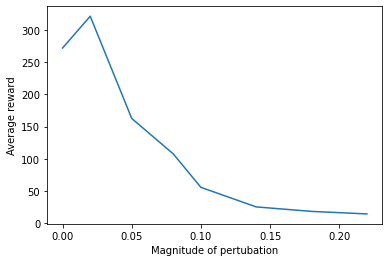

In [8]:
epsilons_attacks = [0,0.02,0.05,0.08,0.10,0.14,0.18,0.22]
plt.figure(1)
plt.plot(epsilons_attacks,average_reward_number_attacked)
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.show()

## Training with adversarial training (only run if you want to train again)

In [9]:
def train_robust(agent_robust, EPSILON_PERT):
    agent_robust.network.train()

    best_reward = 0
    average_reward = 0
    episode_number = []
    average_reward_number = []


    for i in range(1, EPISODES):
        epsilon_pertubated = max(EPSILON_PERT/(EPISODES - 1.5*i), EPSILON_PERT)
        state = env.reset()
        score = 0
        while True:
            pert_state = attack_FGSM(state, epsilon_pertubated, agent_robust)
            action, q_values = agent_robust.choose_action(pert_state)
            state_, reward, done, info = env.step(action)


            agent_robust.memory.add(state, action, reward, state_, done)
            agent_robust.learn()
            state = state_
            score += reward

            if done:
                if score > best_reward:
                    best_reward = score
                average_reward += score
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
                break

            episode_number.append(i)
            average_reward_number.append(average_reward/i)

In [10]:
robust_agent_1 = DQN_Solver()
robust_agent_2 = DQN_Solver()
robust_agent_3 = DQN_Solver()
robust_agent_4 = DQN_Solver()

agents = [[robust_agent_1,0.02],[robust_agent_2, 0.05], [robust_agent_3, 0.08], [robust_agent_4, 0.10]]
for agent, eps in agents:
    print("NOW TRAINING AGENT WITH EPS:", eps)
    train_robust(agent, eps)

/tmp/ipykernel_640/1353702249.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


NOW TRAINING AGENT WITH EPS: 0.02
Episode 1 Average Reward 10.0 Best Reward 10.0 Last Reward 10.0 Epsilon 1.0
Episode 2 Average Reward 13.5 Best Reward 17.0 Last Reward 17.0 Epsilon 1.0
Episode 3 Average Reward 21.0 Best Reward 36.0 Last Reward 36.0 Epsilon 0.9684910757595269
Episode 4 Average Reward 18.25 Best Reward 36.0 Last Reward 10.0 Epsilon 0.9588496310845509
Episode 5 Average Reward 20.6 Best Reward 36.0 Last Reward 30.0 Epsilon 0.9304973749532338
Episode 6 Average Reward 20.666666666666668 Best Reward 36.0 Last Reward 21.0 Epsilon 0.9111511025165902
Episode 7 Average Reward 24.571428571428573 Best Reward 48.0 Last Reward 48.0 Epsilon 0.8684280445126921
Episode 8 Average Reward 23.0 Best Reward 48.0 Last Reward 12.0 Epsilon 0.8580640336044925
Episode 9 Average Reward 23.0 Best Reward 48.0 Last Reward 23.0 Epsilon 0.838544138970058
Episode 10 Average Reward 22.1 Best Reward 48.0 Last Reward 14.0 Epsilon 0.8268805241487632
Episode 11 Average Reward 21.454545454545453 Best Reward 

Episode 81 Average Reward 111.64197530864197 Best Reward 500.0 Last Reward 238.0 Epsilon 0.001
Episode 82 Average Reward 114.45121951219512 Best Reward 500.0 Last Reward 342.0 Epsilon 0.001
Episode 83 Average Reward 117.20481927710843 Best Reward 500.0 Last Reward 343.0 Epsilon 0.001
Episode 84 Average Reward 119.60714285714286 Best Reward 500.0 Last Reward 319.0 Epsilon 0.001
Episode 85 Average Reward 123.02352941176471 Best Reward 500.0 Last Reward 410.0 Epsilon 0.001
Episode 86 Average Reward 127.40697674418605 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 87 Average Reward 130.13793103448276 Best Reward 500.0 Last Reward 365.0 Epsilon 0.001
Episode 88 Average Reward 132.8068181818182 Best Reward 500.0 Last Reward 365.0 Epsilon 0.001
Episode 89 Average Reward 136.93258426966293 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 90 Average Reward 140.96666666666667 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 91 Average Reward 144.9120879120879 Best Re

Episode 168 Average Reward 227.89285714285714 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 169 Average Reward 227.57396449704143 Best Reward 500.0 Last Reward 174.0 Epsilon 0.001
Episode 170 Average Reward 227.89411764705883 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 171 Average Reward 229.48538011695908 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 172 Average Reward 231.0581395348837 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 173 Average Reward 232.61271676300578 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 174 Average Reward 234.1494252873563 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 175 Average Reward 233.0857142857143 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 176 Average Reward 231.86363636363637 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 177 Average Reward 230.6723163841808 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 178 Average Reward 232.18539325842696 B

Episode 255 Average Reward 246.9294117647059 Best Reward 500.0 Last Reward 242.0 Epsilon 0.001
Episode 256 Average Reward 247.3828125 Best Reward 500.0 Last Reward 363.0 Epsilon 0.001
Episode 257 Average Reward 247.38910505836577 Best Reward 500.0 Last Reward 249.0 Epsilon 0.001
Episode 258 Average Reward 247.51162790697674 Best Reward 500.0 Last Reward 279.0 Epsilon 0.001
Episode 259 Average Reward 247.47490347490347 Best Reward 500.0 Last Reward 238.0 Epsilon 0.001
Episode 260 Average Reward 247.6846153846154 Best Reward 500.0 Last Reward 302.0 Epsilon 0.001
Episode 261 Average Reward 247.4022988505747 Best Reward 500.0 Last Reward 174.0 Epsilon 0.001
Episode 262 Average Reward 247.76335877862596 Best Reward 500.0 Last Reward 342.0 Epsilon 0.001
Episode 263 Average Reward 247.92015209125475 Best Reward 500.0 Last Reward 289.0 Epsilon 0.001
Episode 264 Average Reward 248.1969696969697 Best Reward 500.0 Last Reward 321.0 Epsilon 0.001
Episode 265 Average Reward 248.33584905660376 Best 

Episode 342 Average Reward 241.77777777777777 Best Reward 500.0 Last Reward 259.0 Epsilon 0.001
Episode 343 Average Reward 241.71428571428572 Best Reward 500.0 Last Reward 220.0 Epsilon 0.001
Episode 344 Average Reward 241.77616279069767 Best Reward 500.0 Last Reward 263.0 Epsilon 0.001
Episode 345 Average Reward 241.75652173913045 Best Reward 500.0 Last Reward 235.0 Epsilon 0.001
Episode 346 Average Reward 241.72254335260115 Best Reward 500.0 Last Reward 230.0 Epsilon 0.001
Episode 347 Average Reward 241.59942363112393 Best Reward 500.0 Last Reward 199.0 Epsilon 0.001
Episode 348 Average Reward 241.83045977011494 Best Reward 500.0 Last Reward 322.0 Epsilon 0.001
Episode 349 Average Reward 241.87106017191977 Best Reward 500.0 Last Reward 256.0 Epsilon 0.001
Episode 350 Average Reward 241.82285714285715 Best Reward 500.0 Last Reward 225.0 Epsilon 0.001
Episode 351 Average Reward 241.76638176638176 Best Reward 500.0 Last Reward 222.0 Epsilon 0.001
Episode 352 Average Reward 241.772727272

Episode 428 Average Reward 243.08878504672896 Best Reward 500.0 Last Reward 360.0 Epsilon 0.001
Episode 429 Average Reward 243.2051282051282 Best Reward 500.0 Last Reward 293.0 Epsilon 0.001
Episode 430 Average Reward 243.2813953488372 Best Reward 500.0 Last Reward 276.0 Epsilon 0.001
Episode 431 Average Reward 243.4663573085847 Best Reward 500.0 Last Reward 323.0 Epsilon 0.001
Episode 432 Average Reward 243.78935185185185 Best Reward 500.0 Last Reward 383.0 Epsilon 0.001
Episode 433 Average Reward 244.08545034642032 Best Reward 500.0 Last Reward 372.0 Epsilon 0.001
Episode 434 Average Reward 244.32718894009216 Best Reward 500.0 Last Reward 349.0 Epsilon 0.001
Episode 435 Average Reward 244.60459770114943 Best Reward 500.0 Last Reward 365.0 Epsilon 0.001
Episode 436 Average Reward 245.0091743119266 Best Reward 500.0 Last Reward 421.0 Epsilon 0.001
Episode 437 Average Reward 245.02974828375287 Best Reward 500.0 Last Reward 254.0 Epsilon 0.001
Episode 438 Average Reward 245.0639269406392

Episode 514 Average Reward 250.88910505836577 Best Reward 500.0 Last Reward 204.0 Epsilon 0.001
Episode 515 Average Reward 250.8757281553398 Best Reward 500.0 Last Reward 244.0 Epsilon 0.001
Episode 516 Average Reward 250.88178294573643 Best Reward 500.0 Last Reward 254.0 Epsilon 0.001
Episode 517 Average Reward 250.81431334622823 Best Reward 500.0 Last Reward 216.0 Epsilon 0.001
Episode 518 Average Reward 250.8050193050193 Best Reward 500.0 Last Reward 246.0 Epsilon 0.001
Episode 519 Average Reward 250.6917148362235 Best Reward 500.0 Last Reward 192.0 Epsilon 0.001
Episode 520 Average Reward 250.78846153846155 Best Reward 500.0 Last Reward 301.0 Epsilon 0.001
Episode 521 Average Reward 250.72360844529751 Best Reward 500.0 Last Reward 217.0 Epsilon 0.001
Episode 522 Average Reward 250.6551724137931 Best Reward 500.0 Last Reward 215.0 Epsilon 0.001
Episode 523 Average Reward 250.62332695984705 Best Reward 500.0 Last Reward 234.0 Epsilon 0.001
Episode 524 Average Reward 250.5343511450381

Episode 601 Average Reward 248.3377703826955 Best Reward 500.0 Last Reward 205.0 Epsilon 0.001
Episode 602 Average Reward 248.54651162790697 Best Reward 500.0 Last Reward 374.0 Epsilon 0.001
Episode 603 Average Reward 248.96351575456052 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 604 Average Reward 249.2019867549669 Best Reward 500.0 Last Reward 393.0 Epsilon 0.001
Episode 605 Average Reward 249.00330578512396 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 606 Average Reward 249.11881188118812 Best Reward 500.0 Last Reward 319.0 Epsilon 0.001
Episode 607 Average Reward 249.21416803953872 Best Reward 500.0 Last Reward 307.0 Epsilon 0.001
Episode 608 Average Reward 249.6266447368421 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 609 Average Reward 249.44334975369458 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 610 Average Reward 249.3655737704918 Best Reward 500.0 Last Reward 202.0 Epsilon 0.001
Episode 611 Average Reward 249.2209492635024

Episode 687 Average Reward 260.21542940320234 Best Reward 500.0 Last Reward 212.0 Epsilon 0.001
Episode 688 Average Reward 260.32267441860466 Best Reward 500.0 Last Reward 334.0 Epsilon 0.001
Episode 689 Average Reward 260.1857764876633 Best Reward 500.0 Last Reward 166.0 Epsilon 0.001
Episode 690 Average Reward 260.2260869565217 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 691 Average Reward 260.21418234442837 Best Reward 500.0 Last Reward 252.0 Epsilon 0.001
Episode 692 Average Reward 260.1315028901734 Best Reward 500.0 Last Reward 203.0 Epsilon 0.001
Episode 693 Average Reward 260.1082251082251 Best Reward 500.0 Last Reward 244.0 Epsilon 0.001
Episode 694 Average Reward 260.21757925072046 Best Reward 500.0 Last Reward 336.0 Epsilon 0.001
Episode 695 Average Reward 260.29928057553957 Best Reward 500.0 Last Reward 317.0 Epsilon 0.001
Episode 696 Average Reward 260.4037356321839 Best Reward 500.0 Last Reward 333.0 Epsilon 0.001
Episode 697 Average Reward 260.38020086083213

Episode 774 Average Reward 268.3617571059431 Best Reward 500.0 Last Reward 376.0 Epsilon 0.001
Episode 775 Average Reward 268.2567741935484 Best Reward 500.0 Last Reward 187.0 Epsilon 0.001
Episode 776 Average Reward 268.0863402061856 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 777 Average Reward 268.2316602316602 Best Reward 500.0 Last Reward 381.0 Epsilon 0.001
Episode 778 Average Reward 268.19537275064266 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 779 Average Reward 268.1078305519897 Best Reward 500.0 Last Reward 200.0 Epsilon 0.001
Episode 780 Average Reward 268.1820512820513 Best Reward 500.0 Last Reward 326.0 Epsilon 0.001
Episode 781 Average Reward 268.16773367477595 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 782 Average Reward 268.22890025575447 Best Reward 500.0 Last Reward 316.0 Epsilon 0.001
Episode 783 Average Reward 268.1570881226054 Best Reward 500.0 Last Reward 212.0 Epsilon 0.001
Episode 784 Average Reward 268.40816326530614 B

Episode 861 Average Reward 275.4123112659698 Best Reward 500.0 Last Reward 193.0 Epsilon 0.001
Episode 862 Average Reward 275.67285382830624 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 863 Average Reward 275.9327925840093 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 864 Average Reward 275.92824074074076 Best Reward 500.0 Last Reward 272.0 Epsilon 0.001
Episode 865 Average Reward 276.18728323699423 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 866 Average Reward 276.445727482679 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 867 Average Reward 276.6228373702422 Best Reward 500.0 Last Reward 430.0 Epsilon 0.001
Episode 868 Average Reward 276.44700460829495 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 869 Average Reward 276.7042577675489 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 870 Average Reward 276.7367816091954 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 871 Average Reward 276.99311136624567 B

Episode 947 Average Reward 282.1129883843717 Best Reward 500.0 Last Reward 193.0 Epsilon 0.001
Episode 948 Average Reward 282.2679324894515 Best Reward 500.0 Last Reward 429.0 Epsilon 0.001
Episode 949 Average Reward 282.19283456269756 Best Reward 500.0 Last Reward 211.0 Epsilon 0.001
Episode 950 Average Reward 282.2863157894737 Best Reward 500.0 Last Reward 371.0 Epsilon 0.001
Episode 951 Average Reward 282.51524710830705 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 952 Average Reward 282.4075630252101 Best Reward 500.0 Last Reward 180.0 Epsilon 0.001
Episode 953 Average Reward 282.5120671563484 Best Reward 500.0 Last Reward 382.0 Epsilon 0.001
Episode 954 Average Reward 282.6184486373166 Best Reward 500.0 Last Reward 384.0 Epsilon 0.001
Episode 955 Average Reward 282.79685863874346 Best Reward 500.0 Last Reward 453.0 Epsilon 0.001
Episode 956 Average Reward 282.85146443514645 Best Reward 500.0 Last Reward 335.0 Epsilon 0.001
Episode 957 Average Reward 282.8349007314525 B

Episode 33 Average Reward 20.454545454545453 Best Reward 41.0 Last Reward 20.0 Epsilon 0.5250182711383566
Episode 34 Average Reward 20.176470588235293 Best Reward 41.0 Last Reward 11.0 Epsilon 0.5192718597057463
Episode 35 Average Reward 20.0 Best Reward 41.0 Last Reward 14.0 Epsilon 0.5120491189128954
Episode 36 Average Reward 20.0 Best Reward 41.0 Last Reward 20.0 Epsilon 0.5019048446041944
Episode 37 Average Reward 19.675675675675677 Best Reward 41.0 Last Reward 8.0 Epsilon 0.4979036311114436
Episode 38 Average Reward 19.657894736842106 Best Reward 41.0 Last Reward 19.0 Epsilon 0.4885281230967259
Episode 39 Average Reward 19.384615384615383 Best Reward 41.0 Last Reward 9.0 Epsilon 0.4841489160264175
Episode 40 Average Reward 19.125 Best Reward 41.0 Last Reward 9.0 Epsilon 0.47980896453558947
Episode 41 Average Reward 18.926829268292682 Best Reward 41.0 Last Reward 11.0 Epsilon 0.47455737640838375
Episode 42 Average Reward 18.666666666666668 Best Reward 41.0 Last Reward 8.0 Epsilon 0

Episode 114 Average Reward 124.43859649122807 Best Reward 500.0 Last Reward 450.0 Epsilon 0.001
Episode 115 Average Reward 126.00869565217391 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 116 Average Reward 126.71551724137932 Best Reward 500.0 Last Reward 208.0 Epsilon 0.001
Episode 117 Average Reward 127.83760683760684 Best Reward 500.0 Last Reward 258.0 Epsilon 0.001
Episode 118 Average Reward 128.8728813559322 Best Reward 500.0 Last Reward 250.0 Epsilon 0.001
Episode 119 Average Reward 130.1596638655462 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 120 Average Reward 130.06666666666666 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 121 Average Reward 131.0495867768595 Best Reward 500.0 Last Reward 249.0 Epsilon 0.001
Episode 122 Average Reward 134.0737704918033 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 123 Average Reward 135.65853658536585 Best Reward 500.0 Last Reward 329.0 Epsilon 0.001
Episode 124 Average Reward 136.7661290322580

Episode 201 Average Reward 198.76616915422886 Best Reward 500.0 Last Reward 227.0 Epsilon 0.001
Episode 202 Average Reward 200.12871287128712 Best Reward 500.0 Last Reward 474.0 Epsilon 0.001
Episode 203 Average Reward 200.91625615763547 Best Reward 500.0 Last Reward 360.0 Epsilon 0.001
Episode 204 Average Reward 201.2107843137255 Best Reward 500.0 Last Reward 261.0 Epsilon 0.001
Episode 205 Average Reward 201.1219512195122 Best Reward 500.0 Last Reward 183.0 Epsilon 0.001
Episode 206 Average Reward 200.8009708737864 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 207 Average Reward 200.42512077294685 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 208 Average Reward 200.73076923076923 Best Reward 500.0 Last Reward 264.0 Epsilon 0.001
Episode 209 Average Reward 200.5693779904306 Best Reward 500.0 Last Reward 167.0 Epsilon 0.001
Episode 210 Average Reward 200.73333333333332 Best Reward 500.0 Last Reward 235.0 Epsilon 0.001
Episode 211 Average Reward 200.7203791469194

Episode 291 Average Reward 185.2164948453608 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 292 Average Reward 184.6164383561644 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 293 Average Reward 184.03412969283278 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 294 Average Reward 183.843537414966 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 295 Average Reward 183.69152542372882 Best Reward 500.0 Last Reward 139.0 Epsilon 0.001
Episode 296 Average Reward 183.82432432432432 Best Reward 500.0 Last Reward 223.0 Epsilon 0.001
Episode 297 Average Reward 183.85521885521885 Best Reward 500.0 Last Reward 193.0 Epsilon 0.001
Episode 298 Average Reward 183.61073825503357 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 299 Average Reward 183.76254180602007 Best Reward 500.0 Last Reward 229.0 Epsilon 0.001
Episode 300 Average Reward 183.67333333333335 Best Reward 500.0 Last Reward 157.0 Epsilon 0.001
Episode 301 Average Reward 183.99335548172758 B

Episode 378 Average Reward 180.1851851851852 Best Reward 500.0 Last Reward 277.0 Epsilon 0.001
Episode 379 Average Reward 180.31398416886543 Best Reward 500.0 Last Reward 229.0 Epsilon 0.001
Episode 380 Average Reward 180.17105263157896 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 381 Average Reward 180.28083989501312 Best Reward 500.0 Last Reward 222.0 Epsilon 0.001
Episode 382 Average Reward 180.15183246073298 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 383 Average Reward 180.01044386422976 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 384 Average Reward 180.171875 Best Reward 500.0 Last Reward 242.0 Epsilon 0.001
Episode 385 Average Reward 180.00779220779222 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 386 Average Reward 179.61658031088083 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 387 Average Reward 179.1782945736434 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 388 Average Reward 178.7422680412371 Best Re

Episode 466 Average Reward 173.42060085836908 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 467 Average Reward 173.07066381156318 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 468 Average Reward 172.72222222222223 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 469 Average Reward 172.37313432835822 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 470 Average Reward 172.0255319148936 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 471 Average Reward 171.67940552016987 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 472 Average Reward 171.33474576271186 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 473 Average Reward 170.99154334038056 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 474 Average Reward 170.64978902953587 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 475 Average Reward 170.30947368421053 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 476 Average Reward 169.9768907563025 Best Reward 50

Episode 553 Average Reward 170.63291139240508 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 554 Average Reward 170.54693140794222 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 555 Average Reward 170.47747747747746 Best Reward 500.0 Last Reward 132.0 Epsilon 0.001
Episode 556 Average Reward 170.3974820143885 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 557 Average Reward 170.3339317773788 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 558 Average Reward 170.29928315412187 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 559 Average Reward 170.18962432915922 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 560 Average Reward 170.18571428571428 Best Reward 500.0 Last Reward 168.0 Epsilon 0.001
Episode 561 Average Reward 170.31729055258467 Best Reward 500.0 Last Reward 244.0 Epsilon 0.001
Episode 562 Average Reward 170.27758007117438 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 563 Average Reward 170.25577264653

Episode 639 Average Reward 168.1752738654147 Best Reward 500.0 Last Reward 146.0 Epsilon 0.001
Episode 640 Average Reward 168.5171875 Best Reward 500.0 Last Reward 387.0 Epsilon 0.001
Episode 641 Average Reward 168.42589703588143 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 642 Average Reward 168.9423676012461 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 643 Average Reward 168.84603421461898 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 644 Average Reward 168.86024844720498 Best Reward 500.0 Last Reward 178.0 Epsilon 0.001
Episode 645 Average Reward 168.7984496124031 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 646 Average Reward 168.77708978328172 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 647 Average Reward 168.5548686244204 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 648 Average Reward 168.86574074074073 Best Reward 500.0 Last Reward 370.0 Epsilon 0.001
Episode 649 Average Reward 168.76425269645608 Best R

Episode 725 Average Reward 168.91724137931035 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 726 Average Reward 168.72451790633608 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 727 Average Reward 168.7977991746905 Best Reward 500.0 Last Reward 222.0 Epsilon 0.001
Episode 728 Average Reward 168.69642857142858 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 729 Average Reward 168.79835390946502 Best Reward 500.0 Last Reward 243.0 Epsilon 0.001
Episode 730 Average Reward 168.7068493150685 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 731 Average Reward 168.61012311901504 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 732 Average Reward 168.48497267759564 Best Reward 500.0 Last Reward 77.0 Epsilon 0.001
Episode 733 Average Reward 168.60982264665756 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 734 Average Reward 168.74386920980928 Best Reward 500.0 Last Reward 267.0 Epsilon 0.001
Episode 735 Average Reward 168.64625850340136 

Episode 812 Average Reward 168.29679802955664 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 813 Average Reward 168.40590405904058 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 814 Average Reward 168.35257985257985 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 815 Average Reward 168.64785276073619 Best Reward 500.0 Last Reward 409.0 Epsilon 0.001
Episode 816 Average Reward 168.61029411764707 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 817 Average Reward 168.92044063647492 Best Reward 500.0 Last Reward 422.0 Epsilon 0.001
Episode 818 Average Reward 168.87408312958436 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 819 Average Reward 169.17826617826617 Best Reward 500.0 Last Reward 418.0 Epsilon 0.001
Episode 820 Average Reward 169.140243902439 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 821 Average Reward 169.07673568818515 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 822 Average Reward 169.01216545012

Episode 898 Average Reward 165.9064587973274 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 899 Average Reward 165.9265850945495 Best Reward 500.0 Last Reward 184.0 Epsilon 0.001
Episode 900 Average Reward 165.86777777777777 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 901 Average Reward 165.97225305216426 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 902 Average Reward 165.89135254988915 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 903 Average Reward 165.76633444075304 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 904 Average Reward 165.77986725663717 Best Reward 500.0 Last Reward 178.0 Epsilon 0.001
Episode 905 Average Reward 165.9403314917127 Best Reward 500.0 Last Reward 311.0 Epsilon 0.001
Episode 906 Average Reward 165.8896247240618 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 907 Average Reward 165.85115766262405 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 908 Average Reward 165.81387665198238 

Episode 984 Average Reward 163.45426829268294 Best Reward 500.0 Last Reward 130.0 Epsilon 0.001
Episode 985 Average Reward 163.39390862944163 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 986 Average Reward 163.3793103448276 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 987 Average Reward 163.37791286727457 Best Reward 500.0 Last Reward 162.0 Epsilon 0.001
Episode 988 Average Reward 163.32995951417004 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 989 Average Reward 163.29929221435793 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 990 Average Reward 163.25959595959597 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 991 Average Reward 163.2068617558022 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 992 Average Reward 163.15826612903226 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 993 Average Reward 163.0946626384693 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 994 Average Reward 163.037223340040

Episode 67 Average Reward 51.76119402985075 Best Reward 178.0 Last Reward 89.0 Epsilon 0.03210576575221366
Episode 68 Average Reward 52.205882352941174 Best Reward 178.0 Last Reward 82.0 Epsilon 0.029576928211995545
Episode 69 Average Reward 52.56521739130435 Best Reward 178.0 Last Reward 77.0 Epsilon 0.02738392272760552
Episode 70 Average Reward 53.714285714285715 Best Reward 178.0 Last Reward 133.0 Epsilon 0.02397207317351981
Episode 71 Average Reward 54.647887323943664 Best Reward 178.0 Last Reward 120.0 Epsilon 0.021260045116006834
Episode 72 Average Reward 56.0 Best Reward 178.0 Last Reward 152.0 Epsilon 0.018260740807661956
Episode 73 Average Reward 57.16438356164384 Best Reward 178.0 Last Reward 141.0 Epsilon 0.015858139430950966
Episode 74 Average Reward 58.58108108108108 Best Reward 178.0 Last Reward 162.0 Epsilon 0.01348532211528074
Episode 75 Average Reward 59.61333333333334 Best Reward 178.0 Last Reward 136.0 Epsilon 0.011769763149954076
Episode 76 Average Reward 60.4342105

Episode 151 Average Reward 110.56291390728477 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 152 Average Reward 110.64473684210526 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 153 Average Reward 110.58169934640523 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 154 Average Reward 110.64285714285714 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 155 Average Reward 110.65161290322581 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 156 Average Reward 110.67948717948718 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 157 Average Reward 110.73248407643312 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 158 Average Reward 110.72151898734177 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 159 Average Reward 110.69811320754717 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 160 Average Reward 110.6125 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 161 Average Reward 110.62111801242236 Best 

Episode 238 Average Reward 105.4873949579832 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 239 Average Reward 105.4602510460251 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 240 Average Reward 105.4625 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 241 Average Reward 105.43153526970954 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 242 Average Reward 105.42561983471074 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 243 Average Reward 105.4156378600823 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 244 Average Reward 105.31557377049181 Best Reward 500.0 Last Reward 81.0 Epsilon 0.001
Episode 245 Average Reward 105.31428571428572 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 246 Average Reward 105.34146341463415 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 247 Average Reward 105.31983805668017 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 248 Average Reward 105.0241935483871 Best Reward

Episode 326 Average Reward 100.86196319018404 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 327 Average Reward 100.70336391437309 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 328 Average Reward 100.47865853658537 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 329 Average Reward 100.46504559270517 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 330 Average Reward 100.4939393939394 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 331 Average Reward 100.48942598187311 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 332 Average Reward 100.4066265060241 Best Reward 500.0 Last Reward 73.0 Epsilon 0.001
Episode 333 Average Reward 100.27027027027027 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 334 Average Reward 100.1497005988024 Best Reward 500.0 Last Reward 60.0 Epsilon 0.001
Episode 335 Average Reward 99.97014925373135 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 336 Average Reward 99.86309523809524 Best Rew

Episode 414 Average Reward 96.83333333333333 Best Reward 500.0 Last Reward 56.0 Epsilon 0.001
Episode 415 Average Reward 96.64096385542169 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 416 Average Reward 96.64903846153847 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 417 Average Reward 96.6642685851319 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 418 Average Reward 96.66746411483254 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 419 Average Reward 96.68973747016706 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 420 Average Reward 96.6952380952381 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 421 Average Reward 96.69121140142518 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 422 Average Reward 96.70616113744076 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 423 Average Reward 96.76359338061465 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 424 Average Reward 96.75 Best Reward 500.0 Last R

Episode 503 Average Reward 93.65606361829026 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 504 Average Reward 93.51190476190476 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 505 Average Reward 93.51089108910891 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 506 Average Reward 93.41304347826087 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 507 Average Reward 93.31952662721893 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 508 Average Reward 93.21259842519684 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 509 Average Reward 93.2180746561886 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 510 Average Reward 93.09803921568627 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 511 Average Reward 93.0958904109589 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 512 Average Reward 92.970703125 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 513 Average Reward 93.01364522417154 Best Reward 500.0 Last

Episode 592 Average Reward 89.88175675675676 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 593 Average Reward 89.88026981450253 Best Reward 500.0 Last Reward 89.0 Epsilon 0.001
Episode 594 Average Reward 89.88888888888889 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 595 Average Reward 89.90252100840335 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 596 Average Reward 89.81879194630872 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 597 Average Reward 89.82747068676717 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 598 Average Reward 89.74581939799332 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 599 Average Reward 89.68781302170284 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 600 Average Reward 89.62833333333333 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 601 Average Reward 89.53743760399334 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 602 Average Reward 89.46843853820597 Best Reward 500

Episode 680 Average Reward 87.87352941176471 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 681 Average Reward 87.94273127753304 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 682 Average Reward 87.96627565982405 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 683 Average Reward 87.99414348462665 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 684 Average Reward 88.03070175438596 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 685 Average Reward 88.05839416058394 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 686 Average Reward 88.07288629737609 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 687 Average Reward 88.17030567685589 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 688 Average Reward 88.2063953488372 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 689 Average Reward 88.24238026124819 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 690 Average Reward 88.28840579710145 Best Re

Episode 768 Average Reward 87.18880208333333 Best Reward 500.0 Last Reward 74.0 Epsilon 0.001
Episode 769 Average Reward 87.21716514954487 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 770 Average Reward 87.22077922077922 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 771 Average Reward 87.14267185473412 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 772 Average Reward 87.08678756476684 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 773 Average Reward 87.00388098318241 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 774 Average Reward 87.02325581395348 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 775 Average Reward 87.04903225806451 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 776 Average Reward 87.03479381443299 Best Reward 500.0 Last Reward 76.0 Epsilon 0.001
Episode 777 Average Reward 86.98198198198199 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 778 Average Reward 86.95372750642673 Best Reward 

Episode 856 Average Reward 84.36799065420561 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 857 Average Reward 84.30221703617269 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 858 Average Reward 84.22843822843822 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 859 Average Reward 84.15366705471479 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 860 Average Reward 84.07906976744187 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 861 Average Reward 84.0267131242741 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 862 Average Reward 83.95823665893272 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 863 Average Reward 83.97103128621089 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 864 Average Reward 83.99421296296296 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 865 Average Reward 83.94335260115606 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 866 Average Reward 83.92032332563511 Best Reward 500

Episode 944 Average Reward 83.32733050847457 Best Reward 500.0 Last Reward 56.0 Epsilon 0.001
Episode 945 Average Reward 83.28677248677249 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 946 Average Reward 83.32241014799155 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 947 Average Reward 83.29883843717 Best Reward 500.0 Last Reward 61.0 Epsilon 0.001
Episode 948 Average Reward 83.25949367088607 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 949 Average Reward 83.20547945205479 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 950 Average Reward 83.1621052631579 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 951 Average Reward 83.10515247108307 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 952 Average Reward 83.05672268907563 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 953 Average Reward 83.04616998950682 Best Reward 500.0 Last Reward 73.0 Epsilon 0.001
Episode 954 Average Reward 83.06394129979036 Best Reward 500.0 

Episode 32 Average Reward 32.6875 Best Reward 144.0 Last Reward 144.0 Epsilon 0.3622184346183837
Episode 33 Average Reward 32.90909090909091 Best Reward 144.0 Last Reward 40.0 Epsilon 0.3480086817607007
Episode 34 Average Reward 34.529411764705884 Best Reward 144.0 Last Reward 88.0 Epsilon 0.31867870398971
Episode 35 Average Reward 34.65714285714286 Best Reward 144.0 Last Reward 39.0 Epsilon 0.3064834890782873
Episode 36 Average Reward 34.416666666666664 Best Reward 144.0 Last Reward 26.0 Epsilon 0.2986137332009687
Episode 37 Average Reward 35.432432432432435 Best Reward 144.0 Last Reward 72.0 Epsilon 0.27785929486848676
Episode 38 Average Reward 36.39473684210526 Best Reward 144.0 Last Reward 72.0 Epsilon 0.2585473444814836
Episode 39 Average Reward 37.53846153846154 Best Reward 144.0 Last Reward 81.0 Epsilon 0.23842106732935378
Episode 40 Average Reward 38.625 Best Reward 144.0 Last Reward 81.0 Epsilon 0.2198614936868526
Episode 41 Average Reward 42.53658536585366 Best Reward 199.0 L

Episode 112 Average Reward 85.75892857142857 Best Reward 215.0 Last Reward 100.0 Epsilon 0.001
Episode 113 Average Reward 86.02654867256638 Best Reward 215.0 Last Reward 116.0 Epsilon 0.001
Episode 114 Average Reward 86.30701754385964 Best Reward 215.0 Last Reward 118.0 Epsilon 0.001
Episode 115 Average Reward 86.52173913043478 Best Reward 215.0 Last Reward 111.0 Epsilon 0.001
Episode 116 Average Reward 86.9396551724138 Best Reward 215.0 Last Reward 135.0 Epsilon 0.001
Episode 117 Average Reward 87.24786324786325 Best Reward 215.0 Last Reward 123.0 Epsilon 0.001
Episode 118 Average Reward 87.38983050847457 Best Reward 215.0 Last Reward 104.0 Epsilon 0.001
Episode 119 Average Reward 87.57142857142857 Best Reward 215.0 Last Reward 109.0 Epsilon 0.001
Episode 120 Average Reward 88.01666666666667 Best Reward 215.0 Last Reward 141.0 Epsilon 0.001
Episode 121 Average Reward 88.27272727272727 Best Reward 215.0 Last Reward 119.0 Epsilon 0.001
Episode 122 Average Reward 88.35245901639344 Best R

Episode 200 Average Reward 86.735 Best Reward 232.0 Last Reward 63.0 Epsilon 0.001
Episode 201 Average Reward 86.91044776119404 Best Reward 232.0 Last Reward 122.0 Epsilon 0.001
Episode 202 Average Reward 86.98019801980197 Best Reward 232.0 Last Reward 101.0 Epsilon 0.001
Episode 203 Average Reward 87.0295566502463 Best Reward 232.0 Last Reward 97.0 Epsilon 0.001
Episode 204 Average Reward 86.92156862745098 Best Reward 232.0 Last Reward 65.0 Epsilon 0.001
Episode 205 Average Reward 86.77073170731707 Best Reward 232.0 Last Reward 56.0 Epsilon 0.001
Episode 206 Average Reward 86.73300970873787 Best Reward 232.0 Last Reward 79.0 Epsilon 0.001
Episode 207 Average Reward 86.90821256038647 Best Reward 232.0 Last Reward 123.0 Epsilon 0.001
Episode 208 Average Reward 86.96153846153847 Best Reward 232.0 Last Reward 98.0 Epsilon 0.001
Episode 209 Average Reward 86.8755980861244 Best Reward 232.0 Last Reward 69.0 Epsilon 0.001
Episode 210 Average Reward 86.93809523809524 Best Reward 232.0 Last Re

Episode 288 Average Reward 92.38194444444444 Best Reward 234.0 Last Reward 103.0 Epsilon 0.001
Episode 289 Average Reward 92.48442906574394 Best Reward 234.0 Last Reward 122.0 Epsilon 0.001
Episode 290 Average Reward 92.63103448275862 Best Reward 234.0 Last Reward 135.0 Epsilon 0.001
Episode 291 Average Reward 92.70446735395188 Best Reward 234.0 Last Reward 114.0 Epsilon 0.001
Episode 292 Average Reward 92.72602739726027 Best Reward 234.0 Last Reward 99.0 Epsilon 0.001
Episode 293 Average Reward 92.77474402730375 Best Reward 234.0 Last Reward 107.0 Epsilon 0.001
Episode 294 Average Reward 92.5374149659864 Best Reward 234.0 Last Reward 23.0 Epsilon 0.001
Episode 295 Average Reward 92.45423728813559 Best Reward 234.0 Last Reward 68.0 Epsilon 0.001
Episode 296 Average Reward 92.54729729729729 Best Reward 234.0 Last Reward 120.0 Epsilon 0.001
Episode 297 Average Reward 92.93939393939394 Best Reward 234.0 Last Reward 209.0 Epsilon 0.001
Episode 298 Average Reward 93.23154362416108 Best Rewa

Episode 377 Average Reward 93.026525198939 Best Reward 352.0 Last Reward 108.0 Epsilon 0.001
Episode 378 Average Reward 93.01851851851852 Best Reward 352.0 Last Reward 90.0 Epsilon 0.001
Episode 379 Average Reward 93.03166226912928 Best Reward 352.0 Last Reward 98.0 Epsilon 0.001
Episode 380 Average Reward 93.12368421052632 Best Reward 352.0 Last Reward 128.0 Epsilon 0.001
Episode 381 Average Reward 93.13910761154855 Best Reward 352.0 Last Reward 99.0 Epsilon 0.001
Episode 382 Average Reward 93.15706806282722 Best Reward 352.0 Last Reward 100.0 Epsilon 0.001
Episode 383 Average Reward 93.0313315926893 Best Reward 352.0 Last Reward 45.0 Epsilon 0.001
Episode 384 Average Reward 93.00520833333333 Best Reward 352.0 Last Reward 83.0 Epsilon 0.001
Episode 385 Average Reward 92.87792207792208 Best Reward 352.0 Last Reward 44.0 Epsilon 0.001
Episode 386 Average Reward 92.90673575129534 Best Reward 352.0 Last Reward 104.0 Epsilon 0.001
Episode 387 Average Reward 93.16020671834626 Best Reward 35

Episode 465 Average Reward 93.4752688172043 Best Reward 352.0 Last Reward 18.0 Epsilon 0.001
Episode 466 Average Reward 93.48068669527898 Best Reward 352.0 Last Reward 96.0 Epsilon 0.001
Episode 467 Average Reward 93.36402569593147 Best Reward 352.0 Last Reward 39.0 Epsilon 0.001
Episode 468 Average Reward 93.24358974358974 Best Reward 352.0 Last Reward 37.0 Epsilon 0.001
Episode 469 Average Reward 93.2409381663113 Best Reward 352.0 Last Reward 92.0 Epsilon 0.001
Episode 470 Average Reward 93.1404255319149 Best Reward 352.0 Last Reward 46.0 Epsilon 0.001
Episode 471 Average Reward 93.18259023354565 Best Reward 352.0 Last Reward 113.0 Epsilon 0.001
Episode 472 Average Reward 93.83050847457628 Best Reward 399.0 Last Reward 399.0 Epsilon 0.001
Episode 473 Average Reward 93.87315010570825 Best Reward 399.0 Last Reward 114.0 Epsilon 0.001
Episode 474 Average Reward 93.88396624472574 Best Reward 399.0 Last Reward 99.0 Epsilon 0.001
Episode 475 Average Reward 93.76842105263158 Best Reward 399

Episode 553 Average Reward 91.58047016274864 Best Reward 401.0 Last Reward 165.0 Epsilon 0.001
Episode 554 Average Reward 92.05776173285199 Best Reward 401.0 Last Reward 356.0 Epsilon 0.001
Episode 555 Average Reward 92.7927927927928 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 556 Average Reward 93.08453237410072 Best Reward 500.0 Last Reward 255.0 Epsilon 0.001
Episode 557 Average Reward 93.81508078994614 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 558 Average Reward 94.54301075268818 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 559 Average Reward 95.26833631484794 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 560 Average Reward 95.79464285714286 Best Reward 500.0 Last Reward 390.0 Epsilon 0.001
Episode 561 Average Reward 96.49910873440285 Best Reward 500.0 Last Reward 491.0 Epsilon 0.001
Episode 562 Average Reward 97.2170818505338 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 563 Average Reward 97.93250444049734 Best Re

Episode 640 Average Reward 105.6390625 Best Reward 500.0 Last Reward 73.0 Epsilon 0.001
Episode 641 Average Reward 105.6411856474259 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 642 Average Reward 105.59968847352025 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 643 Average Reward 105.61430793157076 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 644 Average Reward 105.58229813664596 Best Reward 500.0 Last Reward 85.0 Epsilon 0.001
Episode 645 Average Reward 105.53023255813953 Best Reward 500.0 Last Reward 72.0 Epsilon 0.001
Episode 646 Average Reward 105.49226006191951 Best Reward 500.0 Last Reward 81.0 Epsilon 0.001
Episode 647 Average Reward 105.40340030911901 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 648 Average Reward 105.33333333333333 Best Reward 500.0 Last Reward 60.0 Epsilon 0.001
Episode 649 Average Reward 105.2788906009245 Best Reward 500.0 Last Reward 70.0 Epsilon 0.001
Episode 650 Average Reward 105.20307692307692 Best Reward

Episode 727 Average Reward 104.55020632737276 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 728 Average Reward 104.47802197802197 Best Reward 500.0 Last Reward 52.0 Epsilon 0.001
Episode 729 Average Reward 104.40603566529492 Best Reward 500.0 Last Reward 52.0 Epsilon 0.001
Episode 730 Average Reward 104.32465753424657 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 731 Average Reward 104.20930232558139 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 732 Average Reward 104.14207650273224 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 733 Average Reward 104.07094133697134 Best Reward 500.0 Last Reward 52.0 Epsilon 0.001
Episode 734 Average Reward 103.96457765667574 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 735 Average Reward 103.89795918367346 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 736 Average Reward 103.80842391304348 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 737 Average Reward 103.73405698778834 Best

Episode 814 Average Reward 99.995085995086 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 815 Average Reward 99.97914110429448 Best Reward 500.0 Last Reward 87.0 Epsilon 0.001
Episode 816 Average Reward 99.93504901960785 Best Reward 500.0 Last Reward 64.0 Epsilon 0.001
Episode 817 Average Reward 99.9485924112607 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 818 Average Reward 100.03056234718827 Best Reward 500.0 Last Reward 167.0 Epsilon 0.001
Episode 819 Average Reward 100.04884004884005 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 820 Average Reward 100.01951219512195 Best Reward 500.0 Last Reward 76.0 Epsilon 0.001
Episode 821 Average Reward 100.05115712545675 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 822 Average Reward 100.0705596107056 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 823 Average Reward 100.04617253948967 Best Reward 500.0 Last Reward 80.0 Epsilon 0.001
Episode 824 Average Reward 100.04368932038835 Best R

Episode 902 Average Reward 98.01773835920177 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 903 Average Reward 98.03543743078627 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 904 Average Reward 98.01548672566372 Best Reward 500.0 Last Reward 80.0 Epsilon 0.001
Episode 905 Average Reward 98.06298342541436 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 906 Average Reward 98.06512141280353 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 907 Average Reward 98.02425578831313 Best Reward 500.0 Last Reward 61.0 Epsilon 0.001
Episode 908 Average Reward 97.99779735682819 Best Reward 500.0 Last Reward 74.0 Epsilon 0.001
Episode 909 Average Reward 97.93069306930693 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 910 Average Reward 97.9021978021978 Best Reward 500.0 Last Reward 72.0 Epsilon 0.001
Episode 911 Average Reward 97.86827661909989 Best Reward 500.0 Last Reward 67.0 Epsilon 0.001
Episode 912 Average Reward 97.84210526315789 Best Reward 

Episode 989 Average Reward 98.31041456016177 Best Reward 500.0 Last Reward 81.0 Epsilon 0.001
Episode 990 Average Reward 98.24444444444444 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 991 Average Reward 98.28557013118062 Best Reward 500.0 Last Reward 139.0 Epsilon 0.001
Episode 992 Average Reward 98.24798387096774 Best Reward 500.0 Last Reward 61.0 Epsilon 0.001
Episode 993 Average Reward 98.19436052366567 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 994 Average Reward 98.18812877263582 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 995 Average Reward 98.20402010050252 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 996 Average Reward 98.1706827309237 Best Reward 500.0 Last Reward 65.0 Epsilon 0.001
Episode 997 Average Reward 98.15346038114343 Best Reward 500.0 Last Reward 81.0 Epsilon 0.001
Episode 998 Average Reward 98.11723446893788 Best Reward 500.0 Last Reward 62.0 Epsilon 0.001
Episode 999 Average Reward 98.10110110110111 Best Reward 50

In [11]:
torch.save(robust_agent_1, "robust_trained_DQN1.pth")
torch.save(robust_agent_2, "robust_trained_DQN2.pth")
torch.save(robust_agent_3, "robust_trained_DQN3.pth")
torch.save(robust_agent_4, "robust_trained_DQN4.pth")

## Testing robust network

In [12]:
robust_agent_1 = torch.load("robust_trained_DQN1.pth")
robust_agent_2 = torch.load("robust_trained_DQN2.pth")
robust_agent_3 = torch.load("robust_trained_DQN3.pth")
robust_agent_4 = torch.load("robust_trained_DQN4.pth")


In [14]:
robust_agents = [robust_agent_1, robust_agent_2,robust_agent_3,robust_agent_4]
robust_average_rewards = []
for agent in robust_agents:
    print("The current agent is", agent)
    average_rewards = test_network(agent)
    robust_average_rewards.append(average_rewards)

The current agent is <__main__.DQN_Solver object at 0x7fa99ee35130>
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode 1 Average Reward 315.0 Best Reward 315.0 Last Reward 315.0 Epsilon 0.001
Episode 2 Average Reward 277.5 Best Reward 315.0 Last Reward 240.0 Epsilon 0.001
Episode 3 Average Reward 270.0 Best Reward 315.0 Last Reward 255.0 Epsilon 0.001
Episode 4 Average Reward 265.5 Best Reward 315.0 Last Reward 252.0 Epsilon 0.001
Episode 5 Average Reward 263.8 Best Reward 315.0 Last Reward 257.0 Epsilon 0.001
Episode 6 Average Reward 258.5 Best Reward 315.0 Last Reward 232.0 Epsilon 0.001
Episode 7 Average Reward 270.2857142857143 Best Reward 341.0 Last Reward 341.0 Epsilon 0.001
Episode 8 Average Reward 267.0 Best Reward 341.0 Last Reward 244.0 Epsilon 0.001
Episode 9 Average Reward 273.55555555555554 Best Reward 341.0 Last Reward 326.0 Epsilon 0.001
Episode 10 Average Reward 270.9 Best Reward 341.0 Last Reward 247.0 Epsilon 0.001
Episode 11 Average Reward 268.1818181818182 Best 

Episode 90 Average Reward 261.6222222222222 Best Reward 349.0 Last Reward 320.0 Epsilon 0.001
Episode 91 Average Reward 261.38461538461536 Best Reward 349.0 Last Reward 240.0 Epsilon 0.001
Episode 92 Average Reward 261.4673913043478 Best Reward 349.0 Last Reward 269.0 Epsilon 0.001
Episode 93 Average Reward 261.2795698924731 Best Reward 349.0 Last Reward 244.0 Epsilon 0.001
Episode 94 Average Reward 262.1914893617021 Best Reward 349.0 Last Reward 347.0 Epsilon 0.001
Episode 95 Average Reward 261.9789473684211 Best Reward 349.0 Last Reward 242.0 Epsilon 0.001
Episode 96 Average Reward 261.6666666666667 Best Reward 349.0 Last Reward 232.0 Epsilon 0.001
Episode 97 Average Reward 261.4845360824742 Best Reward 349.0 Last Reward 244.0 Epsilon 0.001
Episode 98 Average Reward 261.2959183673469 Best Reward 349.0 Last Reward 243.0 Epsilon 0.001
Episode 99 Average Reward 261.7171717171717 Best Reward 349.0 Last Reward 303.0 Epsilon 0.001
Episode 100 Average Reward 261.45 Best Reward 349.0 Last Re

Episode 178 Average Reward 258.8707865168539 Best Reward 353.0 Last Reward 250.0 Epsilon 0.001
Episode 179 Average Reward 258.77653631284915 Best Reward 353.0 Last Reward 242.0 Epsilon 0.001
Episode 180 Average Reward 258.6166666666667 Best Reward 353.0 Last Reward 230.0 Epsilon 0.001
Episode 181 Average Reward 258.54696132596683 Best Reward 353.0 Last Reward 246.0 Epsilon 0.001
Episode 182 Average Reward 258.42857142857144 Best Reward 353.0 Last Reward 237.0 Epsilon 0.001
Episode 183 Average Reward 258.7103825136612 Best Reward 353.0 Last Reward 310.0 Epsilon 0.001
Episode 184 Average Reward 258.64130434782606 Best Reward 353.0 Last Reward 246.0 Epsilon 0.001
Episode 185 Average Reward 258.85945945945946 Best Reward 353.0 Last Reward 299.0 Epsilon 0.001
Episode 186 Average Reward 258.758064516129 Best Reward 353.0 Last Reward 240.0 Epsilon 0.001
Episode 187 Average Reward 258.63101604278074 Best Reward 353.0 Last Reward 235.0 Epsilon 0.001
Episode 188 Average Reward 258.72872340425533

Episode 265 Average Reward 257.6981132075472 Best Reward 353.0 Last Reward 234.0 Epsilon 0.001
Episode 266 Average Reward 257.6278195488722 Best Reward 353.0 Last Reward 239.0 Epsilon 0.001
Episode 267 Average Reward 257.4194756554307 Best Reward 353.0 Last Reward 202.0 Epsilon 0.001
Episode 268 Average Reward 257.3358208955224 Best Reward 353.0 Last Reward 235.0 Epsilon 0.001
Episode 269 Average Reward 257.58736059479554 Best Reward 353.0 Last Reward 325.0 Epsilon 0.001
Episode 270 Average Reward 257.48148148148147 Best Reward 353.0 Last Reward 229.0 Epsilon 0.001
Episode 271 Average Reward 257.4649446494465 Best Reward 353.0 Last Reward 253.0 Epsilon 0.001
Episode 272 Average Reward 257.41911764705884 Best Reward 353.0 Last Reward 245.0 Epsilon 0.001
Episode 273 Average Reward 257.3260073260073 Best Reward 353.0 Last Reward 232.0 Epsilon 0.001
Episode 274 Average Reward 257.55839416058393 Best Reward 353.0 Last Reward 321.0 Epsilon 0.001
Episode 275 Average Reward 257.48727272727274 

Episode 352 Average Reward 258.50852272727275 Best Reward 353.0 Last Reward 237.0 Epsilon 0.001
Episode 353 Average Reward 258.7082152974504 Best Reward 353.0 Last Reward 329.0 Epsilon 0.001
Episode 354 Average Reward 258.8954802259887 Best Reward 353.0 Last Reward 325.0 Epsilon 0.001
Episode 355 Average Reward 258.85633802816903 Best Reward 353.0 Last Reward 245.0 Epsilon 0.001
Episode 356 Average Reward 258.811797752809 Best Reward 353.0 Last Reward 243.0 Epsilon 0.001
Episode 357 Average Reward 258.7675070028011 Best Reward 353.0 Last Reward 243.0 Epsilon 0.001
Episode 358 Average Reward 258.804469273743 Best Reward 353.0 Last Reward 272.0 Epsilon 0.001
Episode 359 Average Reward 258.7576601671309 Best Reward 353.0 Last Reward 242.0 Epsilon 0.001
Episode 360 Average Reward 258.7138888888889 Best Reward 353.0 Last Reward 243.0 Epsilon 0.001
Episode 361 Average Reward 258.6509695290859 Best Reward 353.0 Last Reward 236.0 Epsilon 0.001
Episode 362 Average Reward 258.64088397790056 Best

Episode 439 Average Reward 260.2164009111617 Best Reward 360.0 Last Reward 315.0 Epsilon 0.001
Episode 440 Average Reward 260.1340909090909 Best Reward 360.0 Last Reward 224.0 Epsilon 0.001
Episode 441 Average Reward 260.12698412698415 Best Reward 360.0 Last Reward 257.0 Epsilon 0.001
Episode 442 Average Reward 260.1085972850679 Best Reward 360.0 Last Reward 252.0 Epsilon 0.001
Episode 443 Average Reward 260.24830699774265 Best Reward 360.0 Last Reward 322.0 Epsilon 0.001
Episode 444 Average Reward 260.240990990991 Best Reward 360.0 Last Reward 257.0 Epsilon 0.001
Episode 445 Average Reward 260.36179775280897 Best Reward 360.0 Last Reward 314.0 Epsilon 0.001
Episode 446 Average Reward 260.30269058295966 Best Reward 360.0 Last Reward 234.0 Epsilon 0.001
Episode 447 Average Reward 260.29977628635345 Best Reward 360.0 Last Reward 259.0 Epsilon 0.001
Episode 448 Average Reward 260.2455357142857 Best Reward 360.0 Last Reward 236.0 Epsilon 0.001
Episode 449 Average Reward 260.19376391982183 

Episode 28 Average Reward 293.64285714285717 Best Reward 377.0 Last Reward 290.0 Epsilon 0.001
Episode 29 Average Reward 289.6551724137931 Best Reward 377.0 Last Reward 178.0 Epsilon 0.001
Episode 30 Average Reward 289.26666666666665 Best Reward 377.0 Last Reward 278.0 Epsilon 0.001
Episode 31 Average Reward 288.741935483871 Best Reward 377.0 Last Reward 273.0 Epsilon 0.001
Episode 32 Average Reward 288.375 Best Reward 377.0 Last Reward 277.0 Epsilon 0.001
Episode 33 Average Reward 286.93939393939394 Best Reward 377.0 Last Reward 241.0 Epsilon 0.001
Episode 34 Average Reward 285.47058823529414 Best Reward 377.0 Last Reward 237.0 Epsilon 0.001
Episode 35 Average Reward 285.48571428571427 Best Reward 377.0 Last Reward 286.0 Epsilon 0.001
Episode 36 Average Reward 285.25 Best Reward 377.0 Last Reward 277.0 Epsilon 0.001
Episode 37 Average Reward 285.5135135135135 Best Reward 377.0 Last Reward 295.0 Epsilon 0.001
Episode 38 Average Reward 284.8157894736842 Best Reward 377.0 Last Reward 259

Episode 116 Average Reward 282.8534482758621 Best Reward 380.0 Last Reward 287.0 Epsilon 0.001
Episode 117 Average Reward 283.1111111111111 Best Reward 380.0 Last Reward 313.0 Epsilon 0.001
Episode 118 Average Reward 282.1186440677966 Best Reward 380.0 Last Reward 166.0 Epsilon 0.001
Episode 119 Average Reward 282.05882352941177 Best Reward 380.0 Last Reward 275.0 Epsilon 0.001
Episode 120 Average Reward 282.2416666666667 Best Reward 380.0 Last Reward 304.0 Epsilon 0.001
Episode 121 Average Reward 282.1404958677686 Best Reward 380.0 Last Reward 270.0 Epsilon 0.001
Episode 122 Average Reward 281.2049180327869 Best Reward 380.0 Last Reward 168.0 Epsilon 0.001
Episode 123 Average Reward 281.1544715447154 Best Reward 380.0 Last Reward 275.0 Epsilon 0.001
Episode 124 Average Reward 280.76612903225805 Best Reward 380.0 Last Reward 233.0 Epsilon 0.001
Episode 125 Average Reward 281.648 Best Reward 391.0 Last Reward 391.0 Epsilon 0.001
Episode 126 Average Reward 281.85714285714283 Best Reward 

Episode 203 Average Reward 283.37931034482756 Best Reward 391.0 Last Reward 282.0 Epsilon 0.001
Episode 204 Average Reward 283.5049019607843 Best Reward 391.0 Last Reward 309.0 Epsilon 0.001
Episode 205 Average Reward 283.0390243902439 Best Reward 391.0 Last Reward 188.0 Epsilon 0.001
Episode 206 Average Reward 283.05825242718447 Best Reward 391.0 Last Reward 287.0 Epsilon 0.001
Episode 207 Average Reward 283.0966183574879 Best Reward 391.0 Last Reward 291.0 Epsilon 0.001
Episode 208 Average Reward 283.19711538461536 Best Reward 391.0 Last Reward 304.0 Epsilon 0.001
Episode 209 Average Reward 283.2248803827751 Best Reward 391.0 Last Reward 289.0 Epsilon 0.001
Episode 210 Average Reward 283.2238095238095 Best Reward 391.0 Last Reward 283.0 Epsilon 0.001
Episode 211 Average Reward 283.5592417061611 Best Reward 391.0 Last Reward 354.0 Epsilon 0.001
Episode 212 Average Reward 283.561320754717 Best Reward 391.0 Last Reward 284.0 Epsilon 0.001
Episode 213 Average Reward 283.6854460093897 Bes

Episode 290 Average Reward 283.0137931034483 Best Reward 401.0 Last Reward 326.0 Epsilon 0.001
Episode 291 Average Reward 283.07560137457045 Best Reward 401.0 Last Reward 301.0 Epsilon 0.001
Episode 292 Average Reward 283.3767123287671 Best Reward 401.0 Last Reward 371.0 Epsilon 0.001
Episode 293 Average Reward 283.4334470989761 Best Reward 401.0 Last Reward 300.0 Epsilon 0.001
Episode 294 Average Reward 283.4183673469388 Best Reward 401.0 Last Reward 279.0 Epsilon 0.001
Episode 295 Average Reward 283.40677966101697 Best Reward 401.0 Last Reward 280.0 Epsilon 0.001
Episode 296 Average Reward 283.4155405405405 Best Reward 401.0 Last Reward 286.0 Epsilon 0.001
Episode 297 Average Reward 283.4006734006734 Best Reward 401.0 Last Reward 279.0 Epsilon 0.001
Episode 298 Average Reward 283.43959731543623 Best Reward 401.0 Last Reward 295.0 Epsilon 0.001
Episode 299 Average Reward 283.4247491638796 Best Reward 401.0 Last Reward 279.0 Epsilon 0.001
Episode 300 Average Reward 283.42 Best Reward 4

Episode 377 Average Reward 285.18832891246683 Best Reward 404.0 Last Reward 285.0 Epsilon 0.001
Episode 378 Average Reward 285.1666666666667 Best Reward 404.0 Last Reward 277.0 Epsilon 0.001
Episode 379 Average Reward 285.1820580474934 Best Reward 404.0 Last Reward 291.0 Epsilon 0.001
Episode 380 Average Reward 285.15263157894736 Best Reward 404.0 Last Reward 274.0 Epsilon 0.001
Episode 381 Average Reward 285.12860892388454 Best Reward 404.0 Last Reward 276.0 Epsilon 0.001
Episode 382 Average Reward 285.10732984293196 Best Reward 404.0 Last Reward 277.0 Epsilon 0.001
Episode 383 Average Reward 285.1044386422976 Best Reward 404.0 Last Reward 284.0 Epsilon 0.001
Episode 384 Average Reward 285.1302083333333 Best Reward 404.0 Last Reward 295.0 Epsilon 0.001
Episode 385 Average Reward 284.85974025974025 Best Reward 404.0 Last Reward 181.0 Epsilon 0.001
Episode 386 Average Reward 284.8445595854922 Best Reward 404.0 Last Reward 279.0 Epsilon 0.001
Episode 387 Average Reward 285.0206718346253 

Episode 464 Average Reward 283.7435344827586 Best Reward 404.0 Last Reward 361.0 Epsilon 0.001
Episode 465 Average Reward 283.76129032258063 Best Reward 404.0 Last Reward 292.0 Epsilon 0.001
Episode 466 Average Reward 283.48068669527896 Best Reward 404.0 Last Reward 153.0 Epsilon 0.001
Episode 467 Average Reward 283.48394004282653 Best Reward 404.0 Last Reward 285.0 Epsilon 0.001
Episode 468 Average Reward 283.63675213675214 Best Reward 404.0 Last Reward 355.0 Epsilon 0.001
Episode 469 Average Reward 283.69296375266526 Best Reward 404.0 Last Reward 310.0 Epsilon 0.001
Episode 470 Average Reward 283.6170212765957 Best Reward 404.0 Last Reward 248.0 Epsilon 0.001
Episode 471 Average Reward 283.32908704883226 Best Reward 404.0 Last Reward 148.0 Epsilon 0.001
Episode 472 Average Reward 283.28177966101697 Best Reward 404.0 Last Reward 261.0 Epsilon 0.001
Episode 473 Average Reward 283.26427061310784 Best Reward 404.0 Last Reward 275.0 Epsilon 0.001
Episode 474 Average Reward 283.25527426160

Episode 53 Average Reward 233.96226415094338 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 54 Average Reward 238.88888888888889 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 55 Average Reward 243.63636363636363 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 56 Average Reward 242.80357142857142 Best Reward 500.0 Last Reward 197.0 Epsilon 0.001
Episode 57 Average Reward 247.31578947368422 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 58 Average Reward 251.67241379310346 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 59 Average Reward 249.23728813559322 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 60 Average Reward 246.9 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 61 Average Reward 251.04918032786884 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 62 Average Reward 249.3709677419355 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 63 Average Reward 247.68253968253967 Best Reward 500.0 L

Episode 142 Average Reward 249.3732394366197 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 143 Average Reward 248.32867132867133 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 144 Average Reward 247.35416666666666 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 145 Average Reward 246.42758620689656 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 146 Average Reward 245.76712328767124 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 147 Average Reward 247.49659863945578 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 148 Average Reward 249.2027027027027 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 149 Average Reward 248.34228187919464 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 150 Average Reward 247.69333333333333 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 151 Average Reward 246.87417218543047 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 152 Average Reward 245.96052631578

Episode 229 Average Reward 242.37991266375545 Best Reward 500.0 Last Reward 192.0 Epsilon 0.001
Episode 230 Average Reward 243.5 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 231 Average Reward 243.43722943722943 Best Reward 500.0 Last Reward 229.0 Epsilon 0.001
Episode 232 Average Reward 242.84913793103448 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 233 Average Reward 242.6609442060086 Best Reward 500.0 Last Reward 199.0 Epsilon 0.001
Episode 234 Average Reward 242.0940170940171 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 235 Average Reward 241.5659574468085 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 236 Average Reward 241.34322033898306 Best Reward 500.0 Last Reward 189.0 Epsilon 0.001
Episode 237 Average Reward 240.76793248945148 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 238 Average Reward 240.5252100840336 Best Reward 500.0 Last Reward 183.0 Epsilon 0.001
Episode 239 Average Reward 239.98326359832635 Best Reward

Episode 316 Average Reward 241.60759493670886 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 317 Average Reward 242.42271293375396 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 318 Average Reward 243.23270440251574 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 319 Average Reward 242.84012539184954 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 320 Average Reward 243.64375 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 321 Average Reward 243.20560747663552 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 322 Average Reward 243.11180124223603 Best Reward 500.0 Last Reward 213.0 Epsilon 0.001
Episode 323 Average Reward 242.80185758513932 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 324 Average Reward 242.7314814814815 Best Reward 500.0 Last Reward 220.0 Epsilon 0.001
Episode 325 Average Reward 242.71076923076924 Best Reward 500.0 Last Reward 236.0 Epsilon 0.001
Episode 326 Average Reward 242.30061349693253 Best

Episode 402 Average Reward 248.61940298507463 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 403 Average Reward 249.24317617866004 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 404 Average Reward 249.09653465346534 Best Reward 500.0 Last Reward 190.0 Epsilon 0.001
Episode 405 Average Reward 249.71604938271605 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 406 Average Reward 250.33251231527095 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 407 Average Reward 250.22358722358723 Best Reward 500.0 Last Reward 206.0 Epsilon 0.001
Episode 408 Average Reward 250.0343137254902 Best Reward 500.0 Last Reward 173.0 Epsilon 0.001
Episode 409 Average Reward 249.87041564792176 Best Reward 500.0 Last Reward 183.0 Epsilon 0.001
Episode 410 Average Reward 250.48048780487804 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 411 Average Reward 251.08759124087592 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 412 Average Reward 250.7281553398

Episode 488 Average Reward 252.36065573770492 Best Reward 500.0 Last Reward 231.0 Epsilon 0.001
Episode 489 Average Reward 252.86707566462167 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 490 Average Reward 252.71836734693878 Best Reward 500.0 Last Reward 180.0 Epsilon 0.001
Episode 491 Average Reward 252.4928716904277 Best Reward 500.0 Last Reward 142.0 Epsilon 0.001
Episode 492 Average Reward 252.28658536585365 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 493 Average Reward 252.16430020283977 Best Reward 500.0 Last Reward 192.0 Epsilon 0.001
Episode 494 Average Reward 252.665991902834 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 495 Average Reward 252.45656565656566 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 496 Average Reward 252.26612903225808 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 497 Average Reward 252.76458752515092 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 498 Average Reward 252.560240963855

Episode 79 Average Reward 130.0126582278481 Best Reward 500.0 Last Reward 67.0 Epsilon 0.001
Episode 80 Average Reward 134.6375 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 81 Average Reward 134.65432098765433 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 82 Average Reward 133.70731707317074 Best Reward 500.0 Last Reward 57.0 Epsilon 0.001
Episode 83 Average Reward 132.96385542168676 Best Reward 500.0 Last Reward 72.0 Epsilon 0.001
Episode 84 Average Reward 131.92857142857142 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 85 Average Reward 131.0235294117647 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 86 Average Reward 132.90697674418604 Best Reward 500.0 Last Reward 293.0 Epsilon 0.001
Episode 87 Average Reward 132.5287356321839 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 88 Average Reward 136.70454545454547 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 89 Average Reward 136.4494382022472 Best Reward 500.0 Last R

Episode 169 Average Reward 135.84023668639054 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 170 Average Reward 135.7058823529412 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 171 Average Reward 135.49707602339183 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 172 Average Reward 135.43023255813952 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 173 Average Reward 137.53757225433526 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 174 Average Reward 137.05747126436782 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 175 Average Reward 136.55428571428573 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 176 Average Reward 136.03977272727272 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 177 Average Reward 135.89265536723164 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 178 Average Reward 137.93820224719101 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 179 Average Reward 137.4469273743016

Episode 256 Average Reward 137.09375 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 257 Average Reward 136.98054474708172 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 258 Average Reward 136.86821705426357 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 259 Average Reward 136.55598455598457 Best Reward 500.0 Last Reward 56.0 Epsilon 0.001
Episode 260 Average Reward 136.23846153846154 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 261 Average Reward 136.1494252873563 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 262 Average Reward 135.94274809160305 Best Reward 500.0 Last Reward 82.0 Epsilon 0.001
Episode 263 Average Reward 135.61216730038024 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 264 Average Reward 135.2840909090909 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 265 Average Reward 134.95849056603774 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 266 Average Reward 134.8684210526316 Best Reward 

Episode 343 Average Reward 132.07580174927114 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 344 Average Reward 131.97093023255815 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 345 Average Reward 132.25507246376813 Best Reward 500.0 Last Reward 230.0 Epsilon 0.001
Episode 346 Average Reward 132.2601156069364 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 347 Average Reward 132.0172910662824 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 348 Average Reward 131.7816091954023 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 349 Average Reward 131.56160458452723 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 350 Average Reward 131.5257142857143 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 351 Average Reward 131.51282051282053 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 352 Average Reward 131.29261363636363 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 353 Average Reward 131.05099150141643 Bes

Episode 430 Average Reward 136.59767441860464 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 431 Average Reward 136.40603248259862 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 432 Average Reward 136.35416666666666 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 433 Average Reward 136.14087759815243 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 434 Average Reward 136.1036866359447 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 435 Average Reward 135.91034482758621 Best Reward 500.0 Last Reward 52.0 Epsilon 0.001
Episode 436 Average Reward 136.7454128440367 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 437 Average Reward 136.65903890160183 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 438 Average Reward 136.4497716894977 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 439 Average Reward 136.25284738041003 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 440 Average Reward 136.0568181818182 Best

Episode 19 Average Reward 112.10526315789474 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 20 Average Reward 108.65 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 21 Average Reward 105.80952380952381 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 22 Average Reward 123.72727272727273 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 23 Average Reward 120.1304347826087 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 24 Average Reward 118.66666666666667 Best Reward 500.0 Last Reward 85.0 Epsilon 0.001
Episode 25 Average Reward 115.6 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 26 Average Reward 112.53846153846153 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 27 Average Reward 109.55555555555556 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 28 Average Reward 107.03571428571429 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 29 Average Reward 104.24137931034483 Best Reward 500.0 Last Reward 26.0 Epsi

Episode 109 Average Reward 106.5045871559633 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 110 Average Reward 106.3 Best Reward 500.0 Last Reward 84.0 Epsilon 0.001
Episode 111 Average Reward 109.84684684684684 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 112 Average Reward 109.26785714285714 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 113 Average Reward 108.66371681415929 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 114 Average Reward 108.10526315789474 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 115 Average Reward 109.78260869565217 Best Reward 500.0 Last Reward 301.0 Epsilon 0.001
Episode 116 Average Reward 113.14655172413794 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 117 Average Reward 114.31623931623932 Best Reward 500.0 Last Reward 250.0 Epsilon 0.001
Episode 118 Average Reward 114.48305084745763 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 119 Average Reward 113.87394957983193 Best Reward 

Episode 196 Average Reward 126.83163265306122 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 197 Average Reward 126.4010152284264 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 198 Average Reward 126.14141414141415 Best Reward 500.0 Last Reward 75.0 Epsilon 0.001
Episode 199 Average Reward 125.66331658291458 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 200 Average Reward 127.535 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 201 Average Reward 129.38805970149255 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 202 Average Reward 128.95049504950495 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 203 Average Reward 128.51231527093597 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 204 Average Reward 128.09313725490196 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 205 Average Reward 127.66341463414633 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 206 Average Reward 129.47087378640776 Best Reward 5

Episode 285 Average Reward 126.29824561403508 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 286 Average Reward 126.0 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 287 Average Reward 125.68989547038328 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 288 Average Reward 125.34375 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 289 Average Reward 125.04152249134948 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 290 Average Reward 124.75862068965517 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 291 Average Reward 124.40893470790378 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 292 Average Reward 124.3082191780822 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 293 Average Reward 124.02389078498294 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 294 Average Reward 124.35374149659864 Best Reward 500.0 Last Reward 221.0 Epsilon 0.001
Episode 295 Average Reward 124.89152542372881 Best Reward 500.0 Last Rew

Episode 373 Average Reward 124.12064343163539 Best Reward 500.0 Last Reward 400.0 Epsilon 0.001
Episode 374 Average Reward 124.04010695187166 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 375 Average Reward 124.624 Best Reward 500.0 Last Reward 343.0 Epsilon 0.001
Episode 376 Average Reward 124.5 Best Reward 500.0 Last Reward 78.0 Epsilon 0.001
Episode 377 Average Reward 125.49602122015915 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 378 Average Reward 125.45238095238095 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 379 Average Reward 125.22955145118733 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 380 Average Reward 125.00263157894737 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 381 Average Reward 124.84514435695539 Best Reward 500.0 Last Reward 65.0 Epsilon 0.001
Episode 382 Average Reward 125.12303664921465 Best Reward 500.0 Last Reward 231.0 Epsilon 0.001
Episode 383 Average Reward 125.31331592689295 Best Reward 500.0 Last 

Episode 461 Average Reward 126.18872017353578 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 462 Average Reward 126.01298701298701 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 463 Average Reward 125.81857451403887 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 464 Average Reward 125.91379310344827 Best Reward 500.0 Last Reward 170.0 Epsilon 0.001
Episode 465 Average Reward 125.72903225806452 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 466 Average Reward 125.54721030042919 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 467 Average Reward 125.51391862955032 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 468 Average Reward 125.43162393162393 Best Reward 500.0 Last Reward 87.0 Epsilon 0.001
Episode 469 Average Reward 125.21748400852879 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 470 Average Reward 125.03617021276595 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 471 Average Reward 125.83227176220807 B

Episode 53 Average Reward 40.471698113207545 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 54 Average Reward 40.111111111111114 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 55 Average Reward 39.72727272727273 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 56 Average Reward 39.42857142857143 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 57 Average Reward 39.24561403508772 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 58 Average Reward 39.08620689655172 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 59 Average Reward 39.016949152542374 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 60 Average Reward 38.75 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 61 Average Reward 38.49180327868852 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 62 Average Reward 38.58064516129032 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 63 Average Reward 38.476190476190474 Best Reward 500.0 Last Reward 32.0

Episode 142 Average Reward 40.436619718309856 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 143 Average Reward 40.39160839160839 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 144 Average Reward 40.388888888888886 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 145 Average Reward 40.358620689655176 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 146 Average Reward 40.33561643835616 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 147 Average Reward 40.265306122448976 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 148 Average Reward 40.20945945945946 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 149 Average Reward 40.13422818791946 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 150 Average Reward 40.45333333333333 Best Reward 500.0 Last Reward 88.0 Epsilon 0.001
Episode 151 Average Reward 40.390728476821195 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 152 Average Reward 40.5 Best Reward 500.0 Last 

Episode 230 Average Reward 41.917391304347824 Best Reward 500.0 Last Reward 137.0 Epsilon 0.001
Episode 231 Average Reward 41.891774891774894 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 232 Average Reward 41.952586206896555 Best Reward 500.0 Last Reward 56.0 Epsilon 0.001
Episode 233 Average Reward 41.90557939914163 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 234 Average Reward 41.87179487179487 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 235 Average Reward 41.8468085106383 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 236 Average Reward 41.79237288135593 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 237 Average Reward 41.76371308016878 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 238 Average Reward 41.747899159663866 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 239 Average Reward 41.73640167364017 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 240 Average Reward 41.69166666666667 Best Reward

Episode 318 Average Reward 41.41509433962264 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 319 Average Reward 41.36050156739812 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 320 Average Reward 41.33125 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 321 Average Reward 41.271028037383175 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 322 Average Reward 41.2888198757764 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 323 Average Reward 41.26934984520124 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 324 Average Reward 41.2962962962963 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 325 Average Reward 41.29846153846154 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 326 Average Reward 41.25153374233129 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 327 Average Reward 41.281345565749234 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 328 Average Reward 41.25914634146341 Best Reward 500.0 Last R

Episode 407 Average Reward 40.7002457002457 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 408 Average Reward 40.76960784313726 Best Reward 500.0 Last Reward 69.0 Epsilon 0.001
Episode 409 Average Reward 40.7359413202934 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 410 Average Reward 40.858536585365854 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 411 Average Reward 40.81751824817518 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 412 Average Reward 41.00728155339806 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 413 Average Reward 40.973365617433416 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 414 Average Reward 40.94927536231884 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 415 Average Reward 40.97831325301205 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 416 Average Reward 40.94711538461539 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 417 Average Reward 40.92326139088729 Best Reward 50

Episode 495 Average Reward 40.97373737373737 Best Reward 500.0 Last Reward 62.0 Epsilon 0.001
Episode 496 Average Reward 40.957661290322584 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 497 Average Reward 40.95573440643863 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 498 Average Reward 41.028112449799195 Best Reward 500.0 Last Reward 77.0 Epsilon 0.001
Episode 499 Average Reward 41.07615230460922 Best Reward 500.0 Last Reward 65.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.18
Episode 1 Average Reward 35.0 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 2 Average Reward 40.5 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 3 Average Reward 40.666666666666664 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 4 Average Reward 35.0 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 5 Average Reward 34.0 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 6 Average Reward 35.0 Best Reward 500.0 Last Reward 40.0 Epsi

Episode 90 Average Reward 33.37777777777778 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 91 Average Reward 33.494505494505496 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 92 Average Reward 33.44565217391305 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 93 Average Reward 33.354838709677416 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 94 Average Reward 33.43617021276596 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 95 Average Reward 33.43157894736842 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 96 Average Reward 33.385416666666664 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 97 Average Reward 33.28865979381443 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 98 Average Reward 33.234693877551024 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 99 Average Reward 33.19191919191919 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 100 Average Reward 33.17 Best Reward 500.0 Last Reward 31.

Episode 178 Average Reward 32.42696629213483 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 179 Average Reward 32.42458100558659 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 180 Average Reward 32.416666666666664 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 181 Average Reward 32.408839779005525 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 182 Average Reward 32.32967032967033 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 183 Average Reward 32.38251366120219 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 184 Average Reward 32.42391304347826 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 185 Average Reward 32.42702702702703 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 186 Average Reward 32.483870967741936 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 187 Average Reward 32.50267379679144 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 188 Average Reward 32.4468085106383 Best Reward 5

Episode 267 Average Reward 31.771535580524343 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 268 Average Reward 31.738805970149254 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 269 Average Reward 31.7546468401487 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 270 Average Reward 31.71851851851852 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 271 Average Reward 31.763837638376383 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 272 Average Reward 31.779411764705884 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 273 Average Reward 31.71794871794872 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 274 Average Reward 31.857664233576642 Best Reward 500.0 Last Reward 70.0 Epsilon 0.001
Episode 275 Average Reward 32.025454545454544 Best Reward 500.0 Last Reward 78.0 Epsilon 0.001
Episode 276 Average Reward 32.02536231884058 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 277 Average Reward 31.967509025270758 Best Rewa

Episode 355 Average Reward 31.833802816901407 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 356 Average Reward 31.78370786516854 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 357 Average Reward 31.781512605042018 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 358 Average Reward 31.74581005586592 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 359 Average Reward 31.749303621169915 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 360 Average Reward 31.76388888888889 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 361 Average Reward 31.76731301939058 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 362 Average Reward 31.734806629834253 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 363 Average Reward 31.74380165289256 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 364 Average Reward 31.744505494505493 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 365 Average Reward 31.704109589041096 Best Rewa

Episode 445 Average Reward 32.01797752808989 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 446 Average Reward 32.011210762331835 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 447 Average Reward 31.97091722595078 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 448 Average Reward 31.944196428571427 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 449 Average Reward 31.92650334075724 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 450 Average Reward 31.935555555555556 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 451 Average Reward 31.933481152993348 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 452 Average Reward 31.93141592920354 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 453 Average Reward 31.929359823399558 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 454 Average Reward 31.949339207048457 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 455 Average Reward 31.945054945054945 Best Rew

Episode 39 Average Reward 28.153846153846153 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 40 Average Reward 28.1 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 41 Average Reward 28.097560975609756 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 42 Average Reward 28.142857142857142 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 43 Average Reward 28.72093023255814 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 44 Average Reward 28.295454545454547 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 45 Average Reward 27.91111111111111 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 46 Average Reward 27.782608695652176 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 47 Average Reward 27.425531914893618 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 48 Average Reward 27.145833333333332 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 49 Average Reward 27.26530612244898 Best Reward 500.0 Last Reward 33

Episode 128 Average Reward 26.828125 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 129 Average Reward 26.728682170542637 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 130 Average Reward 26.638461538461538 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 131 Average Reward 26.64885496183206 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 132 Average Reward 26.522727272727273 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 133 Average Reward 26.541353383458645 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 134 Average Reward 26.440298507462686 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 135 Average Reward 26.466666666666665 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 136 Average Reward 26.514705882352942 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 137 Average Reward 26.54014598540146 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 138 Average Reward 26.615942028985508 Best Reward 500

Episode 219 Average Reward 26.703196347031962 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 220 Average Reward 26.736363636363638 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 221 Average Reward 26.742081447963802 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 222 Average Reward 26.74774774774775 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 223 Average Reward 26.721973094170405 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 224 Average Reward 26.642857142857142 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 225 Average Reward 26.644444444444446 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 226 Average Reward 26.884955752212388 Best Reward 500.0 Last Reward 81.0 Epsilon 0.001
Episode 227 Average Reward 26.83259911894273 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 228 Average Reward 26.837719298245613 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 229 Average Reward 26.847161572052403 Best Re

Episode 307 Average Reward 27.179153094462542 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 308 Average Reward 27.194805194805195 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 309 Average Reward 27.216828478964402 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 310 Average Reward 27.225806451612904 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 311 Average Reward 27.228295819935692 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 312 Average Reward 27.243589743589745 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 313 Average Reward 27.27476038338658 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 314 Average Reward 27.28343949044586 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 315 Average Reward 27.24126984126984 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 316 Average Reward 27.22151898734177 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 317 Average Reward 27.22712933753943 Best Rewa

Episode 394 Average Reward 26.99492385786802 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 395 Average Reward 26.99746835443038 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 396 Average Reward 27.0 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 397 Average Reward 26.98992443324937 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 398 Average Reward 27.012562814070353 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 399 Average Reward 27.027568922305765 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 400 Average Reward 26.9925 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 401 Average Reward 26.98503740648379 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 402 Average Reward 26.950248756218905 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 403 Average Reward 26.952853598014887 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 404 Average Reward 26.92079207920792 Best Reward 500.0 Last Reward 14.0

Episode 481 Average Reward 26.794178794178794 Best Reward 500.0 Last Reward 71.0 Epsilon 0.001
Episode 482 Average Reward 26.773858921161825 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 483 Average Reward 26.757763975155278 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 484 Average Reward 26.760330578512395 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 485 Average Reward 26.754639175257733 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 486 Average Reward 26.7880658436214 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 487 Average Reward 26.7741273100616 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 488 Average Reward 26.7827868852459 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 489 Average Reward 26.78118609406953 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 490 Average Reward 26.751020408163264 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 491 Average Reward 26.822810590631363 Best Reward

Episode 70 Average Reward 139.27142857142857 Best Reward 155.0 Last Reward 146.0 Epsilon 0.001
Episode 71 Average Reward 139.38028169014083 Best Reward 155.0 Last Reward 147.0 Epsilon 0.001
Episode 72 Average Reward 139.38888888888889 Best Reward 155.0 Last Reward 140.0 Epsilon 0.001
Episode 73 Average Reward 139.41095890410958 Best Reward 155.0 Last Reward 141.0 Epsilon 0.001
Episode 74 Average Reward 139.56756756756758 Best Reward 155.0 Last Reward 151.0 Epsilon 0.001
Episode 75 Average Reward 139.52 Best Reward 155.0 Last Reward 136.0 Epsilon 0.001
Episode 76 Average Reward 139.46052631578948 Best Reward 155.0 Last Reward 135.0 Epsilon 0.001
Episode 77 Average Reward 139.44155844155844 Best Reward 155.0 Last Reward 138.0 Epsilon 0.001
Episode 78 Average Reward 139.62820512820514 Best Reward 155.0 Last Reward 154.0 Epsilon 0.001
Episode 79 Average Reward 139.60759493670886 Best Reward 155.0 Last Reward 138.0 Epsilon 0.001
Episode 80 Average Reward 139.7875 Best Reward 155.0 Last Rewa

Episode 157 Average Reward 140.03184713375796 Best Reward 165.0 Last Reward 128.0 Epsilon 0.001
Episode 158 Average Reward 140.0632911392405 Best Reward 165.0 Last Reward 145.0 Epsilon 0.001
Episode 159 Average Reward 140.14465408805032 Best Reward 165.0 Last Reward 153.0 Epsilon 0.001
Episode 160 Average Reward 140.05625 Best Reward 165.0 Last Reward 126.0 Epsilon 0.001
Episode 161 Average Reward 140.055900621118 Best Reward 165.0 Last Reward 140.0 Epsilon 0.001
Episode 162 Average Reward 140.05555555555554 Best Reward 165.0 Last Reward 140.0 Epsilon 0.001
Episode 163 Average Reward 140.15337423312883 Best Reward 165.0 Last Reward 156.0 Epsilon 0.001
Episode 164 Average Reward 140.09756097560975 Best Reward 165.0 Last Reward 131.0 Epsilon 0.001
Episode 165 Average Reward 140.1030303030303 Best Reward 165.0 Last Reward 141.0 Epsilon 0.001
Episode 166 Average Reward 140.15060240963857 Best Reward 165.0 Last Reward 148.0 Epsilon 0.001
Episode 167 Average Reward 140.23353293413174 Best Re

Episode 244 Average Reward 140.16803278688525 Best Reward 165.0 Last Reward 131.0 Epsilon 0.001
Episode 245 Average Reward 140.15510204081633 Best Reward 165.0 Last Reward 137.0 Epsilon 0.001
Episode 246 Average Reward 140.1788617886179 Best Reward 165.0 Last Reward 146.0 Epsilon 0.001
Episode 247 Average Reward 140.17813765182186 Best Reward 165.0 Last Reward 140.0 Epsilon 0.001
Episode 248 Average Reward 140.15322580645162 Best Reward 165.0 Last Reward 134.0 Epsilon 0.001
Episode 249 Average Reward 140.1164658634538 Best Reward 165.0 Last Reward 131.0 Epsilon 0.001
Episode 250 Average Reward 140.084 Best Reward 165.0 Last Reward 132.0 Epsilon 0.001
Episode 251 Average Reward 140.1195219123506 Best Reward 165.0 Last Reward 149.0 Epsilon 0.001
Episode 252 Average Reward 140.11507936507937 Best Reward 165.0 Last Reward 139.0 Epsilon 0.001
Episode 253 Average Reward 140.10671936758894 Best Reward 165.0 Last Reward 138.0 Epsilon 0.001
Episode 254 Average Reward 140.09055118110237 Best Rew

Episode 330 Average Reward 139.87878787878788 Best Reward 165.0 Last Reward 147.0 Epsilon 0.001
Episode 331 Average Reward 139.8821752265861 Best Reward 165.0 Last Reward 141.0 Epsilon 0.001
Episode 332 Average Reward 139.8524096385542 Best Reward 165.0 Last Reward 130.0 Epsilon 0.001
Episode 333 Average Reward 139.84984984984985 Best Reward 165.0 Last Reward 139.0 Epsilon 0.001
Episode 334 Average Reward 139.8682634730539 Best Reward 165.0 Last Reward 146.0 Epsilon 0.001
Episode 335 Average Reward 139.8626865671642 Best Reward 165.0 Last Reward 138.0 Epsilon 0.001
Episode 336 Average Reward 139.8720238095238 Best Reward 165.0 Last Reward 143.0 Epsilon 0.001
Episode 337 Average Reward 139.89020771513353 Best Reward 165.0 Last Reward 146.0 Epsilon 0.001
Episode 338 Average Reward 139.87573964497042 Best Reward 165.0 Last Reward 135.0 Epsilon 0.001
Episode 339 Average Reward 139.84070796460176 Best Reward 165.0 Last Reward 128.0 Epsilon 0.001
Episode 340 Average Reward 139.82647058823528

Episode 417 Average Reward 139.94244604316546 Best Reward 165.0 Last Reward 140.0 Epsilon 0.001
Episode 418 Average Reward 139.94736842105263 Best Reward 165.0 Last Reward 142.0 Epsilon 0.001
Episode 419 Average Reward 139.94272076372314 Best Reward 165.0 Last Reward 138.0 Epsilon 0.001
Episode 420 Average Reward 139.91190476190476 Best Reward 165.0 Last Reward 127.0 Epsilon 0.001
Episode 421 Average Reward 139.91923990498813 Best Reward 165.0 Last Reward 143.0 Epsilon 0.001
Episode 422 Average Reward 139.9170616113744 Best Reward 165.0 Last Reward 139.0 Epsilon 0.001
Episode 423 Average Reward 139.89125295508273 Best Reward 165.0 Last Reward 129.0 Epsilon 0.001
Episode 424 Average Reward 139.9056603773585 Best Reward 165.0 Last Reward 146.0 Epsilon 0.001
Episode 425 Average Reward 139.9105882352941 Best Reward 165.0 Last Reward 142.0 Epsilon 0.001
Episode 426 Average Reward 139.91549295774647 Best Reward 165.0 Last Reward 142.0 Epsilon 0.001
Episode 427 Average Reward 139.936768149882

Episode 4 Average Reward 193.25 Best Reward 352.0 Last Reward 132.0 Epsilon 0.001
Episode 5 Average Reward 187.6 Best Reward 352.0 Last Reward 165.0 Epsilon 0.001
Episode 6 Average Reward 178.83333333333334 Best Reward 352.0 Last Reward 135.0 Epsilon 0.001
Episode 7 Average Reward 174.71428571428572 Best Reward 352.0 Last Reward 150.0 Epsilon 0.001
Episode 8 Average Reward 170.125 Best Reward 352.0 Last Reward 138.0 Epsilon 0.001
Episode 9 Average Reward 188.22222222222223 Best Reward 352.0 Last Reward 333.0 Epsilon 0.001
Episode 10 Average Reward 184.7 Best Reward 352.0 Last Reward 153.0 Epsilon 0.001
Episode 11 Average Reward 180.8181818181818 Best Reward 352.0 Last Reward 142.0 Epsilon 0.001
Episode 12 Average Reward 175.83333333333334 Best Reward 352.0 Last Reward 121.0 Epsilon 0.001
Episode 13 Average Reward 173.3846153846154 Best Reward 352.0 Last Reward 144.0 Epsilon 0.001
Episode 14 Average Reward 171.07142857142858 Best Reward 352.0 Last Reward 141.0 Epsilon 0.001
Episode 15 A

Episode 93 Average Reward 150.95698924731184 Best Reward 352.0 Last Reward 143.0 Epsilon 0.001
Episode 94 Average Reward 150.95744680851064 Best Reward 352.0 Last Reward 151.0 Epsilon 0.001
Episode 95 Average Reward 151.05263157894737 Best Reward 352.0 Last Reward 160.0 Epsilon 0.001
Episode 96 Average Reward 150.9375 Best Reward 352.0 Last Reward 140.0 Epsilon 0.001
Episode 97 Average Reward 150.8041237113402 Best Reward 352.0 Last Reward 138.0 Epsilon 0.001
Episode 98 Average Reward 150.57142857142858 Best Reward 352.0 Last Reward 128.0 Epsilon 0.001
Episode 99 Average Reward 150.42424242424244 Best Reward 352.0 Last Reward 136.0 Epsilon 0.001
Episode 100 Average Reward 150.26 Best Reward 352.0 Last Reward 134.0 Epsilon 0.001
Episode 101 Average Reward 150.04950495049505 Best Reward 352.0 Last Reward 129.0 Epsilon 0.001
Episode 102 Average Reward 149.97058823529412 Best Reward 352.0 Last Reward 142.0 Epsilon 0.001
Episode 103 Average Reward 149.70873786407768 Best Reward 352.0 Last R

Episode 180 Average Reward 149.85 Best Reward 444.0 Last Reward 135.0 Epsilon 0.001
Episode 181 Average Reward 149.78453038674033 Best Reward 444.0 Last Reward 138.0 Epsilon 0.001
Episode 182 Average Reward 149.74175824175825 Best Reward 444.0 Last Reward 142.0 Epsilon 0.001
Episode 183 Average Reward 149.78688524590163 Best Reward 444.0 Last Reward 158.0 Epsilon 0.001
Episode 184 Average Reward 149.72282608695653 Best Reward 444.0 Last Reward 138.0 Epsilon 0.001
Episode 185 Average Reward 149.73513513513512 Best Reward 444.0 Last Reward 152.0 Epsilon 0.001
Episode 186 Average Reward 149.74193548387098 Best Reward 444.0 Last Reward 151.0 Epsilon 0.001
Episode 187 Average Reward 149.64705882352942 Best Reward 444.0 Last Reward 132.0 Epsilon 0.001
Episode 188 Average Reward 149.55851063829786 Best Reward 444.0 Last Reward 133.0 Epsilon 0.001
Episode 189 Average Reward 149.42857142857142 Best Reward 444.0 Last Reward 125.0 Epsilon 0.001
Episode 190 Average Reward 149.57368421052632 Best R

Episode 267 Average Reward 148.40823970037454 Best Reward 444.0 Last Reward 127.0 Epsilon 0.001
Episode 268 Average Reward 148.3544776119403 Best Reward 444.0 Last Reward 134.0 Epsilon 0.001
Episode 269 Average Reward 148.29368029739777 Best Reward 444.0 Last Reward 132.0 Epsilon 0.001
Episode 270 Average Reward 149.11851851851853 Best Reward 444.0 Last Reward 371.0 Epsilon 0.001
Episode 271 Average Reward 149.12546125461256 Best Reward 444.0 Last Reward 151.0 Epsilon 0.001
Episode 272 Average Reward 149.06985294117646 Best Reward 444.0 Last Reward 134.0 Epsilon 0.001
Episode 273 Average Reward 149.04029304029305 Best Reward 444.0 Last Reward 141.0 Epsilon 0.001
Episode 274 Average Reward 149.08759124087592 Best Reward 444.0 Last Reward 162.0 Epsilon 0.001
Episode 275 Average Reward 149.15636363636364 Best Reward 444.0 Last Reward 168.0 Epsilon 0.001
Episode 276 Average Reward 149.9891304347826 Best Reward 444.0 Last Reward 379.0 Epsilon 0.001
Episode 277 Average Reward 149.94945848375

Episode 353 Average Reward 149.78753541076486 Best Reward 444.0 Last Reward 137.0 Epsilon 0.001
Episode 354 Average Reward 149.79943502824858 Best Reward 444.0 Last Reward 154.0 Epsilon 0.001
Episode 355 Average Reward 149.74084507042252 Best Reward 444.0 Last Reward 129.0 Epsilon 0.001
Episode 356 Average Reward 149.82584269662922 Best Reward 444.0 Last Reward 180.0 Epsilon 0.001
Episode 357 Average Reward 149.80112044817926 Best Reward 444.0 Last Reward 141.0 Epsilon 0.001
Episode 358 Average Reward 149.7486033519553 Best Reward 444.0 Last Reward 131.0 Epsilon 0.001
Episode 359 Average Reward 149.6991643454039 Best Reward 444.0 Last Reward 132.0 Epsilon 0.001
Episode 360 Average Reward 149.64166666666668 Best Reward 444.0 Last Reward 129.0 Epsilon 0.001
Episode 361 Average Reward 149.58448753462605 Best Reward 444.0 Last Reward 129.0 Epsilon 0.001
Episode 362 Average Reward 149.53867403314916 Best Reward 444.0 Last Reward 133.0 Epsilon 0.001
Episode 363 Average Reward 149.48484848484

Episode 440 Average Reward 149.175 Best Reward 444.0 Last Reward 159.0 Epsilon 0.001
Episode 441 Average Reward 149.14285714285714 Best Reward 444.0 Last Reward 135.0 Epsilon 0.001
Episode 442 Average Reward 149.12217194570135 Best Reward 444.0 Last Reward 140.0 Epsilon 0.001
Episode 443 Average Reward 149.08577878103839 Best Reward 444.0 Last Reward 133.0 Epsilon 0.001
Episode 444 Average Reward 149.63288288288288 Best Reward 444.0 Last Reward 392.0 Epsilon 0.001
Episode 445 Average Reward 149.60449438202247 Best Reward 444.0 Last Reward 137.0 Epsilon 0.001
Episode 446 Average Reward 149.58744394618833 Best Reward 444.0 Last Reward 142.0 Epsilon 0.001
Episode 447 Average Reward 149.5615212527964 Best Reward 444.0 Last Reward 138.0 Epsilon 0.001
Episode 448 Average Reward 149.546875 Best Reward 444.0 Last Reward 143.0 Epsilon 0.001
Episode 449 Average Reward 149.5033407572383 Best Reward 444.0 Last Reward 130.0 Epsilon 0.001
Episode 450 Average Reward 149.5 Best Reward 444.0 Last Rewar

Episode 29 Average Reward 130.75862068965517 Best Reward 444.0 Last Reward 334.0 Epsilon 0.001
Episode 30 Average Reward 129.9 Best Reward 444.0 Last Reward 105.0 Epsilon 0.001
Episode 31 Average Reward 129.32258064516128 Best Reward 444.0 Last Reward 112.0 Epsilon 0.001
Episode 32 Average Reward 128.90625 Best Reward 444.0 Last Reward 116.0 Epsilon 0.001
Episode 33 Average Reward 128.45454545454547 Best Reward 444.0 Last Reward 114.0 Epsilon 0.001
Episode 34 Average Reward 127.67647058823529 Best Reward 444.0 Last Reward 102.0 Epsilon 0.001
Episode 35 Average Reward 127.34285714285714 Best Reward 444.0 Last Reward 116.0 Epsilon 0.001
Episode 36 Average Reward 126.72222222222223 Best Reward 444.0 Last Reward 105.0 Epsilon 0.001
Episode 37 Average Reward 126.1891891891892 Best Reward 444.0 Last Reward 107.0 Epsilon 0.001
Episode 38 Average Reward 125.57894736842105 Best Reward 444.0 Last Reward 103.0 Epsilon 0.001
Episode 39 Average Reward 125.1025641025641 Best Reward 444.0 Last Reward

Episode 117 Average Reward 123.05982905982906 Best Reward 444.0 Last Reward 108.0 Epsilon 0.001
Episode 118 Average Reward 122.88983050847457 Best Reward 444.0 Last Reward 103.0 Epsilon 0.001
Episode 119 Average Reward 122.72268907563026 Best Reward 444.0 Last Reward 103.0 Epsilon 0.001
Episode 120 Average Reward 122.80833333333334 Best Reward 444.0 Last Reward 133.0 Epsilon 0.001
Episode 121 Average Reward 122.71900826446281 Best Reward 444.0 Last Reward 112.0 Epsilon 0.001
Episode 122 Average Reward 122.57377049180327 Best Reward 444.0 Last Reward 105.0 Epsilon 0.001
Episode 123 Average Reward 123.72357723577235 Best Reward 444.0 Last Reward 264.0 Epsilon 0.001
Episode 124 Average Reward 123.5725806451613 Best Reward 444.0 Last Reward 105.0 Epsilon 0.001
Episode 125 Average Reward 123.408 Best Reward 444.0 Last Reward 103.0 Epsilon 0.001
Episode 126 Average Reward 123.25396825396825 Best Reward 444.0 Last Reward 104.0 Epsilon 0.001
Episode 127 Average Reward 123.37007874015748 Best R

Episode 204 Average Reward 126.11274509803921 Best Reward 444.0 Last Reward 104.0 Epsilon 0.001
Episode 205 Average Reward 125.99512195121952 Best Reward 444.0 Last Reward 102.0 Epsilon 0.001
Episode 206 Average Reward 125.88349514563107 Best Reward 444.0 Last Reward 103.0 Epsilon 0.001
Episode 207 Average Reward 125.77294685990339 Best Reward 444.0 Last Reward 103.0 Epsilon 0.001
Episode 208 Average Reward 125.70192307692308 Best Reward 444.0 Last Reward 111.0 Epsilon 0.001
Episode 209 Average Reward 125.65071770334929 Best Reward 444.0 Last Reward 115.0 Epsilon 0.001
Episode 210 Average Reward 125.54285714285714 Best Reward 444.0 Last Reward 103.0 Epsilon 0.001
Episode 211 Average Reward 125.44075829383887 Best Reward 444.0 Last Reward 104.0 Epsilon 0.001
Episode 212 Average Reward 125.33018867924528 Best Reward 444.0 Last Reward 102.0 Epsilon 0.001
Episode 213 Average Reward 125.22535211267606 Best Reward 444.0 Last Reward 103.0 Epsilon 0.001
Episode 214 Average Reward 125.149532710

Episode 290 Average Reward 124.31724137931035 Best Reward 444.0 Last Reward 107.0 Epsilon 0.001
Episode 291 Average Reward 124.25773195876289 Best Reward 444.0 Last Reward 107.0 Epsilon 0.001
Episode 292 Average Reward 124.17465753424658 Best Reward 444.0 Last Reward 100.0 Epsilon 0.001
Episode 293 Average Reward 124.10921501706484 Best Reward 444.0 Last Reward 105.0 Epsilon 0.001
Episode 294 Average Reward 124.07482993197279 Best Reward 444.0 Last Reward 114.0 Epsilon 0.001
Episode 295 Average Reward 124.0135593220339 Best Reward 444.0 Last Reward 106.0 Epsilon 0.001
Episode 296 Average Reward 123.97972972972973 Best Reward 444.0 Last Reward 114.0 Epsilon 0.001
Episode 297 Average Reward 124.01683501683502 Best Reward 444.0 Last Reward 135.0 Epsilon 0.001
Episode 298 Average Reward 123.93959731543625 Best Reward 444.0 Last Reward 101.0 Epsilon 0.001
Episode 299 Average Reward 123.87959866220736 Best Reward 444.0 Last Reward 106.0 Epsilon 0.001
Episode 300 Average Reward 123.8466666666

Episode 376 Average Reward 125.7313829787234 Best Reward 444.0 Last Reward 305.0 Epsilon 0.001
Episode 377 Average Reward 125.70026525198939 Best Reward 444.0 Last Reward 114.0 Epsilon 0.001
Episode 378 Average Reward 125.65608465608466 Best Reward 444.0 Last Reward 109.0 Epsilon 0.001
Episode 379 Average Reward 125.60158311345647 Best Reward 444.0 Last Reward 105.0 Epsilon 0.001
Episode 380 Average Reward 125.57105263157895 Best Reward 444.0 Last Reward 114.0 Epsilon 0.001
Episode 381 Average Reward 125.53018372703411 Best Reward 444.0 Last Reward 110.0 Epsilon 0.001
Episode 382 Average Reward 125.48167539267016 Best Reward 444.0 Last Reward 107.0 Epsilon 0.001
Episode 383 Average Reward 125.42819843342036 Best Reward 444.0 Last Reward 105.0 Epsilon 0.001
Episode 384 Average Reward 125.43229166666667 Best Reward 444.0 Last Reward 127.0 Epsilon 0.001
Episode 385 Average Reward 125.38181818181818 Best Reward 444.0 Last Reward 106.0 Epsilon 0.001
Episode 386 Average Reward 125.3238341968

Episode 463 Average Reward 125.58747300215983 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 464 Average Reward 125.8771551724138 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 465 Average Reward 125.82150537634409 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 466 Average Reward 125.7725321888412 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 467 Average Reward 125.7237687366167 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 468 Average Reward 125.68589743589743 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 469 Average Reward 125.64605543710022 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 470 Average Reward 125.5936170212766 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 471 Average Reward 125.5732484076433 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 472 Average Reward 125.81567796610169 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 473 Average Reward 125.76532769556026

Episode 53 Average Reward 90.0 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 54 Average Reward 90.14814814814815 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 55 Average Reward 90.0909090909091 Best Reward 500.0 Last Reward 87.0 Epsilon 0.001
Episode 56 Average Reward 90.16071428571429 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 57 Average Reward 90.19298245614036 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 58 Average Reward 90.22413793103448 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 59 Average Reward 90.2542372881356 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 60 Average Reward 90.3 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 61 Average Reward 90.27868852459017 Best Reward 500.0 Last Reward 89.0 Epsilon 0.001
Episode 62 Average Reward 90.30645161290323 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 63 Average Reward 90.39682539682539 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episo

Episode 144 Average Reward 90.28472222222223 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 145 Average Reward 90.23448275862069 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 146 Average Reward 90.28767123287672 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 147 Average Reward 90.3061224489796 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 148 Average Reward 90.29054054054055 Best Reward 500.0 Last Reward 88.0 Epsilon 0.001
Episode 149 Average Reward 90.30872483221476 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 150 Average Reward 90.33333333333333 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 151 Average Reward 90.32450331125828 Best Reward 500.0 Last Reward 89.0 Epsilon 0.001
Episode 152 Average Reward 90.38815789473684 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 153 Average Reward 90.36601307189542 Best Reward 500.0 Last Reward 87.0 Epsilon 0.001
Episode 154 Average Reward 90.37012987012987 Best Reward 500

Episode 232 Average Reward 90.35344827586206 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 233 Average Reward 90.33476394849785 Best Reward 500.0 Last Reward 86.0 Epsilon 0.001
Episode 234 Average Reward 90.34615384615384 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 235 Average Reward 90.34042553191489 Best Reward 500.0 Last Reward 89.0 Epsilon 0.001
Episode 236 Average Reward 90.33898305084746 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 237 Average Reward 90.34599156118144 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 238 Average Reward 90.34033613445378 Best Reward 500.0 Last Reward 89.0 Epsilon 0.001
Episode 239 Average Reward 90.36401673640168 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 240 Average Reward 90.37916666666666 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 241 Average Reward 90.38589211618257 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 242 Average Reward 90.36776859504133 Best Reward 500

Episode 321 Average Reward 90.27414330218069 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 322 Average Reward 90.27950310559007 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 323 Average Reward 90.29102167182663 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 324 Average Reward 90.28395061728395 Best Reward 500.0 Last Reward 88.0 Epsilon 0.001
Episode 325 Average Reward 90.28615384615385 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 326 Average Reward 90.30061349693251 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 327 Average Reward 90.31804281345566 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 328 Average Reward 90.3170731707317 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 329 Average Reward 90.33738601823708 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 330 Average Reward 90.36363636363636 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 331 Average Reward 90.35045317220543 Best Reward 500.

Episode 409 Average Reward 90.28361858190709 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 410 Average Reward 90.27804878048781 Best Reward 500.0 Last Reward 88.0 Epsilon 0.001
Episode 411 Average Reward 90.29683698296837 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 412 Average Reward 90.28398058252426 Best Reward 500.0 Last Reward 85.0 Epsilon 0.001
Episode 413 Average Reward 90.29297820823244 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 414 Average Reward 90.29227053140097 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 415 Average Reward 90.29879518072289 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 416 Average Reward 90.29326923076923 Best Reward 500.0 Last Reward 88.0 Epsilon 0.001
Episode 417 Average Reward 90.28297362110311 Best Reward 500.0 Last Reward 86.0 Epsilon 0.001
Episode 418 Average Reward 90.2822966507177 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 419 Average Reward 90.28162291169451 Best Reward 500.

Episode 497 Average Reward 90.25754527162978 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 498 Average Reward 90.2570281124498 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 499 Average Reward 90.26452905811624 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.1
Episode 1 Average Reward 81.0 Best Reward 500.0 Last Reward 81.0 Epsilon 0.001
Episode 2 Average Reward 81.5 Best Reward 500.0 Last Reward 82.0 Epsilon 0.001
Episode 3 Average Reward 79.0 Best Reward 500.0 Last Reward 74.0 Epsilon 0.001
Episode 4 Average Reward 65.75 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 5 Average Reward 68.4 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 6 Average Reward 71.0 Best Reward 500.0 Last Reward 84.0 Epsilon 0.001
Episode 7 Average Reward 64.57142857142857 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 8 Average Reward 63.25 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 9 Average Rewar

Episode 90 Average Reward 62.7 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 91 Average Reward 62.934065934065934 Best Reward 500.0 Last Reward 84.0 Epsilon 0.001
Episode 92 Average Reward 63.06521739130435 Best Reward 500.0 Last Reward 75.0 Epsilon 0.001
Episode 93 Average Reward 62.655913978494624 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 94 Average Reward 62.765957446808514 Best Reward 500.0 Last Reward 73.0 Epsilon 0.001
Episode 95 Average Reward 62.45263157894737 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 96 Average Reward 62.625 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 97 Average Reward 62.8041237113402 Best Reward 500.0 Last Reward 80.0 Epsilon 0.001
Episode 98 Average Reward 62.95918367346939 Best Reward 500.0 Last Reward 78.0 Epsilon 0.001
Episode 99 Average Reward 62.878787878787875 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 100 Average Reward 62.81 Best Reward 500.0 Last Reward 56.0 Epsilon 0.001
Episode 1

Episode 180 Average Reward 64.25 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 181 Average Reward 64.33149171270718 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 182 Average Reward 64.38461538461539 Best Reward 500.0 Last Reward 74.0 Epsilon 0.001
Episode 183 Average Reward 64.46448087431693 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 184 Average Reward 64.42391304347827 Best Reward 500.0 Last Reward 57.0 Epsilon 0.001
Episode 185 Average Reward 64.35135135135135 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 186 Average Reward 64.4247311827957 Best Reward 500.0 Last Reward 78.0 Epsilon 0.001
Episode 187 Average Reward 64.51336898395722 Best Reward 500.0 Last Reward 81.0 Epsilon 0.001
Episode 188 Average Reward 64.48936170212765 Best Reward 500.0 Last Reward 60.0 Epsilon 0.001
Episode 189 Average Reward 64.56613756613757 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 190 Average Reward 64.51578947368421 Best Reward 500.0 Last Rewar

Episode 268 Average Reward 63.917910447761194 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 269 Average Reward 63.95910780669145 Best Reward 500.0 Last Reward 75.0 Epsilon 0.001
Episode 270 Average Reward 64.02222222222223 Best Reward 500.0 Last Reward 81.0 Epsilon 0.001
Episode 271 Average Reward 64.1070110701107 Best Reward 500.0 Last Reward 87.0 Epsilon 0.001
Episode 272 Average Reward 63.966911764705884 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 273 Average Reward 63.82051282051282 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 274 Average Reward 63.7007299270073 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 275 Average Reward 63.78909090909091 Best Reward 500.0 Last Reward 88.0 Epsilon 0.001
Episode 276 Average Reward 63.858695652173914 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 277 Average Reward 63.74729241877257 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 278 Average Reward 63.64748201438849 Best Reward 50

Episode 357 Average Reward 62.59103641456583 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 358 Average Reward 62.564245810055866 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 359 Average Reward 62.58774373259053 Best Reward 500.0 Last Reward 71.0 Epsilon 0.001
Episode 360 Average Reward 62.61944444444445 Best Reward 500.0 Last Reward 74.0 Epsilon 0.001
Episode 361 Average Reward 62.58725761772853 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 362 Average Reward 62.51933701657459 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 363 Average Reward 62.41597796143251 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 364 Average Reward 62.32967032967033 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 365 Average Reward 62.37808219178082 Best Reward 500.0 Last Reward 80.0 Epsilon 0.001
Episode 366 Average Reward 62.32513661202186 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 367 Average Reward 62.31607629427793 Best Reward 50

Episode 445 Average Reward 62.82921348314607 Best Reward 500.0 Last Reward 77.0 Epsilon 0.001
Episode 446 Average Reward 62.84977578475336 Best Reward 500.0 Last Reward 72.0 Epsilon 0.001
Episode 447 Average Reward 62.883668903803134 Best Reward 500.0 Last Reward 78.0 Epsilon 0.001
Episode 448 Average Reward 62.93080357142857 Best Reward 500.0 Last Reward 84.0 Epsilon 0.001
Episode 449 Average Reward 62.83964365256125 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 450 Average Reward 62.75555555555555 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 451 Average Reward 62.747228381374725 Best Reward 500.0 Last Reward 59.0 Epsilon 0.001
Episode 452 Average Reward 62.79424778761062 Best Reward 500.0 Last Reward 84.0 Epsilon 0.001
Episode 453 Average Reward 62.76600441501104 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 454 Average Reward 62.797356828193834 Best Reward 500.0 Last Reward 77.0 Epsilon 0.001
Episode 455 Average Reward 62.83956043956044 Best Reward 

Episode 38 Average Reward 29.68421052631579 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 39 Average Reward 29.641025641025642 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 40 Average Reward 29.65 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 41 Average Reward 29.829268292682926 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 42 Average Reward 29.952380952380953 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 43 Average Reward 30.162790697674417 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 44 Average Reward 30.386363636363637 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 45 Average Reward 30.333333333333332 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 46 Average Reward 30.08695652173913 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 47 Average Reward 30.106382978723403 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 48 Average Reward 30.1875 Best Reward 500.0 Last Reward 34.0 Epsilo

Episode 128 Average Reward 29.7421875 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 129 Average Reward 29.713178294573645 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 130 Average Reward 29.684615384615384 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 131 Average Reward 29.702290076335878 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 132 Average Reward 29.71212121212121 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 133 Average Reward 29.714285714285715 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 134 Average Reward 29.64179104477612 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 135 Average Reward 29.503703703703703 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 136 Average Reward 29.558823529411764 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 137 Average Reward 29.62773722627737 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 138 Average Reward 29.630434782608695 Best Reward 500

Episode 219 Average Reward 29.726027397260275 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 220 Average Reward 29.740909090909092 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 221 Average Reward 29.760180995475114 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 222 Average Reward 29.76126126126126 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 223 Average Reward 29.798206278026907 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 224 Average Reward 29.821428571428573 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 225 Average Reward 29.862222222222222 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 226 Average Reward 29.849557522123895 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 227 Average Reward 29.88105726872247 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 228 Average Reward 29.837719298245613 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 229 Average Reward 29.87336244541485 Best Re

Episode 309 Average Reward 29.805825242718445 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 310 Average Reward 29.8 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 311 Average Reward 29.781350482315112 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 312 Average Reward 29.798076923076923 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 313 Average Reward 29.817891373801917 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 314 Average Reward 29.780254777070063 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 315 Average Reward 29.806349206349207 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 316 Average Reward 29.806962025316455 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 317 Average Reward 29.766561514195583 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 318 Average Reward 29.761006289308177 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 319 Average Reward 29.727272727272727 Best Reward 500.0 

Episode 397 Average Reward 29.75566750629723 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 398 Average Reward 29.761306532663315 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 399 Average Reward 29.734335839598998 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 400 Average Reward 29.7425 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 401 Average Reward 29.693266832917704 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 402 Average Reward 29.69402985074627 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 403 Average Reward 29.662531017369727 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 404 Average Reward 29.633663366336634 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 405 Average Reward 29.65432098765432 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 406 Average Reward 29.65024630541872 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 407 Average Reward 29.626535626535627 Best Reward 500.0 L

Episode 484 Average Reward 29.96900826446281 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 485 Average Reward 29.969072164948454 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 486 Average Reward 29.983539094650205 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 487 Average Reward 29.97741273100616 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 488 Average Reward 29.979508196721312 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 489 Average Reward 30.004089979550102 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 490 Average Reward 30.00204081632653 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 491 Average Reward 30.020366598778004 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 492 Average Reward 29.979674796747968 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 493 Average Reward 29.98782961460446 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 494 Average Reward 29.993927125506072 Best Rew

Episode 77 Average Reward 22.90909090909091 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 78 Average Reward 22.987179487179485 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 79 Average Reward 22.82278481012658 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 80 Average Reward 22.8625 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 81 Average Reward 22.91358024691358 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 82 Average Reward 22.75609756097561 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 83 Average Reward 22.602409638554217 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 84 Average Reward 22.55952380952381 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 85 Average Reward 22.576470588235296 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 86 Average Reward 22.662790697674417 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 87 Average Reward 22.701149425287355 Best Reward 500.0 Last Reward 2

Episode 167 Average Reward 22.293413173652695 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 168 Average Reward 22.226190476190474 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 169 Average Reward 22.254437869822485 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 170 Average Reward 22.270588235294117 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 171 Average Reward 22.292397660818715 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 172 Average Reward 22.232558139534884 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 173 Average Reward 22.161849710982658 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 174 Average Reward 22.166666666666668 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 175 Average Reward 22.16 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 176 Average Reward 22.181818181818183 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 177 Average Reward 22.19774011299435 Best Reward 500.0 

Episode 255 Average Reward 22.192156862745097 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 256 Average Reward 22.1875 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 257 Average Reward 22.19455252918288 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 258 Average Reward 22.147286821705425 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 259 Average Reward 22.166023166023166 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 260 Average Reward 22.18846153846154 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 261 Average Reward 22.203065134099617 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 262 Average Reward 22.16030534351145 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 263 Average Reward 22.1787072243346 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 264 Average Reward 22.204545454545453 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 265 Average Reward 22.2188679245283 Best Reward 500.0 Last

Episode 343 Average Reward 22.425655976676385 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 344 Average Reward 22.38953488372093 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 345 Average Reward 22.4 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 346 Average Reward 22.36705202312139 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 347 Average Reward 22.3314121037464 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 348 Average Reward 22.347701149425287 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 349 Average Reward 22.35816618911175 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 350 Average Reward 22.36285714285714 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 351 Average Reward 22.358974358974358 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 352 Average Reward 22.323863636363637 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 353 Average Reward 22.339943342776206 Best Reward 500.0 Last R

Episode 436 Average Reward 22.325688073394495 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 437 Average Reward 22.340961098398168 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 438 Average Reward 22.34931506849315 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 439 Average Reward 22.353075170842825 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 440 Average Reward 22.35909090909091 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 441 Average Reward 22.36281179138322 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 442 Average Reward 22.377828054298643 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 443 Average Reward 22.390519187358915 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 444 Average Reward 22.39189189189189 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 445 Average Reward 22.40449438202247 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 446 Average Reward 22.417040358744394 Best Rewa

Episode 28 Average Reward 18.25 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 29 Average Reward 18.413793103448278 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 30 Average Reward 18.7 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 31 Average Reward 18.451612903225808 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 32 Average Reward 18.5625 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 33 Average Reward 18.575757575757574 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 34 Average Reward 18.735294117647058 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 35 Average Reward 18.8 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 36 Average Reward 18.61111111111111 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 37 Average Reward 18.37837837837838 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 38 Average Reward 18.5 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 39 Average Reward 18.56410

Episode 117 Average Reward 19.068376068376068 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 118 Average Reward 19.110169491525422 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 119 Average Reward 19.126050420168067 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 120 Average Reward 19.15 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 121 Average Reward 19.06611570247934 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 122 Average Reward 18.983606557377048 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 123 Average Reward 19.0 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 124 Average Reward 19.056451612903224 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 125 Average Reward 19.088 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 126 Average Reward 19.142857142857142 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 127 Average Reward 19.165354330708663 Best Reward 500.0 Last Reward 22.0 Epsilon 0.0

Episode 205 Average Reward 19.165853658536584 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 206 Average Reward 19.16990291262136 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 207 Average Reward 19.169082125603865 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 208 Average Reward 19.177884615384617 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 209 Average Reward 19.19138755980861 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 210 Average Reward 19.204761904761906 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 211 Average Reward 19.213270142180093 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 212 Average Reward 19.21698113207547 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 213 Average Reward 19.169014084507044 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 214 Average Reward 19.121495327102803 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 215 Average Reward 19.153488372093022 Best Rewa

Episode 292 Average Reward 19.20205479452055 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 293 Average Reward 19.167235494880547 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 294 Average Reward 19.170068027210885 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 295 Average Reward 19.17627118644068 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 296 Average Reward 19.1722972972973 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 297 Average Reward 19.171717171717173 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 298 Average Reward 19.13758389261745 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 299 Average Reward 19.103678929765888 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 300 Average Reward 19.07 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 301 Average Reward 19.069767441860463 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 302 Average Reward 19.089403973509935 Best Reward 500.0 Last Rew

Episode 383 Average Reward 19.172323759791123 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 384 Average Reward 19.174479166666668 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 385 Average Reward 19.148051948051947 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 386 Average Reward 19.139896373056995 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 387 Average Reward 19.147286821705425 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 388 Average Reward 19.15463917525773 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 389 Average Reward 19.15681233933162 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 390 Average Reward 19.130769230769232 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 391 Average Reward 19.10997442455243 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 392 Average Reward 19.114795918367346 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 393 Average Reward 19.127226463104325 Best Rewa

Episode 477 Average Reward 19.37526205450734 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 478 Average Reward 19.38284518828452 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 479 Average Reward 19.39457202505219 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 480 Average Reward 19.372916666666665 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 481 Average Reward 19.37006237006237 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 482 Average Reward 19.38589211618257 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 483 Average Reward 19.393374741200827 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 484 Average Reward 19.40702479338843 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 485 Average Reward 19.422680412371133 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 486 Average Reward 19.42798353909465 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 487 Average Reward 19.406570841889117 Best Reward 

Episode 67 Average Reward 105.02985074626865 Best Reward 117.0 Last Reward 95.0 Epsilon 0.001
Episode 68 Average Reward 105.05882352941177 Best Reward 117.0 Last Reward 107.0 Epsilon 0.001
Episode 69 Average Reward 105.05797101449275 Best Reward 117.0 Last Reward 105.0 Epsilon 0.001
Episode 70 Average Reward 105.07142857142857 Best Reward 117.0 Last Reward 106.0 Epsilon 0.001
Episode 71 Average Reward 105.14084507042253 Best Reward 117.0 Last Reward 110.0 Epsilon 0.001
Episode 72 Average Reward 105.15277777777777 Best Reward 117.0 Last Reward 106.0 Epsilon 0.001
Episode 73 Average Reward 105.0958904109589 Best Reward 117.0 Last Reward 101.0 Epsilon 0.001
Episode 74 Average Reward 105.13513513513513 Best Reward 117.0 Last Reward 108.0 Epsilon 0.001
Episode 75 Average Reward 105.17333333333333 Best Reward 117.0 Last Reward 108.0 Epsilon 0.001
Episode 76 Average Reward 105.15789473684211 Best Reward 117.0 Last Reward 104.0 Epsilon 0.001
Episode 77 Average Reward 105.25974025974025 Best Re

Episode 155 Average Reward 105.54193548387097 Best Reward 119.0 Last Reward 109.0 Epsilon 0.001
Episode 156 Average Reward 105.57692307692308 Best Reward 119.0 Last Reward 111.0 Epsilon 0.001
Episode 157 Average Reward 105.59235668789809 Best Reward 119.0 Last Reward 108.0 Epsilon 0.001
Episode 158 Average Reward 105.57594936708861 Best Reward 119.0 Last Reward 103.0 Epsilon 0.001
Episode 159 Average Reward 105.52830188679245 Best Reward 119.0 Last Reward 98.0 Epsilon 0.001
Episode 160 Average Reward 105.5 Best Reward 119.0 Last Reward 101.0 Epsilon 0.001
Episode 161 Average Reward 105.55900621118012 Best Reward 119.0 Last Reward 115.0 Epsilon 0.001
Episode 162 Average Reward 105.59876543209876 Best Reward 119.0 Last Reward 112.0 Epsilon 0.001
Episode 163 Average Reward 105.61963190184049 Best Reward 119.0 Last Reward 109.0 Epsilon 0.001
Episode 164 Average Reward 105.6280487804878 Best Reward 119.0 Last Reward 107.0 Epsilon 0.001
Episode 165 Average Reward 105.64848484848486 Best Rewa

Episode 243 Average Reward 105.59670781893004 Best Reward 123.0 Last Reward 103.0 Epsilon 0.001
Episode 244 Average Reward 105.64754098360656 Best Reward 123.0 Last Reward 118.0 Epsilon 0.001
Episode 245 Average Reward 105.64489795918368 Best Reward 123.0 Last Reward 105.0 Epsilon 0.001
Episode 246 Average Reward 105.63414634146342 Best Reward 123.0 Last Reward 103.0 Epsilon 0.001
Episode 247 Average Reward 105.63967611336032 Best Reward 123.0 Last Reward 107.0 Epsilon 0.001
Episode 248 Average Reward 105.62096774193549 Best Reward 123.0 Last Reward 101.0 Epsilon 0.001
Episode 249 Average Reward 105.62248995983936 Best Reward 123.0 Last Reward 106.0 Epsilon 0.001
Episode 250 Average Reward 105.628 Best Reward 123.0 Last Reward 107.0 Epsilon 0.001
Episode 251 Average Reward 105.61752988047809 Best Reward 123.0 Last Reward 103.0 Epsilon 0.001
Episode 252 Average Reward 105.62698412698413 Best Reward 123.0 Last Reward 108.0 Epsilon 0.001
Episode 253 Average Reward 105.62450592885375 Best 

Episode 329 Average Reward 105.70212765957447 Best Reward 124.0 Last Reward 105.0 Epsilon 0.001
Episode 330 Average Reward 105.72424242424242 Best Reward 124.0 Last Reward 113.0 Epsilon 0.001
Episode 331 Average Reward 105.71601208459215 Best Reward 124.0 Last Reward 103.0 Epsilon 0.001
Episode 332 Average Reward 105.71987951807229 Best Reward 124.0 Last Reward 107.0 Epsilon 0.001
Episode 333 Average Reward 105.70270270270271 Best Reward 124.0 Last Reward 100.0 Epsilon 0.001
Episode 334 Average Reward 105.69161676646706 Best Reward 124.0 Last Reward 102.0 Epsilon 0.001
Episode 335 Average Reward 105.68955223880597 Best Reward 124.0 Last Reward 105.0 Epsilon 0.001
Episode 336 Average Reward 105.69940476190476 Best Reward 124.0 Last Reward 109.0 Epsilon 0.001
Episode 337 Average Reward 105.67359050445104 Best Reward 124.0 Last Reward 97.0 Epsilon 0.001
Episode 338 Average Reward 105.66568047337279 Best Reward 124.0 Last Reward 103.0 Epsilon 0.001
Episode 339 Average Reward 105.6725663716

Episode 415 Average Reward 105.94939759036144 Best Reward 124.0 Last Reward 101.0 Epsilon 0.001
Episode 416 Average Reward 105.98557692307692 Best Reward 124.0 Last Reward 121.0 Epsilon 0.001
Episode 417 Average Reward 106.0 Best Reward 124.0 Last Reward 112.0 Epsilon 0.001
Episode 418 Average Reward 106.00239234449761 Best Reward 124.0 Last Reward 107.0 Epsilon 0.001
Episode 419 Average Reward 105.98806682577566 Best Reward 124.0 Last Reward 100.0 Epsilon 0.001
Episode 420 Average Reward 106.0 Best Reward 124.0 Last Reward 111.0 Epsilon 0.001
Episode 421 Average Reward 105.98812351543943 Best Reward 124.0 Last Reward 101.0 Epsilon 0.001
Episode 422 Average Reward 105.96445497630332 Best Reward 124.0 Last Reward 96.0 Epsilon 0.001
Episode 423 Average Reward 105.94799054373523 Best Reward 124.0 Last Reward 99.0 Epsilon 0.001
Episode 424 Average Reward 105.95283018867924 Best Reward 124.0 Last Reward 108.0 Epsilon 0.001
Episode 425 Average Reward 105.96 Best Reward 124.0 Last Reward 109.

Episode 2 Average Reward 101.5 Best Reward 124.0 Last Reward 99.0 Epsilon 0.001
Episode 3 Average Reward 101.0 Best Reward 124.0 Last Reward 100.0 Epsilon 0.001
Episode 4 Average Reward 102.75 Best Reward 124.0 Last Reward 108.0 Epsilon 0.001
Episode 5 Average Reward 101.8 Best Reward 124.0 Last Reward 98.0 Epsilon 0.001
Episode 6 Average Reward 101.5 Best Reward 124.0 Last Reward 100.0 Epsilon 0.001
Episode 7 Average Reward 103.57142857142857 Best Reward 124.0 Last Reward 116.0 Epsilon 0.001
Episode 8 Average Reward 104.625 Best Reward 124.0 Last Reward 112.0 Epsilon 0.001
Episode 9 Average Reward 105.77777777777777 Best Reward 124.0 Last Reward 115.0 Epsilon 0.001
Episode 10 Average Reward 105.2 Best Reward 124.0 Last Reward 100.0 Epsilon 0.001
Episode 11 Average Reward 106.54545454545455 Best Reward 124.0 Last Reward 120.0 Epsilon 0.001
Episode 12 Average Reward 107.0 Best Reward 124.0 Last Reward 112.0 Epsilon 0.001
Episode 13 Average Reward 106.61538461538461 Best Reward 124.0 Las

Episode 92 Average Reward 104.27173913043478 Best Reward 135.0 Last Reward 98.0 Epsilon 0.001
Episode 93 Average Reward 104.23655913978494 Best Reward 135.0 Last Reward 101.0 Epsilon 0.001
Episode 94 Average Reward 104.25531914893617 Best Reward 135.0 Last Reward 106.0 Epsilon 0.001
Episode 95 Average Reward 104.26315789473684 Best Reward 135.0 Last Reward 105.0 Epsilon 0.001
Episode 96 Average Reward 104.28125 Best Reward 135.0 Last Reward 106.0 Epsilon 0.001
Episode 97 Average Reward 104.26804123711341 Best Reward 135.0 Last Reward 103.0 Epsilon 0.001
Episode 98 Average Reward 104.25510204081633 Best Reward 135.0 Last Reward 103.0 Epsilon 0.001
Episode 99 Average Reward 104.1919191919192 Best Reward 135.0 Last Reward 98.0 Epsilon 0.001
Episode 100 Average Reward 104.27 Best Reward 135.0 Last Reward 112.0 Epsilon 0.001
Episode 101 Average Reward 104.25742574257426 Best Reward 135.0 Last Reward 103.0 Epsilon 0.001
Episode 102 Average Reward 104.2843137254902 Best Reward 135.0 Last Rewa

Episode 179 Average Reward 104.44692737430168 Best Reward 135.0 Last Reward 96.0 Epsilon 0.001
Episode 180 Average Reward 104.43888888888888 Best Reward 135.0 Last Reward 103.0 Epsilon 0.001
Episode 181 Average Reward 104.39779005524862 Best Reward 135.0 Last Reward 97.0 Epsilon 0.001
Episode 182 Average Reward 104.38461538461539 Best Reward 135.0 Last Reward 102.0 Epsilon 0.001
Episode 183 Average Reward 104.34426229508196 Best Reward 135.0 Last Reward 97.0 Epsilon 0.001
Episode 184 Average Reward 104.33695652173913 Best Reward 135.0 Last Reward 103.0 Epsilon 0.001
Episode 185 Average Reward 104.35135135135135 Best Reward 135.0 Last Reward 107.0 Epsilon 0.001
Episode 186 Average Reward 104.46774193548387 Best Reward 135.0 Last Reward 126.0 Epsilon 0.001
Episode 187 Average Reward 104.44385026737967 Best Reward 135.0 Last Reward 100.0 Epsilon 0.001
Episode 188 Average Reward 104.46808510638297 Best Reward 135.0 Last Reward 109.0 Epsilon 0.001
Episode 189 Average Reward 104.449735449735

Episode 265 Average Reward 104.70566037735848 Best Reward 135.0 Last Reward 103.0 Epsilon 0.001
Episode 266 Average Reward 104.69924812030075 Best Reward 135.0 Last Reward 103.0 Epsilon 0.001
Episode 267 Average Reward 104.67415730337079 Best Reward 135.0 Last Reward 98.0 Epsilon 0.001
Episode 268 Average Reward 104.75746268656717 Best Reward 135.0 Last Reward 127.0 Epsilon 0.001
Episode 269 Average Reward 104.76579925650557 Best Reward 135.0 Last Reward 107.0 Epsilon 0.001
Episode 270 Average Reward 104.77407407407408 Best Reward 135.0 Last Reward 107.0 Epsilon 0.001
Episode 271 Average Reward 104.78966789667896 Best Reward 135.0 Last Reward 109.0 Epsilon 0.001
Episode 272 Average Reward 104.78676470588235 Best Reward 135.0 Last Reward 104.0 Epsilon 0.001
Episode 273 Average Reward 104.77655677655677 Best Reward 135.0 Last Reward 102.0 Epsilon 0.001
Episode 274 Average Reward 104.76642335766424 Best Reward 135.0 Last Reward 102.0 Epsilon 0.001
Episode 275 Average Reward 104.7563636363

Episode 351 Average Reward 104.4928774928775 Best Reward 135.0 Last Reward 107.0 Epsilon 0.001
Episode 352 Average Reward 104.50852272727273 Best Reward 135.0 Last Reward 110.0 Epsilon 0.001
Episode 353 Average Reward 104.51558073654391 Best Reward 135.0 Last Reward 107.0 Epsilon 0.001
Episode 354 Average Reward 104.50282485875707 Best Reward 135.0 Last Reward 100.0 Epsilon 0.001
Episode 355 Average Reward 104.50704225352112 Best Reward 135.0 Last Reward 106.0 Epsilon 0.001
Episode 356 Average Reward 104.49157303370787 Best Reward 135.0 Last Reward 99.0 Epsilon 0.001
Episode 357 Average Reward 104.50420168067227 Best Reward 135.0 Last Reward 109.0 Epsilon 0.001
Episode 358 Average Reward 104.56145251396649 Best Reward 135.0 Last Reward 125.0 Epsilon 0.001
Episode 359 Average Reward 104.56545961002786 Best Reward 135.0 Last Reward 106.0 Epsilon 0.001
Episode 360 Average Reward 104.56111111111112 Best Reward 135.0 Last Reward 103.0 Epsilon 0.001
Episode 361 Average Reward 104.56786703601

Episode 437 Average Reward 104.558352402746 Best Reward 135.0 Last Reward 105.0 Epsilon 0.001
Episode 438 Average Reward 104.54109589041096 Best Reward 135.0 Last Reward 97.0 Epsilon 0.001
Episode 439 Average Reward 104.55353075170842 Best Reward 135.0 Last Reward 110.0 Epsilon 0.001
Episode 440 Average Reward 104.56818181818181 Best Reward 135.0 Last Reward 111.0 Epsilon 0.001
Episode 441 Average Reward 104.59863945578232 Best Reward 135.0 Last Reward 118.0 Epsilon 0.001
Episode 442 Average Reward 104.60859728506787 Best Reward 135.0 Last Reward 109.0 Epsilon 0.001
Episode 443 Average Reward 104.61851015801355 Best Reward 135.0 Last Reward 109.0 Epsilon 0.001
Episode 444 Average Reward 104.59234234234235 Best Reward 135.0 Last Reward 93.0 Epsilon 0.001
Episode 445 Average Reward 104.58651685393258 Best Reward 135.0 Last Reward 102.0 Epsilon 0.001
Episode 446 Average Reward 104.57174887892377 Best Reward 135.0 Last Reward 98.0 Epsilon 0.001
Episode 447 Average Reward 104.57270693512304

Episode 28 Average Reward 75.10714285714286 Best Reward 156.0 Last Reward 143.0 Epsilon 0.001
Episode 29 Average Reward 73.27586206896552 Best Reward 156.0 Last Reward 22.0 Epsilon 0.001
Episode 30 Average Reward 75.06666666666666 Best Reward 156.0 Last Reward 127.0 Epsilon 0.001
Episode 31 Average Reward 74.03225806451613 Best Reward 156.0 Last Reward 43.0 Epsilon 0.001
Episode 32 Average Reward 74.96875 Best Reward 156.0 Last Reward 104.0 Epsilon 0.001
Episode 33 Average Reward 73.39393939393939 Best Reward 156.0 Last Reward 23.0 Epsilon 0.001
Episode 34 Average Reward 71.8529411764706 Best Reward 156.0 Last Reward 21.0 Epsilon 0.001
Episode 35 Average Reward 72.48571428571428 Best Reward 156.0 Last Reward 94.0 Epsilon 0.001
Episode 36 Average Reward 73.91666666666667 Best Reward 156.0 Last Reward 124.0 Epsilon 0.001
Episode 37 Average Reward 72.35135135135135 Best Reward 156.0 Last Reward 16.0 Epsilon 0.001
Episode 38 Average Reward 74.05263157894737 Best Reward 156.0 Last Reward 13

Episode 118 Average Reward 83.85593220338983 Best Reward 201.0 Last Reward 120.0 Epsilon 0.001
Episode 119 Average Reward 84.31932773109244 Best Reward 201.0 Last Reward 139.0 Epsilon 0.001
Episode 120 Average Reward 84.48333333333333 Best Reward 201.0 Last Reward 104.0 Epsilon 0.001
Episode 121 Average Reward 84.62809917355372 Best Reward 201.0 Last Reward 102.0 Epsilon 0.001
Episode 122 Average Reward 84.05737704918033 Best Reward 201.0 Last Reward 15.0 Epsilon 0.001
Episode 123 Average Reward 84.04878048780488 Best Reward 201.0 Last Reward 83.0 Epsilon 0.001
Episode 124 Average Reward 84.31451612903226 Best Reward 201.0 Last Reward 117.0 Epsilon 0.001
Episode 125 Average Reward 83.808 Best Reward 201.0 Last Reward 21.0 Epsilon 0.001
Episode 126 Average Reward 83.33333333333333 Best Reward 201.0 Last Reward 24.0 Epsilon 0.001
Episode 127 Average Reward 83.84251968503936 Best Reward 201.0 Last Reward 148.0 Epsilon 0.001
Episode 128 Average Reward 83.328125 Best Reward 201.0 Last Rewar

Episode 206 Average Reward 85.39320388349515 Best Reward 212.0 Last Reward 139.0 Epsilon 0.001
Episode 207 Average Reward 85.07246376811594 Best Reward 212.0 Last Reward 19.0 Epsilon 0.001
Episode 208 Average Reward 84.73557692307692 Best Reward 212.0 Last Reward 15.0 Epsilon 0.001
Episode 209 Average Reward 84.50717703349282 Best Reward 212.0 Last Reward 37.0 Epsilon 0.001
Episode 210 Average Reward 84.5047619047619 Best Reward 212.0 Last Reward 84.0 Epsilon 0.001
Episode 211 Average Reward 84.63507109004739 Best Reward 212.0 Last Reward 112.0 Epsilon 0.001
Episode 212 Average Reward 84.79716981132076 Best Reward 212.0 Last Reward 119.0 Epsilon 0.001
Episode 213 Average Reward 84.62910798122066 Best Reward 212.0 Last Reward 49.0 Epsilon 0.001
Episode 214 Average Reward 84.79906542056075 Best Reward 212.0 Last Reward 121.0 Epsilon 0.001
Episode 215 Average Reward 84.94418604651163 Best Reward 212.0 Last Reward 116.0 Epsilon 0.001
Episode 216 Average Reward 85.16666666666667 Best Reward

Episode 294 Average Reward 84.17687074829932 Best Reward 212.0 Last Reward 99.0 Epsilon 0.001
Episode 295 Average Reward 84.0406779661017 Best Reward 212.0 Last Reward 44.0 Epsilon 0.001
Episode 296 Average Reward 83.82094594594595 Best Reward 212.0 Last Reward 19.0 Epsilon 0.001
Episode 297 Average Reward 83.93939393939394 Best Reward 212.0 Last Reward 119.0 Epsilon 0.001
Episode 298 Average Reward 84.15436241610739 Best Reward 212.0 Last Reward 148.0 Epsilon 0.001
Episode 299 Average Reward 84.19397993311037 Best Reward 212.0 Last Reward 96.0 Epsilon 0.001
Episode 300 Average Reward 83.98 Best Reward 212.0 Last Reward 20.0 Epsilon 0.001
Episode 301 Average Reward 84.0797342192691 Best Reward 212.0 Last Reward 114.0 Epsilon 0.001
Episode 302 Average Reward 83.86423841059603 Best Reward 212.0 Last Reward 19.0 Epsilon 0.001
Episode 303 Average Reward 83.99009900990099 Best Reward 212.0 Last Reward 122.0 Epsilon 0.001
Episode 304 Average Reward 84.10197368421052 Best Reward 212.0 Last Re

Episode 381 Average Reward 85.93438320209974 Best Reward 228.0 Last Reward 117.0 Epsilon 0.001
Episode 382 Average Reward 85.75916230366492 Best Reward 228.0 Last Reward 19.0 Epsilon 0.001
Episode 383 Average Reward 85.85639686684073 Best Reward 228.0 Last Reward 123.0 Epsilon 0.001
Episode 384 Average Reward 85.97135416666667 Best Reward 228.0 Last Reward 130.0 Epsilon 0.001
Episode 385 Average Reward 86.11688311688312 Best Reward 228.0 Last Reward 142.0 Epsilon 0.001
Episode 386 Average Reward 86.14766839378238 Best Reward 228.0 Last Reward 98.0 Epsilon 0.001
Episode 387 Average Reward 86.30749354005168 Best Reward 228.0 Last Reward 148.0 Epsilon 0.001
Episode 388 Average Reward 86.35309278350516 Best Reward 228.0 Last Reward 104.0 Epsilon 0.001
Episode 389 Average Reward 86.50899742930591 Best Reward 228.0 Last Reward 147.0 Epsilon 0.001
Episode 390 Average Reward 86.54102564102564 Best Reward 228.0 Last Reward 99.0 Epsilon 0.001
Episode 391 Average Reward 86.72890025575448 Best Rew

Episode 471 Average Reward 86.25690021231422 Best Reward 228.0 Last Reward 164.0 Epsilon 0.001
Episode 472 Average Reward 86.3707627118644 Best Reward 228.0 Last Reward 140.0 Epsilon 0.001
Episode 473 Average Reward 86.42706131078224 Best Reward 228.0 Last Reward 113.0 Epsilon 0.001
Episode 474 Average Reward 86.28691983122363 Best Reward 228.0 Last Reward 20.0 Epsilon 0.001
Episode 475 Average Reward 86.52631578947368 Best Reward 228.0 Last Reward 200.0 Epsilon 0.001
Episode 476 Average Reward 86.68067226890756 Best Reward 228.0 Last Reward 160.0 Epsilon 0.001
Episode 477 Average Reward 86.53459119496856 Best Reward 228.0 Last Reward 17.0 Epsilon 0.001
Episode 478 Average Reward 86.61087866108787 Best Reward 228.0 Last Reward 123.0 Epsilon 0.001
Episode 479 Average Reward 86.67640918580376 Best Reward 228.0 Last Reward 118.0 Epsilon 0.001
Episode 480 Average Reward 86.73541666666667 Best Reward 228.0 Last Reward 115.0 Epsilon 0.001
Episode 481 Average Reward 86.81912681912682 Best Rew

Episode 61 Average Reward 107.68852459016394 Best Reward 228.0 Last Reward 107.0 Epsilon 0.001
Episode 62 Average Reward 107.98387096774194 Best Reward 228.0 Last Reward 126.0 Epsilon 0.001
Episode 63 Average Reward 108.14285714285714 Best Reward 228.0 Last Reward 118.0 Epsilon 0.001
Episode 64 Average Reward 107.109375 Best Reward 228.0 Last Reward 42.0 Epsilon 0.001
Episode 65 Average Reward 107.35384615384615 Best Reward 228.0 Last Reward 123.0 Epsilon 0.001
Episode 66 Average Reward 107.51515151515152 Best Reward 228.0 Last Reward 118.0 Epsilon 0.001
Episode 67 Average Reward 106.3731343283582 Best Reward 228.0 Last Reward 31.0 Epsilon 0.001
Episode 68 Average Reward 106.66176470588235 Best Reward 228.0 Last Reward 126.0 Epsilon 0.001
Episode 69 Average Reward 106.65217391304348 Best Reward 228.0 Last Reward 106.0 Epsilon 0.001
Episode 70 Average Reward 106.7 Best Reward 228.0 Last Reward 110.0 Epsilon 0.001
Episode 71 Average Reward 106.78873239436619 Best Reward 228.0 Last Reward

Episode 149 Average Reward 108.8255033557047 Best Reward 228.0 Last Reward 103.0 Epsilon 0.001
Episode 150 Average Reward 108.98 Best Reward 228.0 Last Reward 132.0 Epsilon 0.001
Episode 151 Average Reward 109.02649006622516 Best Reward 228.0 Last Reward 116.0 Epsilon 0.001
Episode 152 Average Reward 109.10526315789474 Best Reward 228.0 Last Reward 121.0 Epsilon 0.001
Episode 153 Average Reward 109.02614379084967 Best Reward 228.0 Last Reward 97.0 Epsilon 0.001
Episode 154 Average Reward 108.76623376623377 Best Reward 228.0 Last Reward 69.0 Epsilon 0.001
Episode 155 Average Reward 109.19354838709677 Best Reward 228.0 Last Reward 175.0 Epsilon 0.001
Episode 156 Average Reward 109.1474358974359 Best Reward 228.0 Last Reward 102.0 Epsilon 0.001
Episode 157 Average Reward 109.13375796178345 Best Reward 228.0 Last Reward 107.0 Epsilon 0.001
Episode 158 Average Reward 109.12025316455696 Best Reward 228.0 Last Reward 107.0 Epsilon 0.001
Episode 159 Average Reward 109.13207547169812 Best Rewar

Episode 236 Average Reward 109.97033898305085 Best Reward 228.0 Last Reward 127.0 Epsilon 0.001
Episode 237 Average Reward 110.05485232067511 Best Reward 228.0 Last Reward 130.0 Epsilon 0.001
Episode 238 Average Reward 110.02521008403362 Best Reward 228.0 Last Reward 103.0 Epsilon 0.001
Episode 239 Average Reward 110.03347280334728 Best Reward 228.0 Last Reward 112.0 Epsilon 0.001
Episode 240 Average Reward 110.05833333333334 Best Reward 228.0 Last Reward 116.0 Epsilon 0.001
Episode 241 Average Reward 110.15352697095436 Best Reward 228.0 Last Reward 133.0 Epsilon 0.001
Episode 242 Average Reward 110.12809917355372 Best Reward 228.0 Last Reward 104.0 Epsilon 0.001
Episode 243 Average Reward 110.07407407407408 Best Reward 228.0 Last Reward 97.0 Epsilon 0.001
Episode 244 Average Reward 110.04508196721312 Best Reward 228.0 Last Reward 103.0 Epsilon 0.001
Episode 245 Average Reward 110.10204081632654 Best Reward 228.0 Last Reward 124.0 Epsilon 0.001
Episode 246 Average Reward 110.1382113821

Episode 323 Average Reward 109.46130030959752 Best Reward 228.0 Last Reward 100.0 Epsilon 0.001
Episode 324 Average Reward 109.48765432098766 Best Reward 228.0 Last Reward 118.0 Epsilon 0.001
Episode 325 Average Reward 109.51692307692308 Best Reward 228.0 Last Reward 119.0 Epsilon 0.001
Episode 326 Average Reward 109.52453987730061 Best Reward 228.0 Last Reward 112.0 Epsilon 0.001
Episode 327 Average Reward 109.58715596330275 Best Reward 228.0 Last Reward 130.0 Epsilon 0.001
Episode 328 Average Reward 109.6219512195122 Best Reward 228.0 Last Reward 121.0 Epsilon 0.001
Episode 329 Average Reward 109.6048632218845 Best Reward 228.0 Last Reward 104.0 Epsilon 0.001
Episode 330 Average Reward 109.57878787878788 Best Reward 228.0 Last Reward 101.0 Epsilon 0.001
Episode 331 Average Reward 109.56797583081571 Best Reward 228.0 Last Reward 106.0 Epsilon 0.001
Episode 332 Average Reward 109.5512048192771 Best Reward 228.0 Last Reward 104.0 Epsilon 0.001
Episode 333 Average Reward 109.597597597597

Episode 410 Average Reward 109.41707317073171 Best Reward 228.0 Last Reward 112.0 Epsilon 0.001
Episode 411 Average Reward 109.42335766423358 Best Reward 228.0 Last Reward 112.0 Epsilon 0.001
Episode 412 Average Reward 109.43446601941747 Best Reward 228.0 Last Reward 114.0 Epsilon 0.001
Episode 413 Average Reward 109.41888619854721 Best Reward 228.0 Last Reward 103.0 Epsilon 0.001
Episode 414 Average Reward 109.45410628019323 Best Reward 228.0 Last Reward 124.0 Epsilon 0.001
Episode 415 Average Reward 109.4433734939759 Best Reward 228.0 Last Reward 105.0 Epsilon 0.001
Episode 416 Average Reward 109.27163461538461 Best Reward 228.0 Last Reward 38.0 Epsilon 0.001
Episode 417 Average Reward 109.29496402877697 Best Reward 228.0 Last Reward 119.0 Epsilon 0.001
Episode 418 Average Reward 109.3444976076555 Best Reward 228.0 Last Reward 130.0 Epsilon 0.001
Episode 419 Average Reward 109.18615751789976 Best Reward 228.0 Last Reward 43.0 Epsilon 0.001
Episode 420 Average Reward 109.3357142857142

Episode 496 Average Reward 109.38709677419355 Best Reward 228.0 Last Reward 114.0 Epsilon 0.001
Episode 497 Average Reward 109.3963782696177 Best Reward 228.0 Last Reward 114.0 Epsilon 0.001
Episode 498 Average Reward 109.40562248995984 Best Reward 228.0 Last Reward 114.0 Epsilon 0.001
Episode 499 Average Reward 109.39879759519039 Best Reward 228.0 Last Reward 106.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.1
Episode 1 Average Reward 93.0 Best Reward 228.0 Last Reward 93.0 Epsilon 0.001
Episode 2 Average Reward 99.0 Best Reward 228.0 Last Reward 105.0 Epsilon 0.001
Episode 3 Average Reward 104.0 Best Reward 228.0 Last Reward 114.0 Epsilon 0.001
Episode 4 Average Reward 103.75 Best Reward 228.0 Last Reward 103.0 Epsilon 0.001
Episode 5 Average Reward 103.2 Best Reward 228.0 Last Reward 101.0 Epsilon 0.001
Episode 6 Average Reward 103.5 Best Reward 228.0 Last Reward 105.0 Epsilon 0.001
Episode 7 Average Reward 102.28571428571429 Best Reward 228.0 Last Reward 95.0 Epsil

Episode 87 Average Reward 104.01149425287356 Best Reward 228.0 Last Reward 105.0 Epsilon 0.001
Episode 88 Average Reward 103.93181818181819 Best Reward 228.0 Last Reward 97.0 Epsilon 0.001
Episode 89 Average Reward 103.80898876404494 Best Reward 228.0 Last Reward 93.0 Epsilon 0.001
Episode 90 Average Reward 103.86666666666666 Best Reward 228.0 Last Reward 109.0 Epsilon 0.001
Episode 91 Average Reward 103.85714285714286 Best Reward 228.0 Last Reward 103.0 Epsilon 0.001
Episode 92 Average Reward 103.91304347826087 Best Reward 228.0 Last Reward 109.0 Epsilon 0.001
Episode 93 Average Reward 103.86021505376344 Best Reward 228.0 Last Reward 99.0 Epsilon 0.001
Episode 94 Average Reward 103.81914893617021 Best Reward 228.0 Last Reward 100.0 Epsilon 0.001
Episode 95 Average Reward 103.72631578947369 Best Reward 228.0 Last Reward 95.0 Epsilon 0.001
Episode 96 Average Reward 103.6875 Best Reward 228.0 Last Reward 100.0 Epsilon 0.001
Episode 97 Average Reward 103.08247422680412 Best Reward 228.0 L

Episode 174 Average Reward 106.74137931034483 Best Reward 228.0 Last Reward 117.0 Epsilon 0.001
Episode 175 Average Reward 106.73714285714286 Best Reward 228.0 Last Reward 106.0 Epsilon 0.001
Episode 176 Average Reward 106.72727272727273 Best Reward 228.0 Last Reward 105.0 Epsilon 0.001
Episode 177 Average Reward 106.67796610169492 Best Reward 228.0 Last Reward 98.0 Epsilon 0.001
Episode 178 Average Reward 106.69101123595506 Best Reward 228.0 Last Reward 109.0 Epsilon 0.001
Episode 179 Average Reward 106.62569832402235 Best Reward 228.0 Last Reward 95.0 Epsilon 0.001
Episode 180 Average Reward 106.62777777777778 Best Reward 228.0 Last Reward 107.0 Epsilon 0.001
Episode 181 Average Reward 106.59116022099448 Best Reward 228.0 Last Reward 100.0 Epsilon 0.001
Episode 182 Average Reward 106.54395604395604 Best Reward 228.0 Last Reward 98.0 Epsilon 0.001
Episode 183 Average Reward 106.18579234972678 Best Reward 228.0 Last Reward 41.0 Epsilon 0.001
Episode 184 Average Reward 106.1141304347826

Episode 261 Average Reward 105.12260536398468 Best Reward 228.0 Last Reward 186.0 Epsilon 0.001
Episode 262 Average Reward 105.13358778625954 Best Reward 228.0 Last Reward 108.0 Epsilon 0.001
Episode 263 Average Reward 105.15589353612167 Best Reward 228.0 Last Reward 111.0 Epsilon 0.001
Episode 264 Average Reward 105.13257575757575 Best Reward 228.0 Last Reward 99.0 Epsilon 0.001
Episode 265 Average Reward 105.14716981132075 Best Reward 228.0 Last Reward 109.0 Epsilon 0.001
Episode 266 Average Reward 104.95112781954887 Best Reward 228.0 Last Reward 53.0 Epsilon 0.001
Episode 267 Average Reward 104.93258426966293 Best Reward 228.0 Last Reward 100.0 Epsilon 0.001
Episode 268 Average Reward 104.91044776119404 Best Reward 228.0 Last Reward 99.0 Epsilon 0.001
Episode 269 Average Reward 104.90706319702602 Best Reward 228.0 Last Reward 104.0 Epsilon 0.001
Episode 270 Average Reward 104.8962962962963 Best Reward 228.0 Last Reward 102.0 Epsilon 0.001
Episode 271 Average Reward 104.8708487084870

Episode 348 Average Reward 105.42528735632185 Best Reward 228.0 Last Reward 96.0 Epsilon 0.001
Episode 349 Average Reward 105.40687679083095 Best Reward 228.0 Last Reward 99.0 Epsilon 0.001
Episode 350 Average Reward 105.38857142857142 Best Reward 228.0 Last Reward 99.0 Epsilon 0.001
Episode 351 Average Reward 105.38461538461539 Best Reward 228.0 Last Reward 104.0 Epsilon 0.001
Episode 352 Average Reward 105.3721590909091 Best Reward 228.0 Last Reward 101.0 Epsilon 0.001
Episode 353 Average Reward 105.37393767705383 Best Reward 228.0 Last Reward 106.0 Epsilon 0.001
Episode 354 Average Reward 105.37853107344633 Best Reward 228.0 Last Reward 107.0 Epsilon 0.001
Episode 355 Average Reward 105.36619718309859 Best Reward 228.0 Last Reward 101.0 Epsilon 0.001
Episode 356 Average Reward 105.34550561797752 Best Reward 228.0 Last Reward 98.0 Epsilon 0.001
Episode 357 Average Reward 105.37254901960785 Best Reward 228.0 Last Reward 115.0 Epsilon 0.001
Episode 358 Average Reward 105.35754189944134

Episode 435 Average Reward 106.02758620689656 Best Reward 228.0 Last Reward 101.0 Epsilon 0.001
Episode 436 Average Reward 106.06192660550458 Best Reward 228.0 Last Reward 121.0 Epsilon 0.001
Episode 437 Average Reward 106.04118993135012 Best Reward 228.0 Last Reward 97.0 Epsilon 0.001
Episode 438 Average Reward 106.05479452054794 Best Reward 228.0 Last Reward 112.0 Epsilon 0.001
Episode 439 Average Reward 106.03644646924829 Best Reward 228.0 Last Reward 98.0 Epsilon 0.001
Episode 440 Average Reward 106.03863636363636 Best Reward 228.0 Last Reward 107.0 Epsilon 0.001
Episode 441 Average Reward 106.03174603174604 Best Reward 228.0 Last Reward 103.0 Epsilon 0.001
Episode 442 Average Reward 106.01809954751131 Best Reward 228.0 Last Reward 100.0 Epsilon 0.001
Episode 443 Average Reward 106.10158013544019 Best Reward 228.0 Last Reward 143.0 Epsilon 0.001
Episode 444 Average Reward 106.10810810810811 Best Reward 228.0 Last Reward 109.0 Epsilon 0.001
Episode 445 Average Reward 106.09662921348

Episode 24 Average Reward 35.208333333333336 Best Reward 228.0 Last Reward 38.0 Epsilon 0.001
Episode 25 Average Reward 35.0 Best Reward 228.0 Last Reward 30.0 Epsilon 0.001
Episode 26 Average Reward 35.11538461538461 Best Reward 228.0 Last Reward 38.0 Epsilon 0.001
Episode 27 Average Reward 34.81481481481482 Best Reward 228.0 Last Reward 27.0 Epsilon 0.001
Episode 28 Average Reward 34.75 Best Reward 228.0 Last Reward 33.0 Epsilon 0.001
Episode 29 Average Reward 35.06896551724138 Best Reward 228.0 Last Reward 44.0 Epsilon 0.001
Episode 30 Average Reward 34.36666666666667 Best Reward 228.0 Last Reward 14.0 Epsilon 0.001
Episode 31 Average Reward 34.483870967741936 Best Reward 228.0 Last Reward 38.0 Epsilon 0.001
Episode 32 Average Reward 34.34375 Best Reward 228.0 Last Reward 30.0 Epsilon 0.001
Episode 33 Average Reward 34.45454545454545 Best Reward 228.0 Last Reward 38.0 Epsilon 0.001
Episode 34 Average Reward 34.44117647058823 Best Reward 228.0 Last Reward 34.0 Epsilon 0.001
Episode 3

Episode 113 Average Reward 37.230088495575224 Best Reward 328.0 Last Reward 41.0 Epsilon 0.001
Episode 114 Average Reward 37.219298245614034 Best Reward 328.0 Last Reward 36.0 Epsilon 0.001
Episode 115 Average Reward 37.165217391304346 Best Reward 328.0 Last Reward 31.0 Epsilon 0.001
Episode 116 Average Reward 37.224137931034484 Best Reward 328.0 Last Reward 44.0 Epsilon 0.001
Episode 117 Average Reward 37.333333333333336 Best Reward 328.0 Last Reward 50.0 Epsilon 0.001
Episode 118 Average Reward 37.33050847457627 Best Reward 328.0 Last Reward 37.0 Epsilon 0.001
Episode 119 Average Reward 37.36974789915966 Best Reward 328.0 Last Reward 42.0 Epsilon 0.001
Episode 120 Average Reward 37.30833333333333 Best Reward 328.0 Last Reward 30.0 Epsilon 0.001
Episode 121 Average Reward 37.239669421487605 Best Reward 328.0 Last Reward 29.0 Epsilon 0.001
Episode 122 Average Reward 37.278688524590166 Best Reward 328.0 Last Reward 42.0 Epsilon 0.001
Episode 123 Average Reward 37.2520325203252 Best Rewa

Episode 202 Average Reward 36.851485148514854 Best Reward 328.0 Last Reward 57.0 Epsilon 0.001
Episode 203 Average Reward 36.827586206896555 Best Reward 328.0 Last Reward 32.0 Epsilon 0.001
Episode 204 Average Reward 36.86274509803921 Best Reward 328.0 Last Reward 44.0 Epsilon 0.001
Episode 205 Average Reward 36.89756097560976 Best Reward 328.0 Last Reward 44.0 Epsilon 0.001
Episode 206 Average Reward 36.92718446601942 Best Reward 328.0 Last Reward 43.0 Epsilon 0.001
Episode 207 Average Reward 36.95169082125604 Best Reward 328.0 Last Reward 42.0 Epsilon 0.001
Episode 208 Average Reward 36.93269230769231 Best Reward 328.0 Last Reward 33.0 Epsilon 0.001
Episode 209 Average Reward 36.961722488038276 Best Reward 328.0 Last Reward 43.0 Epsilon 0.001
Episode 210 Average Reward 36.84761904761905 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 211 Average Reward 36.834123222748815 Best Reward 328.0 Last Reward 34.0 Epsilon 0.001
Episode 212 Average Reward 36.886792452830186 Best Rewar

Episode 290 Average Reward 37.08620689655172 Best Reward 328.0 Last Reward 47.0 Epsilon 0.001
Episode 291 Average Reward 37.06185567010309 Best Reward 328.0 Last Reward 30.0 Epsilon 0.001
Episode 292 Average Reward 37.02739726027397 Best Reward 328.0 Last Reward 27.0 Epsilon 0.001
Episode 293 Average Reward 37.01023890784983 Best Reward 328.0 Last Reward 32.0 Epsilon 0.001
Episode 294 Average Reward 36.98299319727891 Best Reward 328.0 Last Reward 29.0 Epsilon 0.001
Episode 295 Average Reward 36.97966101694915 Best Reward 328.0 Last Reward 36.0 Epsilon 0.001
Episode 296 Average Reward 37.01013513513514 Best Reward 328.0 Last Reward 46.0 Epsilon 0.001
Episode 297 Average Reward 37.02693602693603 Best Reward 328.0 Last Reward 42.0 Epsilon 0.001
Episode 298 Average Reward 36.95637583892618 Best Reward 328.0 Last Reward 16.0 Epsilon 0.001
Episode 299 Average Reward 36.96655518394649 Best Reward 328.0 Last Reward 40.0 Epsilon 0.001
Episode 300 Average Reward 36.943333333333335 Best Reward 32

Episode 378 Average Reward 36.63492063492063 Best Reward 328.0 Last Reward 59.0 Epsilon 0.001
Episode 379 Average Reward 36.63324538258575 Best Reward 328.0 Last Reward 36.0 Epsilon 0.001
Episode 380 Average Reward 36.71052631578947 Best Reward 328.0 Last Reward 66.0 Epsilon 0.001
Episode 381 Average Reward 36.70603674540683 Best Reward 328.0 Last Reward 35.0 Epsilon 0.001
Episode 382 Average Reward 36.69895287958115 Best Reward 328.0 Last Reward 34.0 Epsilon 0.001
Episode 383 Average Reward 36.73890339425587 Best Reward 328.0 Last Reward 52.0 Epsilon 0.001
Episode 384 Average Reward 36.731770833333336 Best Reward 328.0 Last Reward 34.0 Epsilon 0.001
Episode 385 Average Reward 36.67012987012987 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 386 Average Reward 36.66839378238342 Best Reward 328.0 Last Reward 36.0 Epsilon 0.001
Episode 387 Average Reward 36.666666666666664 Best Reward 328.0 Last Reward 36.0 Epsilon 0.001
Episode 388 Average Reward 36.646907216494846 Best Reward 

Episode 469 Average Reward 36.39019189765458 Best Reward 328.0 Last Reward 41.0 Epsilon 0.001
Episode 470 Average Reward 36.37659574468085 Best Reward 328.0 Last Reward 30.0 Epsilon 0.001
Episode 471 Average Reward 36.37579617834395 Best Reward 328.0 Last Reward 36.0 Epsilon 0.001
Episode 472 Average Reward 36.37923728813559 Best Reward 328.0 Last Reward 38.0 Epsilon 0.001
Episode 473 Average Reward 36.3615221987315 Best Reward 328.0 Last Reward 28.0 Epsilon 0.001
Episode 474 Average Reward 36.35232067510549 Best Reward 328.0 Last Reward 32.0 Epsilon 0.001
Episode 475 Average Reward 36.36 Best Reward 328.0 Last Reward 40.0 Epsilon 0.001
Episode 476 Average Reward 36.313025210084035 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 477 Average Reward 36.299790356394126 Best Reward 328.0 Last Reward 30.0 Epsilon 0.001
Episode 478 Average Reward 36.29916317991632 Best Reward 328.0 Last Reward 36.0 Epsilon 0.001
Episode 479 Average Reward 36.298538622129435 Best Reward 328.0 Last Re

Episode 62 Average Reward 24.419354838709676 Best Reward 328.0 Last Reward 27.0 Epsilon 0.001
Episode 63 Average Reward 24.238095238095237 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 64 Average Reward 24.0625 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 65 Average Reward 24.2 Best Reward 328.0 Last Reward 33.0 Epsilon 0.001
Episode 66 Average Reward 24.015151515151516 Best Reward 328.0 Last Reward 12.0 Epsilon 0.001
Episode 67 Average Reward 24.134328358208954 Best Reward 328.0 Last Reward 32.0 Epsilon 0.001
Episode 68 Average Reward 24.176470588235293 Best Reward 328.0 Last Reward 27.0 Epsilon 0.001
Episode 69 Average Reward 24.27536231884058 Best Reward 328.0 Last Reward 31.0 Epsilon 0.001
Episode 70 Average Reward 24.32857142857143 Best Reward 328.0 Last Reward 28.0 Epsilon 0.001
Episode 71 Average Reward 24.183098591549296 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 72 Average Reward 24.055555555555557 Best Reward 328.0 Last Reward 15.0 Epsilon

Episode 151 Average Reward 25.556291390728475 Best Reward 328.0 Last Reward 28.0 Epsilon 0.001
Episode 152 Average Reward 25.486842105263158 Best Reward 328.0 Last Reward 15.0 Epsilon 0.001
Episode 153 Average Reward 25.54901960784314 Best Reward 328.0 Last Reward 35.0 Epsilon 0.001
Episode 154 Average Reward 25.558441558441558 Best Reward 328.0 Last Reward 27.0 Epsilon 0.001
Episode 155 Average Reward 25.483870967741936 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 156 Average Reward 25.41025641025641 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 157 Average Reward 25.43312101910828 Best Reward 328.0 Last Reward 29.0 Epsilon 0.001
Episode 158 Average Reward 25.430379746835442 Best Reward 328.0 Last Reward 25.0 Epsilon 0.001
Episode 159 Average Reward 25.50943396226415 Best Reward 328.0 Last Reward 38.0 Epsilon 0.001
Episode 160 Average Reward 25.4375 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 161 Average Reward 25.47826086956522 Best Reward 328.0 La

Episode 240 Average Reward 25.6375 Best Reward 328.0 Last Reward 38.0 Epsilon 0.001
Episode 241 Average Reward 25.676348547717843 Best Reward 328.0 Last Reward 35.0 Epsilon 0.001
Episode 242 Average Reward 25.706611570247933 Best Reward 328.0 Last Reward 33.0 Epsilon 0.001
Episode 243 Average Reward 25.71604938271605 Best Reward 328.0 Last Reward 28.0 Epsilon 0.001
Episode 244 Average Reward 25.75409836065574 Best Reward 328.0 Last Reward 35.0 Epsilon 0.001
Episode 245 Average Reward 25.759183673469387 Best Reward 328.0 Last Reward 27.0 Epsilon 0.001
Episode 246 Average Reward 25.772357723577237 Best Reward 328.0 Last Reward 29.0 Epsilon 0.001
Episode 247 Average Reward 25.817813765182187 Best Reward 328.0 Last Reward 37.0 Epsilon 0.001
Episode 248 Average Reward 25.766129032258064 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 249 Average Reward 25.718875502008032 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 250 Average Reward 25.76 Best Reward 328.0 Last Reward 

Episode 331 Average Reward 25.709969788519636 Best Reward 328.0 Last Reward 39.0 Epsilon 0.001
Episode 332 Average Reward 25.710843373493976 Best Reward 328.0 Last Reward 26.0 Epsilon 0.001
Episode 333 Average Reward 25.67867867867868 Best Reward 328.0 Last Reward 15.0 Epsilon 0.001
Episode 334 Average Reward 25.706586826347305 Best Reward 328.0 Last Reward 35.0 Epsilon 0.001
Episode 335 Average Reward 25.728358208955225 Best Reward 328.0 Last Reward 33.0 Epsilon 0.001
Episode 336 Average Reward 25.720238095238095 Best Reward 328.0 Last Reward 23.0 Epsilon 0.001
Episode 337 Average Reward 25.688427299703264 Best Reward 328.0 Last Reward 15.0 Epsilon 0.001
Episode 338 Average Reward 25.707100591715978 Best Reward 328.0 Last Reward 32.0 Epsilon 0.001
Episode 339 Average Reward 25.67551622418879 Best Reward 328.0 Last Reward 15.0 Epsilon 0.001
Episode 340 Average Reward 25.641176470588235 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 341 Average Reward 25.665689149560116 Best R

Episode 419 Average Reward 26.136038186157517 Best Reward 328.0 Last Reward 31.0 Epsilon 0.001
Episode 420 Average Reward 26.13095238095238 Best Reward 328.0 Last Reward 24.0 Epsilon 0.001
Episode 421 Average Reward 26.137767220902614 Best Reward 328.0 Last Reward 29.0 Epsilon 0.001
Episode 422 Average Reward 26.14691943127962 Best Reward 328.0 Last Reward 30.0 Epsilon 0.001
Episode 423 Average Reward 26.153664302600472 Best Reward 328.0 Last Reward 29.0 Epsilon 0.001
Episode 424 Average Reward 26.15566037735849 Best Reward 328.0 Last Reward 27.0 Epsilon 0.001
Episode 425 Average Reward 26.183529411764706 Best Reward 328.0 Last Reward 38.0 Epsilon 0.001
Episode 426 Average Reward 26.154929577464788 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 427 Average Reward 26.124121779859486 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 428 Average Reward 26.093457943925234 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 429 Average Reward 26.06759906759907 Best Rew

Episode 9 Average Reward 21.22222222222222 Best Reward 328.0 Last Reward 34.0 Epsilon 0.001
Episode 10 Average Reward 21.0 Best Reward 328.0 Last Reward 19.0 Epsilon 0.001
Episode 11 Average Reward 20.181818181818183 Best Reward 328.0 Last Reward 12.0 Epsilon 0.001
Episode 12 Average Reward 19.5 Best Reward 328.0 Last Reward 12.0 Epsilon 0.001
Episode 13 Average Reward 18.846153846153847 Best Reward 328.0 Last Reward 11.0 Epsilon 0.001
Episode 14 Average Reward 18.428571428571427 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 15 Average Reward 18.133333333333333 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 16 Average Reward 17.875 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 17 Average Reward 18.764705882352942 Best Reward 328.0 Last Reward 33.0 Epsilon 0.001
Episode 18 Average Reward 18.5 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 19 Average Reward 18.31578947368421 Best Reward 328.0 Last Reward 15.0 Epsilon 0.001
Episode 20 Average Rewa

Episode 102 Average Reward 18.872549019607842 Best Reward 328.0 Last Reward 34.0 Epsilon 0.001
Episode 103 Average Reward 18.815533980582526 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 104 Average Reward 18.76923076923077 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 105 Average Reward 18.723809523809525 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 106 Average Reward 18.669811320754718 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 107 Average Reward 18.850467289719628 Best Reward 328.0 Last Reward 38.0 Epsilon 0.001
Episode 108 Average Reward 18.796296296296298 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 109 Average Reward 18.954128440366972 Best Reward 328.0 Last Reward 36.0 Epsilon 0.001
Episode 110 Average Reward 18.90909090909091 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 111 Average Reward 18.873873873873872 Best Reward 328.0 Last Reward 15.0 Epsilon 0.001
Episode 112 Average Reward 18.8125 Best Reward 328.0

Episode 196 Average Reward 18.357142857142858 Best Reward 328.0 Last Reward 15.0 Epsilon 0.001
Episode 197 Average Reward 18.32994923857868 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 198 Average Reward 18.31313131313131 Best Reward 328.0 Last Reward 15.0 Epsilon 0.001
Episode 199 Average Reward 18.412060301507537 Best Reward 328.0 Last Reward 38.0 Epsilon 0.001
Episode 200 Average Reward 18.4 Best Reward 328.0 Last Reward 16.0 Epsilon 0.001
Episode 201 Average Reward 18.37313432835821 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 202 Average Reward 18.346534653465348 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 203 Average Reward 18.32512315270936 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 204 Average Reward 18.29901960784314 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 205 Average Reward 18.326829268292684 Best Reward 328.0 Last Reward 24.0 Epsilon 0.001
Episode 206 Average Reward 18.305825242718445 Best Reward 328.0 Last 

Episode 288 Average Reward 18.84027777777778 Best Reward 328.0 Last Reward 39.0 Epsilon 0.001
Episode 289 Average Reward 18.830449826989618 Best Reward 328.0 Last Reward 16.0 Epsilon 0.001
Episode 290 Average Reward 18.806896551724137 Best Reward 328.0 Last Reward 12.0 Epsilon 0.001
Episode 291 Average Reward 18.786941580756015 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 292 Average Reward 18.763698630136986 Best Reward 328.0 Last Reward 12.0 Epsilon 0.001
Episode 293 Average Reward 18.747440273037544 Best Reward 328.0 Last Reward 14.0 Epsilon 0.001
Episode 294 Average Reward 18.72108843537415 Best Reward 328.0 Last Reward 11.0 Epsilon 0.001
Episode 295 Average Reward 18.698305084745762 Best Reward 328.0 Last Reward 12.0 Epsilon 0.001
Episode 296 Average Reward 18.68918918918919 Best Reward 328.0 Last Reward 16.0 Epsilon 0.001
Episode 297 Average Reward 18.75084175084175 Best Reward 328.0 Last Reward 37.0 Epsilon 0.001
Episode 298 Average Reward 18.79194630872483 Best Rewa

Episode 375 Average Reward 18.922666666666668 Best Reward 328.0 Last Reward 36.0 Epsilon 0.001
Episode 376 Average Reward 18.91223404255319 Best Reward 328.0 Last Reward 15.0 Epsilon 0.001
Episode 377 Average Reward 18.893899204244033 Best Reward 328.0 Last Reward 12.0 Epsilon 0.001
Episode 378 Average Reward 18.925925925925927 Best Reward 328.0 Last Reward 31.0 Epsilon 0.001
Episode 379 Average Reward 18.926121372031663 Best Reward 328.0 Last Reward 19.0 Epsilon 0.001
Episode 380 Average Reward 18.926315789473684 Best Reward 328.0 Last Reward 19.0 Epsilon 0.001
Episode 381 Average Reward 18.965879265091864 Best Reward 328.0 Last Reward 34.0 Epsilon 0.001
Episode 382 Average Reward 18.955497382198953 Best Reward 328.0 Last Reward 15.0 Epsilon 0.001
Episode 383 Average Reward 18.93994778067885 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 384 Average Reward 18.9453125 Best Reward 328.0 Last Reward 21.0 Epsilon 0.001
Episode 385 Average Reward 18.976623376623376 Best Reward 32

Episode 471 Average Reward 19.023354564755838 Best Reward 328.0 Last Reward 12.0 Epsilon 0.001
Episode 472 Average Reward 19.008474576271187 Best Reward 328.0 Last Reward 12.0 Epsilon 0.001
Episode 473 Average Reward 19.042283298097253 Best Reward 328.0 Last Reward 35.0 Epsilon 0.001
Episode 474 Average Reward 19.029535864978904 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 475 Average Reward 19.012631578947367 Best Reward 328.0 Last Reward 11.0 Epsilon 0.001
Episode 476 Average Reward 19.0 Best Reward 328.0 Last Reward 13.0 Epsilon 0.001
Episode 477 Average Reward 19.046121593291403 Best Reward 328.0 Last Reward 41.0 Epsilon 0.001
Episode 478 Average Reward 19.069037656903767 Best Reward 328.0 Last Reward 30.0 Epsilon 0.001
Episode 479 Average Reward 19.112734864300627 Best Reward 328.0 Last Reward 40.0 Epsilon 0.001
Episode 480 Average Reward 19.10625 Best Reward 328.0 Last Reward 16.0 Epsilon 0.001
Episode 481 Average Reward 19.097713097713097 Best Reward 328.0 Last Rewar

Episode 60 Average Reward 237.08333333333334 Best Reward 391.0 Last Reward 320.0 Epsilon 0.001
Episode 61 Average Reward 237.13114754098362 Best Reward 391.0 Last Reward 240.0 Epsilon 0.001
Episode 62 Average Reward 237.7741935483871 Best Reward 391.0 Last Reward 277.0 Epsilon 0.001
Episode 63 Average Reward 237.15873015873015 Best Reward 391.0 Last Reward 199.0 Epsilon 0.001
Episode 64 Average Reward 236.71875 Best Reward 391.0 Last Reward 209.0 Epsilon 0.001
Episode 65 Average Reward 235.63076923076923 Best Reward 391.0 Last Reward 166.0 Epsilon 0.001
Episode 66 Average Reward 237.8030303030303 Best Reward 391.0 Last Reward 379.0 Epsilon 0.001
Episode 67 Average Reward 239.02985074626866 Best Reward 391.0 Last Reward 320.0 Epsilon 0.001
Episode 68 Average Reward 238.52941176470588 Best Reward 391.0 Last Reward 205.0 Epsilon 0.001
Episode 69 Average Reward 239.6086956521739 Best Reward 391.0 Last Reward 313.0 Epsilon 0.001
Episode 70 Average Reward 240.67142857142858 Best Reward 391.0

Episode 148 Average Reward 246.46621621621622 Best Reward 500.0 Last Reward 307.0 Epsilon 0.001
Episode 149 Average Reward 246.751677852349 Best Reward 500.0 Last Reward 289.0 Epsilon 0.001
Episode 150 Average Reward 246.25333333333333 Best Reward 500.0 Last Reward 172.0 Epsilon 0.001
Episode 151 Average Reward 246.53642384105962 Best Reward 500.0 Last Reward 289.0 Epsilon 0.001
Episode 152 Average Reward 246.80263157894737 Best Reward 500.0 Last Reward 287.0 Epsilon 0.001
Episode 153 Average Reward 246.99346405228758 Best Reward 500.0 Last Reward 276.0 Epsilon 0.001
Episode 154 Average Reward 246.71428571428572 Best Reward 500.0 Last Reward 204.0 Epsilon 0.001
Episode 155 Average Reward 247.0 Best Reward 500.0 Last Reward 291.0 Epsilon 0.001
Episode 156 Average Reward 246.67307692307693 Best Reward 500.0 Last Reward 196.0 Epsilon 0.001
Episode 157 Average Reward 246.9044585987261 Best Reward 500.0 Last Reward 283.0 Epsilon 0.001
Episode 158 Average Reward 246.6772151898734 Best Reward

Episode 235 Average Reward 246.23829787234044 Best Reward 500.0 Last Reward 243.0 Epsilon 0.001
Episode 236 Average Reward 246.15677966101694 Best Reward 500.0 Last Reward 227.0 Epsilon 0.001
Episode 237 Average Reward 246.30801687763713 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 238 Average Reward 246.41596638655463 Best Reward 500.0 Last Reward 272.0 Epsilon 0.001
Episode 239 Average Reward 246.17991631799163 Best Reward 500.0 Last Reward 190.0 Epsilon 0.001
Episode 240 Average Reward 245.85416666666666 Best Reward 500.0 Last Reward 168.0 Epsilon 0.001
Episode 241 Average Reward 245.701244813278 Best Reward 500.0 Last Reward 209.0 Epsilon 0.001
Episode 242 Average Reward 245.51239669421489 Best Reward 500.0 Last Reward 200.0 Epsilon 0.001
Episode 243 Average Reward 245.83539094650206 Best Reward 500.0 Last Reward 324.0 Epsilon 0.001
Episode 244 Average Reward 246.0122950819672 Best Reward 500.0 Last Reward 289.0 Epsilon 0.001
Episode 245 Average Reward 245.820408163265

Episode 322 Average Reward 244.67391304347825 Best Reward 500.0 Last Reward 207.0 Epsilon 0.001
Episode 323 Average Reward 244.8482972136223 Best Reward 500.0 Last Reward 301.0 Epsilon 0.001
Episode 324 Average Reward 244.62345679012347 Best Reward 500.0 Last Reward 172.0 Epsilon 0.001
Episode 325 Average Reward 244.5876923076923 Best Reward 500.0 Last Reward 233.0 Epsilon 0.001
Episode 326 Average Reward 244.69938650306747 Best Reward 500.0 Last Reward 281.0 Epsilon 0.001
Episode 327 Average Reward 244.59633027522935 Best Reward 500.0 Last Reward 211.0 Epsilon 0.001
Episode 328 Average Reward 244.78658536585365 Best Reward 500.0 Last Reward 307.0 Epsilon 0.001
Episode 329 Average Reward 244.9756838905775 Best Reward 500.0 Last Reward 307.0 Epsilon 0.001
Episode 330 Average Reward 245.12424242424242 Best Reward 500.0 Last Reward 294.0 Epsilon 0.001
Episode 331 Average Reward 244.97280966767372 Best Reward 500.0 Last Reward 195.0 Epsilon 0.001
Episode 332 Average Reward 245.099397590361

Episode 408 Average Reward 245.92892156862746 Best Reward 500.0 Last Reward 290.0 Epsilon 0.001
Episode 409 Average Reward 245.81418092909536 Best Reward 500.0 Last Reward 199.0 Epsilon 0.001
Episode 410 Average Reward 245.67317073170733 Best Reward 500.0 Last Reward 188.0 Epsilon 0.001
Episode 411 Average Reward 245.8102189781022 Best Reward 500.0 Last Reward 302.0 Epsilon 0.001
Episode 412 Average Reward 245.9247572815534 Best Reward 500.0 Last Reward 293.0 Epsilon 0.001
Episode 413 Average Reward 246.0363196125908 Best Reward 500.0 Last Reward 292.0 Epsilon 0.001
Episode 414 Average Reward 246.15700483091788 Best Reward 500.0 Last Reward 296.0 Epsilon 0.001
Episode 415 Average Reward 246.0265060240964 Best Reward 500.0 Last Reward 192.0 Epsilon 0.001
Episode 416 Average Reward 245.92067307692307 Best Reward 500.0 Last Reward 202.0 Epsilon 0.001
Episode 417 Average Reward 245.91127098321343 Best Reward 500.0 Last Reward 242.0 Epsilon 0.001
Episode 418 Average Reward 245.8684210526316

Episode 494 Average Reward 248.13967611336034 Best Reward 500.0 Last Reward 293.0 Epsilon 0.001
Episode 495 Average Reward 248.21818181818182 Best Reward 500.0 Last Reward 287.0 Epsilon 0.001
Episode 496 Average Reward 248.28024193548387 Best Reward 500.0 Last Reward 279.0 Epsilon 0.001
Episode 497 Average Reward 248.11871227364185 Best Reward 500.0 Last Reward 168.0 Epsilon 0.001
Episode 498 Average Reward 248.25903614457832 Best Reward 500.0 Last Reward 318.0 Epsilon 0.001
Episode 499 Average Reward 248.34068136272546 Best Reward 500.0 Last Reward 289.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.02
Episode 1 Average Reward 411.0 Best Reward 500.0 Last Reward 411.0 Epsilon 0.001
Episode 2 Average Reward 455.5 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 3 Average Reward 470.3333333333333 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 4 Average Reward 417.0 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 5 Average Reward 362.2 Best Re

Episode 84 Average Reward 305.9642857142857 Best Reward 500.0 Last Reward 181.0 Epsilon 0.001
Episode 85 Average Reward 307.2823529411765 Best Reward 500.0 Last Reward 418.0 Epsilon 0.001
Episode 86 Average Reward 305.56976744186045 Best Reward 500.0 Last Reward 160.0 Epsilon 0.001
Episode 87 Average Reward 306.81609195402297 Best Reward 500.0 Last Reward 414.0 Epsilon 0.001
Episode 88 Average Reward 309.0113636363636 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 89 Average Reward 307.438202247191 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 90 Average Reward 307.2 Best Reward 500.0 Last Reward 286.0 Epsilon 0.001
Episode 91 Average Reward 305.7912087912088 Best Reward 500.0 Last Reward 179.0 Epsilon 0.001
Episode 92 Average Reward 304.0978260869565 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 93 Average Reward 302.3333333333333 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 94 Average Reward 302.0 Best Reward 500.0 Last Reward 271.0 Eps

Episode 171 Average Reward 303.0643274853801 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 172 Average Reward 302.25 Best Reward 500.0 Last Reward 163.0 Epsilon 0.001
Episode 173 Average Reward 302.34104046242777 Best Reward 500.0 Last Reward 318.0 Epsilon 0.001
Episode 174 Average Reward 303.47701149425285 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 175 Average Reward 304.6 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 176 Average Reward 305.71022727272725 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 177 Average Reward 306.03954802259886 Best Reward 500.0 Last Reward 364.0 Epsilon 0.001
Episode 178 Average Reward 307.1292134831461 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 179 Average Reward 306.20111731843576 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 180 Average Reward 307.27777777777777 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 181 Average Reward 306.56353591160223 Best Reward 500.0 Las

Episode 258 Average Reward 314.35271317829455 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 259 Average Reward 315.0694980694981 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 260 Average Reward 314.92692307692306 Best Reward 500.0 Last Reward 278.0 Epsilon 0.001
Episode 261 Average Reward 314.9463601532567 Best Reward 500.0 Last Reward 320.0 Epsilon 0.001
Episode 262 Average Reward 314.8587786259542 Best Reward 500.0 Last Reward 292.0 Epsilon 0.001
Episode 263 Average Reward 314.2357414448669 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 264 Average Reward 314.5681818181818 Best Reward 500.0 Last Reward 402.0 Epsilon 0.001
Episode 265 Average Reward 313.96603773584906 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 266 Average Reward 313.39473684210526 Best Reward 500.0 Last Reward 162.0 Epsilon 0.001
Episode 267 Average Reward 313.9513108614232 Best Reward 500.0 Last Reward 462.0 Epsilon 0.001
Episode 268 Average Reward 313.82462686567163 

Episode 345 Average Reward 318.35072463768114 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 346 Average Reward 318.27456647398844 Best Reward 500.0 Last Reward 292.0 Epsilon 0.001
Episode 347 Average Reward 318.21613832853023 Best Reward 500.0 Last Reward 298.0 Epsilon 0.001
Episode 348 Average Reward 318.235632183908 Best Reward 500.0 Last Reward 325.0 Epsilon 0.001
Episode 349 Average Reward 318.6590257879656 Best Reward 500.0 Last Reward 466.0 Epsilon 0.001
Episode 350 Average Reward 318.6171428571429 Best Reward 500.0 Last Reward 304.0 Epsilon 0.001
Episode 351 Average Reward 318.1339031339031 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 352 Average Reward 317.9744318181818 Best Reward 500.0 Last Reward 262.0 Epsilon 0.001
Episode 353 Average Reward 317.5155807365439 Best Reward 500.0 Last Reward 156.0 Epsilon 0.001
Episode 354 Average Reward 317.0621468926554 Best Reward 500.0 Last Reward 157.0 Epsilon 0.001
Episode 355 Average Reward 316.69577464788733 Be

Episode 432 Average Reward 312.6087962962963 Best Reward 500.0 Last Reward 154.0 Epsilon 0.001
Episode 433 Average Reward 312.284064665127 Best Reward 500.0 Last Reward 172.0 Epsilon 0.001
Episode 434 Average Reward 312.7165898617512 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 435 Average Reward 312.5103448275862 Best Reward 500.0 Last Reward 223.0 Epsilon 0.001
Episode 436 Average Reward 312.5 Best Reward 500.0 Last Reward 308.0 Epsilon 0.001
Episode 437 Average Reward 312.92906178489704 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 438 Average Reward 312.6232876712329 Best Reward 500.0 Last Reward 179.0 Epsilon 0.001
Episode 439 Average Reward 312.9407744874715 Best Reward 500.0 Last Reward 452.0 Epsilon 0.001
Episode 440 Average Reward 312.6318181818182 Best Reward 500.0 Last Reward 177.0 Epsilon 0.001
Episode 441 Average Reward 312.281179138322 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 442 Average Reward 311.8778280542986 Best Reward 500.0 

Episode 21 Average Reward 165.71428571428572 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 22 Average Reward 165.36363636363637 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 23 Average Reward 164.8695652173913 Best Reward 500.0 Last Reward 154.0 Epsilon 0.001
Episode 24 Average Reward 162.125 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 25 Average Reward 162.48 Best Reward 500.0 Last Reward 171.0 Epsilon 0.001
Episode 26 Average Reward 167.26923076923077 Best Reward 500.0 Last Reward 287.0 Epsilon 0.001
Episode 27 Average Reward 166.92592592592592 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 28 Average Reward 166.78571428571428 Best Reward 500.0 Last Reward 163.0 Epsilon 0.001
Episode 29 Average Reward 166.48275862068965 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 30 Average Reward 165.63333333333333 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 31 Average Reward 168.29032258064515 Best Reward 500.0 Last Reward 

Episode 109 Average Reward 188.78899082568807 Best Reward 500.0 Last Reward 145.0 Epsilon 0.001
Episode 110 Average Reward 189.53636363636363 Best Reward 500.0 Last Reward 271.0 Epsilon 0.001
Episode 111 Average Reward 189.9099099099099 Best Reward 500.0 Last Reward 231.0 Epsilon 0.001
Episode 112 Average Reward 189.40178571428572 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 113 Average Reward 189.5486725663717 Best Reward 500.0 Last Reward 206.0 Epsilon 0.001
Episode 114 Average Reward 188.7017543859649 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 115 Average Reward 188.02608695652174 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 116 Average Reward 187.3793103448276 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 117 Average Reward 187.8803418803419 Best Reward 500.0 Last Reward 246.0 Epsilon 0.001
Episode 118 Average Reward 188.73728813559322 Best Reward 500.0 Last Reward 289.0 Epsilon 0.001
Episode 119 Average Reward 189.2016806722689 B

Episode 196 Average Reward 189.42857142857142 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 197 Average Reward 189.3197969543147 Best Reward 500.0 Last Reward 168.0 Epsilon 0.001
Episode 198 Average Reward 189.13131313131314 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 199 Average Reward 189.45226130653268 Best Reward 500.0 Last Reward 253.0 Epsilon 0.001
Episode 200 Average Reward 189.295 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 201 Average Reward 189.13432835820896 Best Reward 500.0 Last Reward 157.0 Epsilon 0.001
Episode 202 Average Reward 189.55445544554456 Best Reward 500.0 Last Reward 274.0 Epsilon 0.001
Episode 203 Average Reward 190.26600985221674 Best Reward 500.0 Last Reward 334.0 Epsilon 0.001
Episode 204 Average Reward 190.16176470588235 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 205 Average Reward 189.82926829268294 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 206 Average Reward 189.78155339805826 Best R

Episode 283 Average Reward 190.3922261484099 Best Reward 500.0 Last Reward 159.0 Epsilon 0.001
Episode 284 Average Reward 190.67605633802816 Best Reward 500.0 Last Reward 271.0 Epsilon 0.001
Episode 285 Average Reward 190.4701754385965 Best Reward 500.0 Last Reward 132.0 Epsilon 0.001
Episode 286 Average Reward 190.1993006993007 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 287 Average Reward 190.21951219512195 Best Reward 500.0 Last Reward 196.0 Epsilon 0.001
Episode 288 Average Reward 190.20138888888889 Best Reward 500.0 Last Reward 185.0 Epsilon 0.001
Episode 289 Average Reward 190.08996539792386 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 290 Average Reward 189.94482758620688 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 291 Average Reward 189.72508591065292 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 292 Average Reward 189.98287671232876 Best Reward 500.0 Last Reward 265.0 Epsilon 0.001
Episode 293 Average Reward 189.860068259385

Episode 369 Average Reward 188.130081300813 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 370 Average Reward 188.2945945945946 Best Reward 500.0 Last Reward 249.0 Epsilon 0.001
Episode 371 Average Reward 188.31805929919136 Best Reward 500.0 Last Reward 197.0 Epsilon 0.001
Episode 372 Average Reward 188.30376344086022 Best Reward 500.0 Last Reward 183.0 Epsilon 0.001
Episode 373 Average Reward 188.19034852546918 Best Reward 500.0 Last Reward 146.0 Epsilon 0.001
Episode 374 Average Reward 188.02673796791444 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 375 Average Reward 187.92 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 376 Average Reward 187.74202127659575 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 377 Average Reward 187.6153846153846 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 378 Average Reward 187.510582010582 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 379 Average Reward 187.467018469657 Best Reward 50

Episode 456 Average Reward 187.4188596491228 Best Reward 500.0 Last Reward 234.0 Epsilon 0.001
Episode 457 Average Reward 187.5426695842451 Best Reward 500.0 Last Reward 244.0 Epsilon 0.001
Episode 458 Average Reward 187.53930131004367 Best Reward 500.0 Last Reward 186.0 Epsilon 0.001
Episode 459 Average Reward 187.38997821350762 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 460 Average Reward 187.5 Best Reward 500.0 Last Reward 238.0 Epsilon 0.001
Episode 461 Average Reward 187.4945770065076 Best Reward 500.0 Last Reward 185.0 Epsilon 0.001
Episode 462 Average Reward 187.32683982683983 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 463 Average Reward 187.32397408207345 Best Reward 500.0 Last Reward 186.0 Epsilon 0.001
Episode 464 Average Reward 187.24353448275863 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 465 Average Reward 187.11182795698926 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 466 Average Reward 187.09227467811158 Best Rewar

Episode 46 Average Reward 96.34782608695652 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 47 Average Reward 95.8936170212766 Best Reward 500.0 Last Reward 75.0 Epsilon 0.001
Episode 48 Average Reward 95.625 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 49 Average Reward 95.36734693877551 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 50 Average Reward 95.46 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 51 Average Reward 95.07843137254902 Best Reward 500.0 Last Reward 76.0 Epsilon 0.001
Episode 52 Average Reward 95.11538461538461 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 53 Average Reward 94.83018867924528 Best Reward 500.0 Last Reward 80.0 Epsilon 0.001
Episode 54 Average Reward 94.98148148148148 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 55 Average Reward 97.21818181818182 Best Reward 500.0 Last Reward 218.0 Epsilon 0.001
Episode 56 Average Reward 97.28571428571429 Best Reward 500.0 Last Reward 101.0 Epsilon 0.

Episode 136 Average Reward 101.76470588235294 Best Reward 500.0 Last Reward 167.0 Epsilon 0.001
Episode 137 Average Reward 102.2043795620438 Best Reward 500.0 Last Reward 162.0 Epsilon 0.001
Episode 138 Average Reward 102.03623188405797 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 139 Average Reward 101.84892086330935 Best Reward 500.0 Last Reward 76.0 Epsilon 0.001
Episode 140 Average Reward 101.67857142857143 Best Reward 500.0 Last Reward 78.0 Epsilon 0.001
Episode 141 Average Reward 101.48936170212765 Best Reward 500.0 Last Reward 75.0 Epsilon 0.001
Episode 142 Average Reward 101.57042253521126 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 143 Average Reward 101.43356643356644 Best Reward 500.0 Last Reward 82.0 Epsilon 0.001
Episode 144 Average Reward 101.41666666666667 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 145 Average Reward 101.28965517241379 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 146 Average Reward 101.12328767123287 Be

Episode 223 Average Reward 105.35874439461884 Best Reward 500.0 Last Reward 85.0 Epsilon 0.001
Episode 224 Average Reward 105.27232142857143 Best Reward 500.0 Last Reward 86.0 Epsilon 0.001
Episode 225 Average Reward 105.76 Best Reward 500.0 Last Reward 215.0 Epsilon 0.001
Episode 226 Average Reward 105.76106194690266 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 227 Average Reward 105.70044052863436 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 228 Average Reward 105.5657894736842 Best Reward 500.0 Last Reward 75.0 Epsilon 0.001
Episode 229 Average Reward 105.5065502183406 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 230 Average Reward 105.5695652173913 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 231 Average Reward 105.43722943722943 Best Reward 500.0 Last Reward 75.0 Epsilon 0.001
Episode 232 Average Reward 105.3146551724138 Best Reward 500.0 Last Reward 77.0 Epsilon 0.001
Episode 233 Average Reward 105.3519313304721 Best Reward 500.0 

Episode 311 Average Reward 104.66237942122187 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 312 Average Reward 104.81089743589743 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 313 Average Reward 104.79872204472844 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 314 Average Reward 104.8312101910828 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 315 Average Reward 104.8984126984127 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 316 Average Reward 105.07278481012658 Best Reward 500.0 Last Reward 160.0 Epsilon 0.001
Episode 317 Average Reward 105.05362776025237 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 318 Average Reward 104.97169811320755 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 319 Average Reward 104.89968652037618 Best Reward 500.0 Last Reward 82.0 Epsilon 0.001
Episode 320 Average Reward 104.925 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 321 Average Reward 104.83177570093459 Best Reward

Episode 398 Average Reward 104.7964824120603 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 399 Average Reward 104.73182957393483 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 400 Average Reward 104.785 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 401 Average Reward 104.71571072319202 Best Reward 500.0 Last Reward 77.0 Epsilon 0.001
Episode 402 Average Reward 104.8681592039801 Best Reward 500.0 Last Reward 166.0 Epsilon 0.001
Episode 403 Average Reward 104.82630272952854 Best Reward 500.0 Last Reward 88.0 Epsilon 0.001
Episode 404 Average Reward 104.89851485148515 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 405 Average Reward 104.95555555555555 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 406 Average Reward 104.8768472906404 Best Reward 500.0 Last Reward 73.0 Epsilon 0.001
Episode 407 Average Reward 104.8894348894349 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 408 Average Reward 104.93627450980392 Best Reward 50

Episode 486 Average Reward 105.26337448559671 Best Reward 500.0 Last Reward 72.0 Epsilon 0.001
Episode 487 Average Reward 105.25051334702259 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 488 Average Reward 105.24590163934427 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 489 Average Reward 105.20245398773007 Best Reward 500.0 Last Reward 84.0 Epsilon 0.001
Episode 490 Average Reward 105.14489795918368 Best Reward 500.0 Last Reward 77.0 Epsilon 0.001
Episode 491 Average Reward 105.10590631364562 Best Reward 500.0 Last Reward 86.0 Epsilon 0.001
Episode 492 Average Reward 105.10975609756098 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 493 Average Reward 105.06490872210954 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 494 Average Reward 105.0748987854251 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 495 Average Reward 105.03434343434344 Best Reward 500.0 Last Reward 85.0 Epsilon 0.001
Episode 496 Average Reward 105.09475806451613 Be

Episode 78 Average Reward 72.84615384615384 Best Reward 500.0 Last Reward 58.0 Epsilon 0.001
Episode 79 Average Reward 72.92405063291139 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 80 Average Reward 72.9625 Best Reward 500.0 Last Reward 76.0 Epsilon 0.001
Episode 81 Average Reward 72.67901234567901 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 82 Average Reward 72.67073170731707 Best Reward 500.0 Last Reward 72.0 Epsilon 0.001
Episode 83 Average Reward 72.65060240963855 Best Reward 500.0 Last Reward 71.0 Epsilon 0.001
Episode 84 Average Reward 74.71428571428571 Best Reward 500.0 Last Reward 246.0 Epsilon 0.001
Episode 85 Average Reward 74.76470588235294 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 86 Average Reward 74.86046511627907 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 87 Average Reward 78.49425287356321 Best Reward 500.0 Last Reward 391.0 Epsilon 0.001
Episode 88 Average Reward 78.4659090909091 Best Reward 500.0 Last Reward 76.0 

Episode 167 Average Reward 74.94610778443113 Best Reward 500.0 Last Reward 72.0 Epsilon 0.001
Episode 168 Average Reward 74.8452380952381 Best Reward 500.0 Last Reward 58.0 Epsilon 0.001
Episode 169 Average Reward 75.0 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 170 Average Reward 74.85882352941177 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 171 Average Reward 74.86549707602339 Best Reward 500.0 Last Reward 76.0 Epsilon 0.001
Episode 172 Average Reward 74.68604651162791 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 173 Average Reward 74.52601156069365 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 174 Average Reward 74.5 Best Reward 500.0 Last Reward 70.0 Epsilon 0.001
Episode 175 Average Reward 74.48571428571428 Best Reward 500.0 Last Reward 72.0 Epsilon 0.001
Episode 176 Average Reward 74.47727272727273 Best Reward 500.0 Last Reward 73.0 Epsilon 0.001
Episode 177 Average Reward 74.44632768361582 Best Reward 500.0 Last Reward 69.0 Epsilo

Episode 255 Average Reward 78.12549019607843 Best Reward 500.0 Last Reward 60.0 Epsilon 0.001
Episode 256 Average Reward 78.1015625 Best Reward 500.0 Last Reward 72.0 Epsilon 0.001
Episode 257 Average Reward 78.07003891050584 Best Reward 500.0 Last Reward 70.0 Epsilon 0.001
Episode 258 Average Reward 77.96899224806202 Best Reward 500.0 Last Reward 52.0 Epsilon 0.001
Episode 259 Average Reward 77.91119691119691 Best Reward 500.0 Last Reward 63.0 Epsilon 0.001
Episode 260 Average Reward 77.83846153846154 Best Reward 500.0 Last Reward 59.0 Epsilon 0.001
Episode 261 Average Reward 77.8544061302682 Best Reward 500.0 Last Reward 82.0 Epsilon 0.001
Episode 262 Average Reward 77.83969465648855 Best Reward 500.0 Last Reward 74.0 Epsilon 0.001
Episode 263 Average Reward 77.69581749049429 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 264 Average Reward 77.65530303030303 Best Reward 500.0 Last Reward 67.0 Epsilon 0.001
Episode 265 Average Reward 77.58490566037736 Best Reward 500.0 Last 

Episode 344 Average Reward 76.24418604651163 Best Reward 500.0 Last Reward 71.0 Epsilon 0.001
Episode 345 Average Reward 76.17101449275363 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 346 Average Reward 76.16184971098266 Best Reward 500.0 Last Reward 73.0 Epsilon 0.001
Episode 347 Average Reward 76.16138328530259 Best Reward 500.0 Last Reward 76.0 Epsilon 0.001
Episode 348 Average Reward 76.10344827586206 Best Reward 500.0 Last Reward 56.0 Epsilon 0.001
Episode 349 Average Reward 76.02865329512893 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 350 Average Reward 75.97142857142858 Best Reward 500.0 Last Reward 56.0 Epsilon 0.001
Episode 351 Average Reward 75.92592592592592 Best Reward 500.0 Last Reward 60.0 Epsilon 0.001
Episode 352 Average Reward 75.88068181818181 Best Reward 500.0 Last Reward 60.0 Epsilon 0.001
Episode 353 Average Reward 75.84419263456091 Best Reward 500.0 Last Reward 63.0 Epsilon 0.001
Episode 354 Average Reward 75.79378531073446 Best Reward 500

Episode 433 Average Reward 74.44803695150115 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 434 Average Reward 74.44239631336406 Best Reward 500.0 Last Reward 72.0 Epsilon 0.001
Episode 435 Average Reward 74.43908045977011 Best Reward 500.0 Last Reward 73.0 Epsilon 0.001
Episode 436 Average Reward 74.43119266055047 Best Reward 500.0 Last Reward 71.0 Epsilon 0.001
Episode 437 Average Reward 74.89702517162472 Best Reward 500.0 Last Reward 278.0 Epsilon 0.001
Episode 438 Average Reward 74.8607305936073 Best Reward 500.0 Last Reward 59.0 Epsilon 0.001
Episode 439 Average Reward 74.8883826879271 Best Reward 500.0 Last Reward 87.0 Epsilon 0.001
Episode 440 Average Reward 74.85909090909091 Best Reward 500.0 Last Reward 62.0 Epsilon 0.001
Episode 441 Average Reward 74.79818594104309 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 442 Average Reward 74.79864253393666 Best Reward 500.0 Last Reward 75.0 Epsilon 0.001
Episode 443 Average Reward 74.79458239277652 Best Reward 500.

Episode 22 Average Reward 61.5 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 23 Average Reward 60.391304347826086 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 24 Average Reward 59.333333333333336 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 25 Average Reward 58.2 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 26 Average Reward 59.38461538461539 Best Reward 500.0 Last Reward 89.0 Epsilon 0.001
Episode 27 Average Reward 58.407407407407405 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 28 Average Reward 58.392857142857146 Best Reward 500.0 Last Reward 58.0 Epsilon 0.001
Episode 29 Average Reward 57.51724137931034 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 30 Average Reward 57.63333333333333 Best Reward 500.0 Last Reward 61.0 Epsilon 0.001
Episode 31 Average Reward 57.38709677419355 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 32 Average Reward 56.9375 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 3

Episode 113 Average Reward 54.63716814159292 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 114 Average Reward 54.473684210526315 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 115 Average Reward 54.30434782608695 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 116 Average Reward 54.11206896551724 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 117 Average Reward 54.1965811965812 Best Reward 500.0 Last Reward 64.0 Epsilon 0.001
Episode 118 Average Reward 54.601694915254235 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 119 Average Reward 54.47899159663866 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 120 Average Reward 54.333333333333336 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 121 Average Reward 54.28099173553719 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 122 Average Reward 54.08196721311475 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 123 Average Reward 53.96747967479675 Best Reward 

Episode 202 Average Reward 52.92574257425743 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 203 Average Reward 52.8128078817734 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 204 Average Reward 52.81372549019608 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 205 Average Reward 52.74634146341464 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 206 Average Reward 52.98543689320388 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 207 Average Reward 52.908212560386474 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 208 Average Reward 52.84134615384615 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 209 Average Reward 52.80861244019139 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 210 Average Reward 52.77619047619048 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 211 Average Reward 52.99052132701422 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 212 Average Reward 52.97641509433962 Best Reward 50

Episode 291 Average Reward 53.697594501718214 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 292 Average Reward 53.86986301369863 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 293 Average Reward 53.81228668941979 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 294 Average Reward 53.734693877551024 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 295 Average Reward 53.68474576271186 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 296 Average Reward 53.62837837837838 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 297 Average Reward 53.582491582491585 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 298 Average Reward 53.59395973154363 Best Reward 500.0 Last Reward 57.0 Epsilon 0.001
Episode 299 Average Reward 53.60535117056856 Best Reward 500.0 Last Reward 57.0 Epsilon 0.001
Episode 300 Average Reward 53.55 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 301 Average Reward 53.541528239202655 Best Reward 500.0 Last

Episode 380 Average Reward 54.72105263157895 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 381 Average Reward 54.71128608923885 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 382 Average Reward 54.70942408376963 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 383 Average Reward 54.66579634464752 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 384 Average Reward 54.6171875 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 385 Average Reward 54.5974025974026 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 386 Average Reward 54.68652849740933 Best Reward 500.0 Last Reward 89.0 Epsilon 0.001
Episode 387 Average Reward 54.63565891472868 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 388 Average Reward 54.579896907216494 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 389 Average Reward 54.52956298200514 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 390 Average Reward 54.5 Best Reward 500.0 Last Reward 43.0 

Episode 470 Average Reward 55.36808510638298 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 471 Average Reward 55.32908704883227 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 472 Average Reward 55.28601694915254 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 473 Average Reward 55.25792811839324 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 474 Average Reward 55.22784810126582 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 475 Average Reward 55.334736842105265 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 476 Average Reward 55.28781512605042 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 477 Average Reward 55.331236897274636 Best Reward 500.0 Last Reward 76.0 Epsilon 0.001
Episode 478 Average Reward 55.30753138075314 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 479 Average Reward 55.26931106471816 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 480 Average Reward 55.2125 Best Reward 500.0 Last

Episode 63 Average Reward 57.92063492063492 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 64 Average Reward 57.453125 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 65 Average Reward 57.66153846153846 Best Reward 500.0 Last Reward 71.0 Epsilon 0.001
Episode 66 Average Reward 57.5 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 67 Average Reward 58.83582089552239 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 68 Average Reward 59.14705882352941 Best Reward 500.0 Last Reward 80.0 Epsilon 0.001
Episode 69 Average Reward 58.94202898550725 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 70 Average Reward 58.642857142857146 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 71 Average Reward 58.394366197183096 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 72 Average Reward 58.111111111111114 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 73 Average Reward 59.26027397260274 Best Reward 500.0 Last Reward 142.0 Epsilon

Episode 152 Average Reward 58.375 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 153 Average Reward 58.490196078431374 Best Reward 500.0 Last Reward 76.0 Epsilon 0.001
Episode 154 Average Reward 58.357142857142854 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 155 Average Reward 58.18709677419355 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 156 Average Reward 58.05769230769231 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 157 Average Reward 58.06369426751592 Best Reward 500.0 Last Reward 59.0 Epsilon 0.001
Episode 158 Average Reward 58.01898734177215 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 159 Average Reward 57.937106918238996 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 160 Average Reward 58.175 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 161 Average Reward 58.78260869565217 Best Reward 500.0 Last Reward 156.0 Epsilon 0.001
Episode 162 Average Reward 58.98765432098765 Best Reward 500.0 Last Reward 92.

Episode 240 Average Reward 59.229166666666664 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 241 Average Reward 59.10373443983403 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 242 Average Reward 59.02066115702479 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 243 Average Reward 59.522633744855966 Best Reward 500.0 Last Reward 181.0 Epsilon 0.001
Episode 244 Average Reward 59.50409836065574 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 245 Average Reward 59.50612244897959 Best Reward 500.0 Last Reward 60.0 Epsilon 0.001
Episode 246 Average Reward 59.386178861788615 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 247 Average Reward 59.56275303643725 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 248 Average Reward 59.49596774193548 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 249 Average Reward 59.799196787148595 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 250 Average Reward 59.752 Best Reward 500.0 

Episode 328 Average Reward 58.55487804878049 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 329 Average Reward 58.52279635258358 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 330 Average Reward 58.481818181818184 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 331 Average Reward 58.45015105740181 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 332 Average Reward 58.433734939759034 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 333 Average Reward 58.37537537537538 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 334 Average Reward 58.38922155688623 Best Reward 500.0 Last Reward 63.0 Epsilon 0.001
Episode 335 Average Reward 58.3044776119403 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 336 Average Reward 58.276785714285715 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 337 Average Reward 58.27893175074184 Best Reward 500.0 Last Reward 59.0 Epsilon 0.001
Episode 338 Average Reward 58.20710059171598 Best Reward 5

Episode 417 Average Reward 57.88729016786571 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 418 Average Reward 57.866028708133975 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 419 Average Reward 57.84248210023866 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 420 Average Reward 57.87619047619047 Best Reward 500.0 Last Reward 72.0 Epsilon 0.001
Episode 421 Average Reward 57.850356294536816 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 422 Average Reward 57.80568720379147 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 423 Average Reward 57.808510638297875 Best Reward 500.0 Last Reward 59.0 Epsilon 0.001
Episode 424 Average Reward 57.74764150943396 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 425 Average Reward 57.72235294117647 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 426 Average Reward 57.70657276995305 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 427 Average Reward 57.65339578454333 Best Reward

Episode 6 Average Reward 40.5 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 7 Average Reward 41.42857142857143 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 8 Average Reward 41.25 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 9 Average Reward 41.333333333333336 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 10 Average Reward 40.5 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 11 Average Reward 39.81818181818182 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 12 Average Reward 40.916666666666664 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 13 Average Reward 40.76923076923077 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 14 Average Reward 40.285714285714285 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 15 Average Reward 40.6 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 16 Average Reward 40.0625 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 17 Average Reward 39.7058823529

Episode 98 Average Reward 39.92857142857143 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 99 Average Reward 39.92929292929293 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 100 Average Reward 39.91 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 101 Average Reward 39.91089108910891 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 102 Average Reward 39.8235294117647 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 103 Average Reward 39.737864077669904 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 104 Average Reward 39.90384615384615 Best Reward 500.0 Last Reward 57.0 Epsilon 0.001
Episode 105 Average Reward 39.82857142857143 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 106 Average Reward 39.783018867924525 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 107 Average Reward 39.7196261682243 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 108 Average Reward 39.72222222222222 Best Reward 500.0 Last Reward

Episode 186 Average Reward 39.284946236559136 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 187 Average Reward 39.35294117647059 Best Reward 500.0 Last Reward 52.0 Epsilon 0.001
Episode 188 Average Reward 39.31382978723404 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 189 Average Reward 39.28042328042328 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 190 Average Reward 39.26842105263158 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 191 Average Reward 39.23560209424084 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 192 Average Reward 39.213541666666664 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 193 Average Reward 39.196891191709845 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 194 Average Reward 39.1958762886598 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 195 Average Reward 39.14871794871795 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 196 Average Reward 39.1530612244898 Best Reward 50

Episode 276 Average Reward 39.07971014492754 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 277 Average Reward 39.061371841155236 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 278 Average Reward 39.06115107913669 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 279 Average Reward 39.096774193548384 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 280 Average Reward 39.07142857142857 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 281 Average Reward 39.08185053380783 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 282 Average Reward 39.07446808510638 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 283 Average Reward 39.08480565371025 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 284 Average Reward 39.063380281690144 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 285 Average Reward 39.04912280701755 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 286 Average Reward 39.03146853146853 Best Reward 

Episode 365 Average Reward 38.556164383561644 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 366 Average Reward 38.53551912568306 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 367 Average Reward 38.51771117166213 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 368 Average Reward 38.546195652173914 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 369 Average Reward 38.52845528455285 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 370 Average Reward 38.56216216216216 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 371 Average Reward 38.57412398921833 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 372 Average Reward 38.56989247311828 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 373 Average Reward 38.5656836461126 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 374 Average Reward 38.56417112299465 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 375 Average Reward 38.54933333333334 Best Reward 50

Episode 453 Average Reward 38.783664459161145 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 454 Average Reward 38.77753303964758 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 455 Average Reward 38.76263736263736 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 456 Average Reward 38.75219298245614 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 457 Average Reward 38.74617067833698 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 458 Average Reward 38.74235807860262 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 459 Average Reward 38.72113289760349 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 460 Average Reward 38.72608695652174 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 461 Average Reward 38.71800433839479 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 462 Average Reward 38.71861471861472 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 463 Average Reward 38.71490280777538 Best Reward 50

## Plot the final results

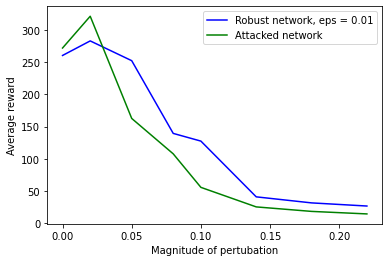

In [15]:
plt.figure(1)
plt.plot(epsilons_attacks,robust_average_rewards[0], "-b",label = "Robust network, eps = 0.01")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

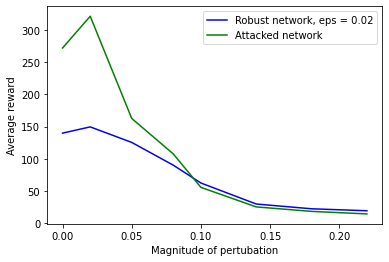

In [16]:
plt.figure(2)
plt.plot(epsilons_attacks,robust_average_rewards[1], "-b",label = "Robust network, eps = 0.02")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

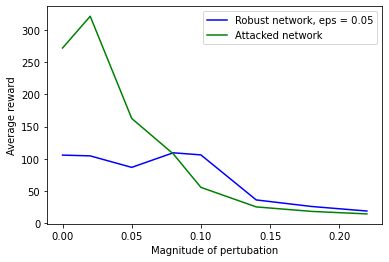

In [17]:
plt.figure(3)
plt.plot(epsilons_attacks,robust_average_rewards[2], "-b",label = "Robust network, eps = 0.05")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

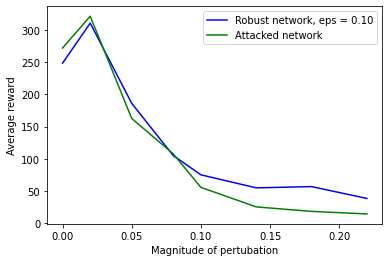

In [18]:
plt.figure(4)
plt.plot(epsilons_attacks,robust_average_rewards[3], "-b",label = "Robust network, eps = 0.10")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()